In [1]:
from __future__ import division
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
from scipy.misc import *
from ops import *
from datasets import *


import imageio

import pdb

from msssim import tf_ms_ssim

/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ajay/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

In [2]:
from scipy.misc import *
print(tf.__version__)

1.9.0


In [3]:
class Finn(object):
    def __init__(self, sess, df_dim, batch_size, dropout_prob, l1_weight, ssim_weight, clipping_weight, discriminator_weight, writer_path, video_path):
        self.df_dim = df_dim
        self.batch_size = batch_size
        self.dropout_prob = dropout_prob
        self.l1_weight = l1_weight
        self.ssim_weight = ssim_weight
        self.clipping_weight = clipping_weight
        self.discriminator_weight = discriminator_weight

        self.sess = sess
        self.writer_path = writer_path
        self.filename = 'fbp'
        self.video_path = video_path


        data = generateDataSet(self.video_path)
        self.train_doublets = data["train_doublets"]
        self.train_triplets = data["train_triplets"]
        self.train_singlets = self.train_triplets[:,:,:,3:6]
        self.val_doublets = data["val_doublets"]
        self.val_targets = data["val_targets"]
        self.mean_img = data["mean_img"]

        self.input_height = self.train_doublets.shape[1]
        self.input_width = self.train_doublets.shape[2]
        self.dataset_name = 'fbp'

        self.gen_layer_depths = [32, 64, 64, 128]
        self.gen_filter_sizes = [3, 3, 3, 3]

        self.max_outputs = 100

    def discriminator(self, triplet, phase, reuse = False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()

            h0 = lrelu(conv2d(triplet, self.df_dim, hh=4, ww=4, stride_w=2, stride_h=2, padding='VALID', name="d_h0_conv"))
            h1 = lrelu(bn(conv2d(h0, self.df_dim*2, hh=4, ww=4, stride_w=2, stride_h=2, padding='VALID', name="d_h1_conv"), phase, name="d_h1_bn"))
            h2 = lrelu(bn(conv2d(h1, self.df_dim*4, hh=4, ww=4, stride_w=2, stride_h=2, padding='VALID', name="d_h2_conv"), phase, name="d_h2_bn"))
            h3 = lrelu(bn(conv2d(h2, self.df_dim*8, hh=4, ww=4, stride_w=2, stride_h=2, padding='VALID', name="d_h3_conv"), phase, name="d_h3_bn"))
            h4 = conv2d(h3, 1, hh=4, ww=4, padding='SAME')
            #h4 = linear(tf.reshape(h3, [self.batch_size, -1]), 1, 'd_h3_lin')

            return tf.nn.sigmoid(h4), h4

    def generator(self, doublet):
        with tf.variable_scope("generator"):
            conv_outputs = []

            current_input = doublet
            current_inputdepth = doublet.shape[3]
            for i, outputdepth in enumerate(self.gen_layer_depths):
                result = conv_block(current_input, self.is_training, self.gen_filter_sizes[i], outputdepth, name=('g_conv_block'+str(i)) )
                conv_outputs.append(result)
                current_input = result
                current_inputdepth = outputdepth

            z = current_input

            rev_layer_depths = list(reversed(self.gen_layer_depths))
            rev_filter_sizes = list(reversed(self.gen_filter_sizes))
            rev_conv_outputs = list(reversed(conv_outputs))
#             for i in rev_conv_outputs:
#                 print(i.get_shape())

            # deconv portion
            for i, outputdepth in enumerate(rev_layer_depths[1:]): # reverse process exactly until last step

                result = bilinear_resize_deconv_block(current_input, self.is_training, rev_filter_sizes[i], outputdepth, name=('g_deconv_block'+str(i)) )
                if i <= 4:
                    result = tf.nn.dropout(result, self.dropout_prob)
                print( "result"+str(i), result.get_shape() )
                print("conc"+str(i),rev_conv_outputs[i+1].get_shape())
                stack = tf.concat([result, rev_conv_outputs[i+1]], 3)
                # print( i, stack.get_shape() )
                current_input = stack

            outputdepth = 3 # final image is 3 channel
            h = bilinear_resize_tanh_deconv_block(current_input, self.is_training, rev_filter_sizes[-1], outputdepth, name=('g_tanh_deconv') )
            return conv2d(h, outputdepth, hh=1, ww=1, mean=0.11, stddev=0.04, name='final_conv')

    def build_model(self):
        singlet_dims = [self.input_height, self.input_width, 3]
        image_dims = [self.input_height, self.input_width, 6]
        triplet_dims = [self.input_height, self.input_width, 9]

        # Set up placeholders
        self.singlets = tf.placeholder(tf.float32, [self.batch_size] + singlet_dims, name = 'singlets')
        self.doublets = tf.placeholder(tf.float32, [self.batch_size] + image_dims, name = 'doublets')
        self.triplets = tf.placeholder(tf.float32, [self.batch_size] + triplet_dims, name = 'triplets')
        self.is_training = tf.placeholder(tf.bool, (), name = 'is_training')

        sing_mean_added = self.singlets + self.mean_img

        # Sample generated frame from generator
        self.G = self.generator(self.doublets)
        g_mean_added = self.G + self.mean_img
#         g_mean_added_clipped = tf.clip_by_value(g_mean_added, 0, 1)

        # Assemble fake triplets using generated frame
        self.before, self.after = tf.split(self.doublets, [3, 3], 3)
        self.fake_triplets = tf.concat([self.before, self.G, self.after], 3)

        # Evaluate discrimator on real triplets
        self.D_real, self.D_real_logits = self.discriminator(self.triplets, self.is_training, reuse=False)
        # Use same discriminator on fake triplets
        self.D_fake, self.D_fake_logits = self.discriminator(self.fake_triplets, self.is_training, reuse=True)

        # Calculate GAN losses
        self.d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_real_logits, labels=tf.ones_like(self.D_real)))
        self.d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_fake_logits, labels=tf.zeros_like(self.D_fake)))
        self.g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=self.D_fake_logits, labels=tf.ones_like(self.D_fake)))

        # Calculate auxiliary losses
        self.ms_ssim_loss = tf.reduce_mean(-tf.log(tf_ms_ssim(g_mean_added, sing_mean_added)))

        eps = 1e-5
        self.l1_loss = tf.reduce_mean(tf.sqrt(tf.square(self.G - self.singlets) + eps))

#         self.clipping_loss = tf.reduce_mean(tf.square(g_mean_added - g_mean_added_clipped))

        # Combine losses into single functions for the discriminator and the generator
        self.d_loss_total = self.d_loss_fake + self.d_loss_real
#         self.g_loss_total = self.discriminator_weight*self.g_loss + \
#                                 self.l1_weight*self.l1_loss + \
#                                 self.ssim_weight*self.ms_ssim_loss + \
#                                 self.clipping_weight*self.clipping_loss
        self.g_loss_total = self.discriminator_weight*self.g_loss + \
                                self.l1_weight*self.l1_loss + \
                                self.ssim_weight*self.ms_ssim_loss


        # Record relevant variables to TensorBoard
        #  - discriminator logistic output
        self.d_real_sum = tf.summary.histogram("d_real", self.D_real)
        self.d_fake_sum = tf.summary.histogram("d_fake", self.D_fake)
        #  - discriminator losses on real and fake images
        self.d_loss_real_sum = tf.summary.scalar("real_loss", self.d_loss_real)
        self.d_loss_fake_sum = tf.summary.scalar("fake_loss", self.d_loss_fake)
        self.d_loss_total_sum = tf.summary.scalar("D_loss_total", self.d_loss_total)
        #  - generator losses
        self.g_loss_sum = tf.summary.scalar("G_loss", self.g_loss)
        self.l1_loss_sum = tf.summary.scalar("l1_loss", self.l1_loss)
        self.ms_ssim_loss_sum = tf.summary.scalar("ms_ssim_loss", self.ms_ssim_loss)
#         self.clipping_loss_sum = tf.summary.scalar("clipping_loss", self.clipping_loss)
        self.g_loss_total_sum = tf.summary.scalar("G_total_loss", self.g_loss_total)
        # - sample images
        self.num_images = self.batch_size

        # clipped_G_img = tf.nn.clip_by_value(self.G + self.mean_img, 0,1)
        clipped_G_img = self.G + self.mean_img
        self.G_image = tf.summary.image("G", clipped_G_img,
            max_outputs=self.max_outputs)
        self.before_image = tf.summary.image("Z1", self.before + self.mean_img, max_outputs=self.max_outputs)
        self.after_image = tf.summary.image("Z2", self.after + self.mean_img, max_outputs=self.max_outputs)

        # Collect trainable variables for the generator and discriminator
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'd_' in var.name]
        self.g_vars = [var for var in t_vars if 'g_' in var.name]

        self.saver = tf.train.Saver()

    def train(self, config):


        global_step = tf.placeholder(tf.float32, shape=[])
        g_learning_rate = tf.train.exponential_decay(config.g_learning_rate, global_step,
                                                   1, 0.96, staircase=True)
        d_learning_rate = tf.train.exponential_decay(config.d_learning_rate, global_step,
                                                   1, 0.96, staircase=True)
        g_optim_l1 = tf.train.AdamOptimizer(g_learning_rate, beta1=config.beta1
                                         ).minimize(self.l1_loss, var_list=self.g_vars)

        g_optim = tf.train.AdamOptimizer(g_learning_rate, beta1=config.beta1
                                         ).minimize(self.g_loss_total, var_list=self.g_vars)
        d_optim = tf.train.AdamOptimizer(d_learning_rate, beta1=config.beta1
                                                    ).minimize(self.d_loss_total, var_list=self.d_vars)

        tf.global_variables_initializer().run()

        self.g_sum = tf.summary.merge([self.g_loss_sum, self.l1_loss_sum, self.ms_ssim_loss_sum,
                                        self.g_loss_total_sum, self.d_loss_fake_sum, self.d_fake_sum])
        self.g_sum_l1 = tf.summary.merge([self.l1_loss_sum])
        self.d_sum = tf.summary.merge([self.d_loss_real_sum, self.d_real_sum, self.d_loss_total_sum])
        self.img_sum = tf.summary.merge([self.G_image, self.before_image, self.after_image])
        self.writer = tf.summary.FileWriter(self.writer_path + "/" + self.filename, self.sess.graph)


        train_doublets = self.train_doublets
        train_triplets = self.train_triplets
        val_doublets = self.val_doublets
        val_targets = self.val_targets
        train_singlets = self.train_singlets

        train_triplets_idx = np.arange(train_triplets.shape[0])
        np.random.shuffle(train_triplets_idx)
        # train_doublets_idx = np.arange(train_doublets.shape[0])
        # np.random.shuffle(train_doublets_idx)
        train_doublets_idx = train_triplets_idx


        counter = 1
        start_time = time.time()

        for epoch in range(config.epoch):
            print(epoch)
            batch_idx = len(train_doublets) // self.batch_size


            for idx in range(0, batch_idx):
                batch_images_idx = train_triplets_idx[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_images = train_triplets[batch_images_idx]

                batch_zs_idx = train_doublets_idx[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_zs = train_doublets[batch_zs_idx]

                batch_targets = train_singlets[batch_images_idx]


                if(config.train_gan):
                    # Update D network
                    _, summary_str = self.sess.run([d_optim, self.d_sum],
                                                   feed_dict={
                                                       self.triplets: batch_images,
                                                       self.doublets: batch_zs,
                                                       self.is_training: True,
                                                       global_step: epoch
                                                   })
                    self.writer.add_summary(summary_str, counter)

                    # Update G Network
                    _, summary_str = self.sess.run([g_optim, self.g_sum],
                                                   feed_dict={
                                                       self.doublets: batch_zs,
                                                       self.is_training: True,
                                                       self.singlets: batch_targets,
                                                       global_step: epoch
                                                   })
                    _, summary_str = self.sess.run([g_optim, self.g_sum],
                                                  feed_dict={
                                                      self.doublets: batch_zs,
                                                      self.is_training: True,
                                                      self.singlets: batch_targets,
                                                      global_step: epoch
                                                  })
                    self.writer.add_summary(summary_str, counter)
                else:
                    # Update G Network
                    _, summary_str = self.sess.run([g_optim_l1, self.g_sum_l1],
                                                   feed_dict={
                                                       self.doublets: batch_zs,
                                                       self.is_training: True,
                                                       self.singlets: batch_targets,
                                                       global_step: epoch
                                                   })
                    self.writer.add_summary(summary_str, counter)

                counter += 1

                errD_fake = self.d_loss_fake.eval({ self.doublets: batch_zs, self.is_training: True})
                errD_real = self.d_loss_real.eval({ self.triplets: batch_images, self.is_training: True})
                errG = self.g_loss.eval({self.doublets: batch_zs, self.is_training: True})
                errG_l1 = self.l1_loss.eval({self.doublets: batch_zs, self.singlets: batch_targets, self.is_training: True})
                errG_ssim = self.ms_ssim_loss.eval({self.doublets: batch_zs, self.singlets: batch_targets, self.is_training: True})
                
                
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss_total %.8f, g_loss %.8f, l1_loss %.8f, ms_ssim_loss %.8f" \
                      % (epoch, idx, batch_idx, time.time() - start_time, errD_fake+errD_real, errG, errG_l1, errG_ssim))

                if idx % 5 == 0:
                    summary_str = self.sess.run(self.img_sum,
                                                   feed_dict = {
                                                       self.doublets: train_doublets[train_doublets_idx[0:config.batch_size]],
                                                       self.is_training: True,
                                                   })
                    self.writer.add_summary(summary_str, counter)


            if np.mod(epoch, 5) == 0:
                self.save(config.checkpoint_dir, counter)

                # Save images to file
                # clipped_G_img = clip_keeping_color(self.G + self.mean_img)
                clipped_G_img = self.G + self.mean_img

                G_img = [self.sess.run(clipped_G_img,
                                           feed_dict = {
                                               self.doublets: train_doublets[k*self.batch_size:(k+1)*self.batch_size] ,
                                               self.is_training: True,
                                           }) for k in range(train_doublets.shape[0] // self.batch_size)]

                G_img = np.stack(G_img, axis=0)
                print('Saving images...')
                imageio.imwrite(config.image_dir+"mean_img.png",self.mean_img)
                [ imageio.imwrite(os.path.join(config.image_dir,"G_epoch%dimg%d.png" %
                 (epoch, i)), np.squeeze(G_img[i])) for i in range(G_img.shape[0]) ]

                if(epoch == 0):
                    # Save the targets

                    # Z_imgs = train_doublets[train_doublets_idx[0:config.batch_size]]
                    Z_imgs = train_doublets
                    [ imageio.imwrite(os.path.join(config.image_dir,"Z13_epoch%dimg%d.png" %
                     (epoch, i)), (Z_imgs[i,:,:,:3] + Z_imgs[i,:,:,3:])/2 + self.mean_img) for i in range(Z_imgs.shape[0]) ]
                    
                    Z1_imgs = train_doublets
                    [ imageio.imwrite(os.path.join(config.image_dir,"Z1_epoch%dimg%d.png" %
                     (epoch, i)), (Z1_imgs[i,:,:,:3]  + self.mean_img)) for i in range(Z1_imgs.shape[0]) ]
                    
                    Z3_imgs = train_doublets
                    [ imageio.imwrite(os.path.join(config.image_dir,"Z3_epoch%dimg%d.png" %
                     (epoch, i)), (Z3_imgs[i,:,:,3:]  + self.mean_img)) for i in range(Z3_imgs.shape[0]) ]
                    
                    # S_imgs = train_singlets[train_doublets_idx[0:config.batch_size]]
                    S_imgs = train_singlets
                    [ imageio.imwrite(os.path.join(config.image_dir,"Z2_epoch%dimg%d.png" %
                     (epoch, i)), S_imgs[i] + self.mean_img) for i in range(S_imgs.shape[0]) ]


                print('Images saved!')

    def test(self, config):
        self.load(config.checkpoint_dir)

        clipped_G_img = tf.clip_by_value(self.G + self.mean_img, 0,1)

        G_img = [self.sess.run(clipped_G_img,
                   feed_dict = {
                       self.doublets: self.val_doublets[k*self.batch_size:(k+1)*self.batch_size] ,
                       self.is_training: True,
                   }) for k in range(self.val_doublets.shape[0] // self.batch_size)]

        G_img = np.stack(G_img, axis=0)

        print('Saving images...')
        [ imageio.imwrite(os.path.join(config.test_image_dir,"G_valimageno%d.png" %
                 (i)), np.squeeze(G_img[i]+self.mean_img)) for i in range(G_img.shape[0]) ]


        Z_imgs = self.val_doublets
        [ imageio.imwrite(os.path.join(config.test_image_dir,"Z13_valimgno%d.png" %
                     (i)), (Z_imgs[i,:,:,:3] + Z_imgs[i,:,:,3:])/2 + self.mean_img) for i in range(Z_imgs.shape[0]) ]

        Z_imgs = self.val_targets
        [ imageio.imwrite(os.path.join(config.test_image_dir,"Z2_valimagno%d.png" %
                     (i)), Z_imgs[i] + self.mean_img) for i in range(Z_imgs.shape[0]) ]







    @property
    def model_dir(self):
        return "{}_{}_{}_{}".format(
            self.dataset_name, self.batch_size,
            self.input_height, self.input_width)

    def save(self, checkpoint_dir, step):
        model_name = "DCGAN.model"
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,
                        os.path.join(checkpoint_dir, model_name),
                        global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0


In [4]:
class Config:

    def __init__(self, epoch, g_learning_rate, d_learning_rate, beta1, batch_size):
        self.epoch = epoch
        self.g_learning_rate = g_learning_rate
        self.d_learning_rate = d_learning_rate
        self.beta1 = beta1
        self.batch_size = batch_size
        self.checkpoint_dir = '/home/ajay/work/Sparse CT/interpolation_GAN/Checkpoint/'
        self.train_gan = True
        self.image_dir = "/home/ajay/work/Sparse CT/interpolation_GAN/output/train/"
        self.test_image_dir = "/home/ajay/work/Sparse CT/interpolation_GAN/output/test/"


(103, 128, 128, 3)
(101, 128, 128, 6)
(101, 128, 128, 9)
input_ (1, 128, 128, 6)
input_ (1, 128, 128, 32)
input_ (1, 64, 64, 32)
input_ (1, 64, 64, 64)
input_ (1, 32, 32, 64)
input_ (1, 32, 32, 64)
input_ (1, 16, 16, 64)
input_ (1, 16, 16, 128)
input_ (1, 16, 16, 128)
input_ (1, 16, 16, 64)
result0 (1, 16, 16, 64)
conc0 (1, 16, 16, 64)
input_ (1, 32, 32, 128)
input_ (1, 32, 32, 64)
result1 (1, 32, 32, 64)
conc1 (1, 32, 32, 64)
input_ (1, 64, 64, 128)
input_ (1, 64, 64, 32)
result2 (1, 64, 64, 32)
conc2 (1, 64, 64, 32)
input_ (1, 128, 128, 64)
input_ (1, 128, 128, 3)
input_ (1, 128, 128, 3)
input_ (1, 128, 128, 9)
input_ (1, 64, 64, 64)
input_ (1, 32, 32, 128)
input_ (1, 16, 16, 256)
input_ (1, 8, 8, 512)
input_ (1, 128, 128, 9)
input_ (1, 64, 64, 64)
input_ (1, 32, 32, 128)
input_ (1, 16, 16, 256)
input_ (1, 8, 8, 512)
0
Epoch: [ 0] [   0/ 101] time: 3.1947, d_loss_total 1.27291870, g_loss 0.84030509, l1_loss 141.00538635, ms_ssim_loss 0.36808789
Epoch: [ 0] [   1/ 101] time: 4.3610, d

Epoch: [ 0] [  58/ 101] time: 63.7038, d_loss_total 0.04314434, g_loss 3.91426229, l1_loss 137.80015564, ms_ssim_loss 0.35680220
Epoch: [ 0] [  59/ 101] time: 64.6950, d_loss_total 0.03846209, g_loss 4.02188826, l1_loss 141.45115662, ms_ssim_loss 0.38531744
Epoch: [ 0] [  60/ 101] time: 65.7027, d_loss_total 0.04406725, g_loss 3.88918066, l1_loss 132.48434448, ms_ssim_loss 0.39481568
Epoch: [ 0] [  61/ 101] time: 66.8185, d_loss_total 0.04153489, g_loss 3.99949527, l1_loss 138.19206238, ms_ssim_loss 0.36146450
Epoch: [ 0] [  62/ 101] time: 67.8681, d_loss_total 0.04056126, g_loss 3.98212934, l1_loss 137.54884338, ms_ssim_loss 0.36382028
Epoch: [ 0] [  63/ 101] time: 68.8555, d_loss_total 0.04141992, g_loss 3.97763157, l1_loss 135.41233826, ms_ssim_loss 0.38079306
Epoch: [ 0] [  64/ 101] time: 69.9156, d_loss_total 0.03902792, g_loss 4.02570009, l1_loss 135.76319885, ms_ssim_loss 0.35717842
Epoch: [ 0] [  65/ 101] time: 71.0042, d_loss_total 0.03406546, g_loss 4.15614223, l1_loss 141.64

Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.313860893249512, 231.4809112548828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.313270568847656, 231.4776153564453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3284912109375, 231.4790496826172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.316182136535645, 231.4758758544922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.314818382263184, 231.47470092773438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.31459903717041, 231.4701385498047]. Con

Saving images...


Lossy conversion from float32 to uint8. Range [10.312874794006348, 231.46372985839844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.320335388183594, 231.4637908935547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.311690330505371, 231.46450805664062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.311898231506348, 231.4662628173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.31984806060791, 231.46849060058594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.320528984069824, 231.46849060058594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.316838264465332, 231.47250366210938

Lossy conversion from float32 to uint8. Range [10.318777084350586, 231.47386169433594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.314199447631836, 231.4719696044922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.315067291259766, 231.4744110107422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.313749313354492, 231.4739227294922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.31357479095459, 231.4735870361328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.31673812866211, 231.47476196289062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.318482398986816, 231.47402954101562]. 

Lossy conversion from float32 to uint8. Range [18.529125213623047, 481.6456298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.791261672973633, 483.1456298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.291261672973633, 478.23785400390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.36893081665039, 476.23785400390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.291261672973633, 471.92718505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [21.116504669189453, 471.0631103515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.291261672973633, 472.7330322265625].

Lossy conversion from float32 to uint8. Range [19.043689727783203, 479.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.543689727783203, 479.7232971191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.543689727783203, 479.1407775878906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [15.616504669189453, 480.50970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.543689727783203, 479.19415283203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [15.936893463134766, 478.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.543689727783203, 476.1941528320312

Lossy conversion from float32 to uint8. Range [21.116504669189453, 471.708740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [21.087379455566406, 473.2330322265625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.40776824951172, 473.2718505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.291261672973633, 472.75726318359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.543689727783203, 472.75726318359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [22.116504669189453, 475.82525634765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.543689727783203, 474.73785400390625].

Lossy conversion from float32 to uint8. Range [15.436893463134766, 475.55340576171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.242717742919922, 473.19415283203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.62135887145996, 471.59222412109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.543689727783203, 472.59222412109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.485435485839844, 471.95147705078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.533981323242188, 474.40777587890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.116504669189453, 474.097106933593

Lossy conversion from float32 to uint8. Range [21.543689727783203, 477.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.543689727783203, 474.88348388671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.36893081665039, 474.02911376953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.291261672973633, 476.02911376953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [22.59223175048828, 473.02911376953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.533981323242188, 471.40777587890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.116504669189453, 467.4077758789062

Lossy conversion from float32 to uint8. Range [16.533981323242188, 474.95147705078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.291261672973633, 475.7281494140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [15.543689727783203, 474.7864074707031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.116504669189453, 473.2038879394531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.7281551361084, 474.0194091796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.116504669189453, 474.0194091796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.116504669189453, 471.19415283203125]. C

Lossy conversion from float32 to uint8. Range [18.116504669189453, 467.40777587890625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [21.029125213623047, 468.8931884765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.116504669189453, 471.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.543689727783203, 474.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.116504669189453, 475.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.815532684326172, 475.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.116504669189453, 475.009704589843

Lossy conversion from float32 to uint8. Range [18.116504669189453, 471.19415283203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.291261672973633, 473.7961120605469]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.116504669189453, 473.4757080078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [15.543689727783203, 473.0776672363281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.291261672973633, 475.3495178222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.689319610595703, 471.25244140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [15.291261672973633, 475.41748046875]. Conv

Images saved!
1
Epoch: [ 1] [   0/ 101] time: 123.2033, d_loss_total 0.01925975, g_loss 4.69729328, l1_loss 140.81278992, ms_ssim_loss 0.36718982
Epoch: [ 1] [   1/ 101] time: 124.3317, d_loss_total 0.02255895, g_loss 4.56240463, l1_loss 134.69458008, ms_ssim_loss 0.38702071
Epoch: [ 1] [   2/ 101] time: 125.4402, d_loss_total 0.02041391, g_loss 4.70390129, l1_loss 143.02876282, ms_ssim_loss 0.39304063
Epoch: [ 1] [   3/ 101] time: 126.5406, d_loss_total 0.02080367, g_loss 4.63104773, l1_loss 135.88117981, ms_ssim_loss 0.36020082
Epoch: [ 1] [   4/ 101] time: 127.6035, d_loss_total 0.02163904, g_loss 4.62853909, l1_loss 143.73997498, ms_ssim_loss 0.36120254
Epoch: [ 1] [   5/ 101] time: 128.7438, d_loss_total 0.01926897, g_loss 4.69756413, l1_loss 137.08293152, ms_ssim_loss 0.34818661
Epoch: [ 1] [   6/ 101] time: 129.9301, d_loss_total 0.01903797, g_loss 4.71240282, l1_loss 139.04261780, ms_ssim_loss 0.36276549
Epoch: [ 1] [   7/ 101] time: 130.9519, d_loss_total 0.02012681, g_loss 4.

Epoch: [ 1] [  63/ 101] time: 189.4356, d_loss_total 0.01262159, g_loss 5.13931704, l1_loss 135.34367371, ms_ssim_loss 0.38108289
Epoch: [ 1] [  64/ 101] time: 190.5228, d_loss_total 0.01204106, g_loss 5.16154575, l1_loss 135.69389343, ms_ssim_loss 0.35757896
Epoch: [ 1] [  65/ 101] time: 191.5921, d_loss_total 0.01088293, g_loss 5.25856876, l1_loss 141.57109070, ms_ssim_loss 0.38533926
Epoch: [ 1] [  66/ 101] time: 192.7094, d_loss_total 0.01162579, g_loss 5.19738293, l1_loss 135.16812134, ms_ssim_loss 0.34673697
Epoch: [ 1] [  67/ 101] time: 193.6974, d_loss_total 0.01163200, g_loss 5.21913052, l1_loss 133.89204407, ms_ssim_loss 0.35088432
Epoch: [ 1] [  68/ 101] time: 194.6830, d_loss_total 0.01210542, g_loss 5.16816425, l1_loss 134.72303772, ms_ssim_loss 0.39117035
Epoch: [ 1] [  69/ 101] time: 195.6891, d_loss_total 0.01143502, g_loss 5.23261499, l1_loss 133.93110657, ms_ssim_loss 0.35294098
Epoch: [ 1] [  70/ 101] time: 196.6947, d_loss_total 0.01195552, g_loss 5.18070650, l1_los

Epoch: [ 2] [  26/ 101] time: 257.0977, d_loss_total 0.00779786, g_loss 5.61958599, l1_loss 142.16651917, ms_ssim_loss 0.38097408
Epoch: [ 2] [  27/ 101] time: 258.1175, d_loss_total 0.00727921, g_loss 5.64716244, l1_loss 139.44635010, ms_ssim_loss 0.35606632
Epoch: [ 2] [  28/ 101] time: 259.2148, d_loss_total 0.00802094, g_loss 5.57076931, l1_loss 135.36405945, ms_ssim_loss 0.34411830
Epoch: [ 2] [  29/ 101] time: 260.2642, d_loss_total 0.00755435, g_loss 5.64371634, l1_loss 140.67469788, ms_ssim_loss 0.38870087
Epoch: [ 2] [  30/ 101] time: 261.2974, d_loss_total 0.00794757, g_loss 5.57783318, l1_loss 134.25956726, ms_ssim_loss 0.35070831
Epoch: [ 2] [  31/ 101] time: 262.4282, d_loss_total 0.00879194, g_loss 5.49063444, l1_loss 133.94335938, ms_ssim_loss 0.39765671
Epoch: [ 2] [  32/ 101] time: 263.4503, d_loss_total 0.00838896, g_loss 5.52115679, l1_loss 140.90138245, ms_ssim_loss 0.35976639
Epoch: [ 2] [  33/ 101] time: 264.4616, d_loss_total 0.00709482, g_loss 5.66558075, l1_los

Epoch: [ 2] [  90/ 101] time: 325.4521, d_loss_total 0.00646584, g_loss 5.80518198, l1_loss 138.13822937, ms_ssim_loss 0.37098137
Epoch: [ 2] [  91/ 101] time: 326.5273, d_loss_total 0.00625568, g_loss 5.82771444, l1_loss 133.18745422, ms_ssim_loss 0.34871915
Epoch: [ 2] [  92/ 101] time: 327.5831, d_loss_total 0.00625919, g_loss 5.81622791, l1_loss 136.53852844, ms_ssim_loss 0.36517107
Epoch: [ 2] [  93/ 101] time: 328.6566, d_loss_total 0.00618617, g_loss 5.83450413, l1_loss 135.79537964, ms_ssim_loss 0.36672938
Epoch: [ 2] [  94/ 101] time: 329.6841, d_loss_total 0.00666137, g_loss 5.80368805, l1_loss 140.67424011, ms_ssim_loss 0.38470355
Epoch: [ 2] [  95/ 101] time: 330.7488, d_loss_total 0.00573852, g_loss 5.88728905, l1_loss 139.74931335, ms_ssim_loss 0.36164367
Epoch: [ 2] [  96/ 101] time: 331.8298, d_loss_total 0.00626059, g_loss 5.81993628, l1_loss 133.90916443, ms_ssim_loss 0.35280237
Epoch: [ 2] [  97/ 101] time: 332.8202, d_loss_total 0.00608360, g_loss 5.84821892, l1_los

Epoch: [ 3] [  53/ 101] time: 393.1748, d_loss_total 0.00554832, g_loss 5.93818903, l1_loss 133.49751282, ms_ssim_loss 0.38396439
Epoch: [ 3] [  54/ 101] time: 394.2710, d_loss_total 0.00549712, g_loss 5.94279814, l1_loss 134.62274170, ms_ssim_loss 0.40018418
Epoch: [ 3] [  55/ 101] time: 395.2484, d_loss_total 0.00523013, g_loss 5.99686432, l1_loss 135.31933594, ms_ssim_loss 0.36096495
Epoch: [ 3] [  56/ 101] time: 396.3343, d_loss_total 0.00516328, g_loss 6.01433420, l1_loss 137.12127686, ms_ssim_loss 0.38388363
Epoch: [ 3] [  57/ 101] time: 397.4262, d_loss_total 0.00555096, g_loss 5.99107361, l1_loss 139.83325195, ms_ssim_loss 0.38407254
Epoch: [ 3] [  58/ 101] time: 398.4275, d_loss_total 0.00496414, g_loss 6.04031324, l1_loss 137.69804382, ms_ssim_loss 0.35763335
Epoch: [ 3] [  59/ 101] time: 399.4292, d_loss_total 0.00473737, g_loss 6.07846403, l1_loss 141.35212708, ms_ssim_loss 0.38577372
Epoch: [ 3] [  60/ 101] time: 400.4357, d_loss_total 0.00542594, g_loss 5.96987009, l1_los

Epoch: [ 4] [  16/ 101] time: 460.2828, d_loss_total 0.00407262, g_loss 6.23592186, l1_loss 138.54887390, ms_ssim_loss 0.36981699
Epoch: [ 4] [  17/ 101] time: 461.3003, d_loss_total 0.00447433, g_loss 6.15757751, l1_loss 138.08787537, ms_ssim_loss 0.35592875
Epoch: [ 4] [  18/ 101] time: 462.3286, d_loss_total 0.00456348, g_loss 6.11677837, l1_loss 142.23020935, ms_ssim_loss 0.36017177
Epoch: [ 4] [  19/ 101] time: 463.3394, d_loss_total 0.00461963, g_loss 6.13092518, l1_loss 135.78695679, ms_ssim_loss 0.38412654
Epoch: [ 4] [  20/ 101] time: 464.4260, d_loss_total 0.00403468, g_loss 6.24138594, l1_loss 140.21191406, ms_ssim_loss 0.37462384
Epoch: [ 4] [  21/ 101] time: 465.5315, d_loss_total 0.00480843, g_loss 6.12579870, l1_loss 140.51441956, ms_ssim_loss 0.39068687
Epoch: [ 4] [  22/ 101] time: 466.5486, d_loss_total 0.00401990, g_loss 6.24042416, l1_loss 141.99913025, ms_ssim_loss 0.38694206
Epoch: [ 4] [  23/ 101] time: 467.5608, d_loss_total 0.00430561, g_loss 6.18163776, l1_los

Epoch: [ 4] [  80/ 101] time: 527.6045, d_loss_total 0.00351881, g_loss 6.37883282, l1_loss 139.08961487, ms_ssim_loss 0.35817403
Epoch: [ 4] [  81/ 101] time: 528.6870, d_loss_total 0.00379428, g_loss 6.31158113, l1_loss 137.49736023, ms_ssim_loss 0.35819298
Epoch: [ 4] [  82/ 101] time: 529.6951, d_loss_total 0.00372235, g_loss 6.31678963, l1_loss 137.38542175, ms_ssim_loss 0.35438249
Epoch: [ 4] [  83/ 101] time: 530.7268, d_loss_total 0.00379817, g_loss 6.30430460, l1_loss 135.37902832, ms_ssim_loss 0.36010069
Epoch: [ 4] [  84/ 101] time: 531.7999, d_loss_total 0.00348973, g_loss 6.39373779, l1_loss 138.38555908, ms_ssim_loss 0.36039105
Epoch: [ 4] [  85/ 101] time: 532.8160, d_loss_total 0.00365375, g_loss 6.33332396, l1_loss 138.99470520, ms_ssim_loss 0.34849295
Epoch: [ 4] [  86/ 101] time: 533.9435, d_loss_total 0.00386479, g_loss 6.29087591, l1_loss 137.86932373, ms_ssim_loss 0.38442284
Epoch: [ 4] [  87/ 101] time: 535.0260, d_loss_total 0.00382276, g_loss 6.34837198, l1_los

Epoch: [ 5] [  43/ 101] time: 595.0677, d_loss_total 0.00326157, g_loss 6.48106670, l1_loss 142.12544250, ms_ssim_loss 0.38950709
Epoch: [ 5] [  44/ 101] time: 596.0942, d_loss_total 0.00318015, g_loss 6.47239876, l1_loss 142.41120911, ms_ssim_loss 0.38942552
Epoch: [ 5] [  45/ 101] time: 597.0960, d_loss_total 0.00360871, g_loss 6.36145735, l1_loss 135.45362854, ms_ssim_loss 0.38043663
Epoch: [ 5] [  46/ 101] time: 598.1535, d_loss_total 0.00344429, g_loss 6.41701698, l1_loss 138.27854919, ms_ssim_loss 0.36788344
Epoch: [ 5] [  47/ 101] time: 599.1730, d_loss_total 0.00336277, g_loss 6.43051624, l1_loss 134.19314575, ms_ssim_loss 0.34898090
Epoch: [ 5] [  48/ 101] time: 600.2745, d_loss_total 0.00333695, g_loss 6.42503214, l1_loss 133.98860168, ms_ssim_loss 0.36008829
Epoch: [ 5] [  49/ 101] time: 601.2964, d_loss_total 0.00362619, g_loss 6.35283947, l1_loss 134.47084045, ms_ssim_loss 0.38660073
Epoch: [ 5] [  50/ 101] time: 602.3086, d_loss_total 0.00348808, g_loss 6.40329266, l1_los

Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362720489501953, 231.5167694091797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362170219421387, 231.5164337158203]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36316204071045, 231.51638793945312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.363633155822754, 231.5164794921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.360676765441895, 231.51612854003906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.363553047180176, 231.51622009277344].

Saving images...


Lossy conversion from float32 to uint8. Range [10.363436698913574, 231.515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.363181114196777, 231.5156707763672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.363753318786621, 231.5155487060547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362754821777344, 231.5159454345703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362269401550293, 231.51573181152344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.361656188964844, 231.51576232910156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.359748840332031, 231.51602172851562]. Conve

Lossy conversion from float32 to uint8. Range [10.36159896850586, 231.51675415039062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36165714263916, 231.51663208007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362399101257324, 231.51641845703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362129211425781, 231.5167694091797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.362776756286621, 231.5166778564453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.361903190612793, 231.5166473388672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.361915588378906, 231.51683044433594].

Images saved!
6
Epoch: [ 6] [   0/ 101] time: 664.3171, d_loss_total 0.00284839, g_loss 6.57942963, l1_loss 140.74743652, ms_ssim_loss 0.36755431
Epoch: [ 6] [   1/ 101] time: 665.4571, d_loss_total 0.00326985, g_loss 6.45424461, l1_loss 134.62934875, ms_ssim_loss 0.38739365
Epoch: [ 6] [   2/ 101] time: 666.6131, d_loss_total 0.00303860, g_loss 6.55576849, l1_loss 142.96450806, ms_ssim_loss 0.39348349
Epoch: [ 6] [   3/ 101] time: 667.7186, d_loss_total 0.00307049, g_loss 6.50817251, l1_loss 135.81794739, ms_ssim_loss 0.36068416
Epoch: [ 6] [   4/ 101] time: 668.7159, d_loss_total 0.00326514, g_loss 6.46667814, l1_loss 143.67753601, ms_ssim_loss 0.36156538
Epoch: [ 6] [   5/ 101] time: 669.7161, d_loss_total 0.00295164, g_loss 6.54947853, l1_loss 137.02137756, ms_ssim_loss 0.34860334
Epoch: [ 6] [   6/ 101] time: 670.7800, d_loss_total 0.00287218, g_loss 6.56280327, l1_loss 138.98184204, ms_ssim_loss 0.36320755
Epoch: [ 6] [   7/ 101] time: 671.7710, d_loss_total 0.00309673, g_loss 6.

Epoch: [ 6] [  63/ 101] time: 730.9329, d_loss_total 0.00295334, g_loss 6.56786442, l1_loss 135.31370544, ms_ssim_loss 0.38139907
Epoch: [ 6] [  64/ 101] time: 731.9541, d_loss_total 0.00281595, g_loss 6.59584379, l1_loss 135.66479492, ms_ssim_loss 0.35783401
Epoch: [ 6] [  65/ 101] time: 732.9410, d_loss_total 0.00262663, g_loss 6.66580343, l1_loss 141.54246521, ms_ssim_loss 0.38556370
Epoch: [ 6] [  66/ 101] time: 734.0526, d_loss_total 0.00276129, g_loss 6.61803150, l1_loss 135.13960266, ms_ssim_loss 0.34695563
Epoch: [ 6] [  67/ 101] time: 735.0265, d_loss_total 0.00277698, g_loss 6.61829138, l1_loss 133.86389160, ms_ssim_loss 0.35113230
Epoch: [ 6] [  68/ 101] time: 736.0534, d_loss_total 0.00289627, g_loss 6.58242035, l1_loss 134.69514465, ms_ssim_loss 0.39140704
Epoch: [ 6] [  69/ 101] time: 737.1056, d_loss_total 0.00276527, g_loss 6.62216520, l1_loss 133.90240479, ms_ssim_loss 0.35323676
Epoch: [ 6] [  70/ 101] time: 738.2368, d_loss_total 0.00292691, g_loss 6.56008673, l1_los

Epoch: [ 7] [  26/ 101] time: 798.0945, d_loss_total 0.00247206, g_loss 6.74665737, l1_loss 142.15078735, ms_ssim_loss 0.38114545
Epoch: [ 7] [  27/ 101] time: 799.0991, d_loss_total 0.00233563, g_loss 6.77343655, l1_loss 139.43061829, ms_ssim_loss 0.35614946
Epoch: [ 7] [  28/ 101] time: 800.1137, d_loss_total 0.00251590, g_loss 6.71421099, l1_loss 135.34799194, ms_ssim_loss 0.34422627
Epoch: [ 7] [  29/ 101] time: 801.1497, d_loss_total 0.00242658, g_loss 6.76397324, l1_loss 140.65888977, ms_ssim_loss 0.38884181
Epoch: [ 7] [  30/ 101] time: 802.2340, d_loss_total 0.00252105, g_loss 6.71017647, l1_loss 134.24403381, ms_ssim_loss 0.35083139
Epoch: [ 7] [  31/ 101] time: 803.3834, d_loss_total 0.00275524, g_loss 6.62913132, l1_loss 133.92701721, ms_ssim_loss 0.39777905
Epoch: [ 7] [  32/ 101] time: 804.4269, d_loss_total 0.00268892, g_loss 6.63763714, l1_loss 140.88606262, ms_ssim_loss 0.35995084
Epoch: [ 7] [  33/ 101] time: 805.3970, d_loss_total 0.00233073, g_loss 6.77425575, l1_los

Epoch: [ 7] [  90/ 101] time: 865.5038, d_loss_total 0.00243828, g_loss 6.75641918, l1_loss 138.12895203, ms_ssim_loss 0.37106586
Epoch: [ 7] [  91/ 101] time: 866.6198, d_loss_total 0.00234751, g_loss 6.78483868, l1_loss 133.17805481, ms_ssim_loss 0.34880769
Epoch: [ 7] [  92/ 101] time: 867.6692, d_loss_total 0.00236808, g_loss 6.77665758, l1_loss 136.52940369, ms_ssim_loss 0.36521974
Epoch: [ 7] [  93/ 101] time: 868.7204, d_loss_total 0.00236485, g_loss 6.78372908, l1_loss 135.78637695, ms_ssim_loss 0.36680394
Epoch: [ 7] [  94/ 101] time: 869.7310, d_loss_total 0.00252698, g_loss 6.75186014, l1_loss 140.66548157, ms_ssim_loss 0.38477957
Epoch: [ 7] [  95/ 101] time: 870.7419, d_loss_total 0.00219292, g_loss 6.83768749, l1_loss 139.74079895, ms_ssim_loss 0.36173087
Epoch: [ 7] [  96/ 101] time: 871.8360, d_loss_total 0.00234737, g_loss 6.78343010, l1_loss 133.90034485, ms_ssim_loss 0.35286462
Epoch: [ 7] [  97/ 101] time: 872.8767, d_loss_total 0.00233406, g_loss 6.79251957, l1_los

Epoch: [ 8] [  53/ 101] time: 933.0174, d_loss_total 0.00235835, g_loss 6.78289557, l1_loss 133.49192810, ms_ssim_loss 0.38404936
Epoch: [ 8] [  54/ 101] time: 934.0322, d_loss_total 0.00235476, g_loss 6.77143478, l1_loss 134.61677551, ms_ssim_loss 0.40028283
Epoch: [ 8] [  55/ 101] time: 935.1265, d_loss_total 0.00222953, g_loss 6.82922363, l1_loss 135.31352234, ms_ssim_loss 0.36102808
Epoch: [ 8] [  56/ 101] time: 936.2402, d_loss_total 0.00223195, g_loss 6.83500195, l1_loss 137.11532593, ms_ssim_loss 0.38394934
Epoch: [ 8] [  57/ 101] time: 937.2763, d_loss_total 0.00240018, g_loss 6.80522394, l1_loss 139.82777405, ms_ssim_loss 0.38414195
Epoch: [ 8] [  58/ 101] time: 938.2701, d_loss_total 0.00215065, g_loss 6.86365318, l1_loss 137.69261169, ms_ssim_loss 0.35769626
Epoch: [ 8] [  59/ 101] time: 939.3910, d_loss_total 0.00208946, g_loss 6.89059925, l1_loss 141.34681702, ms_ssim_loss 0.38584903
Epoch: [ 8] [  60/ 101] time: 940.4196, d_loss_total 0.00235165, g_loss 6.79000282, l1_los

Epoch: [ 9] [  16/ 101] time: 999.8846, d_loss_total 0.00196509, g_loss 6.95660973, l1_loss 138.54450989, ms_ssim_loss 0.36988956
Epoch: [ 9] [  17/ 101] time: 1000.9481, d_loss_total 0.00212724, g_loss 6.87859440, l1_loss 138.08374023, ms_ssim_loss 0.35595265
Epoch: [ 9] [  18/ 101] time: 1001.9437, d_loss_total 0.00218346, g_loss 6.83509254, l1_loss 142.22587585, ms_ssim_loss 0.36019152
Epoch: [ 9] [  19/ 101] time: 1002.9575, d_loss_total 0.00219175, g_loss 6.85637760, l1_loss 135.78230286, ms_ssim_loss 0.38416427
Epoch: [ 9] [  20/ 101] time: 1004.0147, d_loss_total 0.00195608, g_loss 6.95802212, l1_loss 140.20788574, ms_ssim_loss 0.37464032
Epoch: [ 9] [  21/ 101] time: 1005.0953, d_loss_total 0.00229389, g_loss 6.84581184, l1_loss 140.51037598, ms_ssim_loss 0.39075610
Epoch: [ 9] [  22/ 101] time: 1006.1173, d_loss_total 0.00194513, g_loss 6.95781803, l1_loss 141.99481201, ms_ssim_loss 0.38698050
Epoch: [ 9] [  23/ 101] time: 1007.1431, d_loss_total 0.00205520, g_loss 6.90215921,

Epoch: [ 9] [  79/ 101] time: 1066.5563, d_loss_total 0.00208247, g_loss 6.88880777, l1_loss 141.94134521, ms_ssim_loss 0.35360858
Epoch: [ 9] [  80/ 101] time: 1067.5526, d_loss_total 0.00181936, g_loss 7.02572060, l1_loss 139.08557129, ms_ssim_loss 0.35824209
Epoch: [ 9] [  81/ 101] time: 1068.6967, d_loss_total 0.00196163, g_loss 6.95438004, l1_loss 137.49261475, ms_ssim_loss 0.35821676
Epoch: [ 9] [  82/ 101] time: 1069.7612, d_loss_total 0.00191709, g_loss 6.96927309, l1_loss 137.38088989, ms_ssim_loss 0.35440820
Epoch: [ 9] [  83/ 101] time: 1070.7619, d_loss_total 0.00195060, g_loss 6.95477676, l1_loss 135.37483215, ms_ssim_loss 0.36012366
Epoch: [ 9] [  84/ 101] time: 1071.7810, d_loss_total 0.00181476, g_loss 7.03257656, l1_loss 138.38111877, ms_ssim_loss 0.36042568
Epoch: [ 9] [  85/ 101] time: 1072.8246, d_loss_total 0.00189679, g_loss 6.97741222, l1_loss 138.99029541, ms_ssim_loss 0.34851786
Epoch: [ 9] [  86/ 101] time: 1073.8814, d_loss_total 0.00199586, g_loss 6.93984890

Epoch: [10] [  41/ 101] time: 1132.6301, d_loss_total 0.00189467, g_loss 7.00022697, l1_loss 140.21075439, ms_ssim_loss 0.36211973
Epoch: [10] [  42/ 101] time: 1133.6772, d_loss_total 0.00198653, g_loss 6.95759678, l1_loss 133.09304810, ms_ssim_loss 0.39696819
Epoch: [10] [  43/ 101] time: 1134.7924, d_loss_total 0.00182753, g_loss 7.04794073, l1_loss 142.11956787, ms_ssim_loss 0.38950682
Epoch: [10] [  44/ 101] time: 1135.7891, d_loss_total 0.00177583, g_loss 7.05040836, l1_loss 142.40551758, ms_ssim_loss 0.38943553
Epoch: [10] [  45/ 101] time: 1136.8026, d_loss_total 0.00197831, g_loss 6.94986820, l1_loss 135.44850159, ms_ssim_loss 0.38045129
Epoch: [10] [  46/ 101] time: 1137.9194, d_loss_total 0.00189444, g_loss 7.00031042, l1_loss 138.27325439, ms_ssim_loss 0.36789688
Epoch: [10] [  47/ 101] time: 1138.9752, d_loss_total 0.00182867, g_loss 7.02700710, l1_loss 134.18814087, ms_ssim_loss 0.34899560
Epoch: [10] [  48/ 101] time: 1139.9977, d_loss_total 0.00181913, g_loss 7.01664734

Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.364806175231934, 231.51930236816406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365296363830566, 231.519287109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365226745605469, 231.51904296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365036964416504, 231.51922607421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365205764770508, 231.5191192626953]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365478515625, 231.51904296875]. Convert

Saving images...


Lossy conversion from float32 to uint8. Range [10.365212440490723, 231.51905822753906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36550235748291, 231.51889038085938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365079879760742, 231.51889038085938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.364731788635254, 231.51907348632812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365348815917969, 231.51895141601562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365119934082031, 231.51913452148438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365139961242676, 231.519165039062

Lossy conversion from float32 to uint8. Range [10.365667343139648, 231.51918029785156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365321159362793, 231.51919555664062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365410804748535, 231.5192108154297]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.364802360534668, 231.51910400390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365249633789062, 231.51913452148438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365324020385742, 231.51919555664062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365293502807617, 231.519363403320

Images saved!
11
Epoch: [11] [   0/ 101] time: 1203.7839, d_loss_total 0.00166788, g_loss 7.11003447, l1_loss 140.74090576, ms_ssim_loss 0.36757523
Epoch: [11] [   1/ 101] time: 1204.9772, d_loss_total 0.00189148, g_loss 6.99193907, l1_loss 134.62272644, ms_ssim_loss 0.38740382
Epoch: [11] [   2/ 101] time: 1205.9563, d_loss_total 0.00178580, g_loss 7.07553339, l1_loss 142.95668030, ms_ssim_loss 0.39349920
Epoch: [11] [   3/ 101] time: 1206.9961, d_loss_total 0.00177003, g_loss 7.05007267, l1_loss 135.81010437, ms_ssim_loss 0.36069760
Epoch: [11] [   4/ 101] time: 1208.0710, d_loss_total 0.00189674, g_loss 6.98883724, l1_loss 143.66900635, ms_ssim_loss 0.36157709
Epoch: [11] [   5/ 101] time: 1209.1338, d_loss_total 0.00172104, g_loss 7.07906342, l1_loss 137.01403809, ms_ssim_loss 0.34861416
Epoch: [11] [   6/ 101] time: 1210.2511, d_loss_total 0.00167382, g_loss 7.08941126, l1_loss 138.97401428, ms_ssim_loss 0.36322007
Epoch: [11] [   7/ 101] time: 1211.2540, d_loss_total 0.00180713, 

Epoch: [11] [  63/ 101] time: 1270.0948, d_loss_total 0.00178019, g_loss 7.06392288, l1_loss 135.30541992, ms_ssim_loss 0.38140944
Epoch: [11] [  64/ 101] time: 1271.0861, d_loss_total 0.00170017, g_loss 7.09186268, l1_loss 135.65661621, ms_ssim_loss 0.35784423
Epoch: [11] [  65/ 101] time: 1272.1226, d_loss_total 0.00161370, g_loss 7.14872551, l1_loss 141.53358459, ms_ssim_loss 0.38557422
Epoch: [11] [  66/ 101] time: 1273.2516, d_loss_total 0.00167860, g_loss 7.10667610, l1_loss 135.13151550, ms_ssim_loss 0.34696522
Epoch: [11] [  67/ 101] time: 1274.2675, d_loss_total 0.00168224, g_loss 7.10954762, l1_loss 133.85557556, ms_ssim_loss 0.35114086
Epoch: [11] [  68/ 101] time: 1275.3109, d_loss_total 0.00175171, g_loss 7.07836819, l1_loss 134.68693542, ms_ssim_loss 0.39141929
Epoch: [11] [  69/ 101] time: 1276.3355, d_loss_total 0.00167790, g_loss 7.11238956, l1_loss 133.89379883, ms_ssim_loss 0.35324839
Epoch: [11] [  70/ 101] time: 1277.4135, d_loss_total 0.00178517, g_loss 7.03819704

Epoch: [12] [  25/ 101] time: 1336.3976, d_loss_total 0.00153189, g_loss 7.18517017, l1_loss 138.13056946, ms_ssim_loss 0.36853868
Epoch: [12] [  26/ 101] time: 1337.5376, d_loss_total 0.00158647, g_loss 7.18312740, l1_loss 142.14169312, ms_ssim_loss 0.38115558
Epoch: [12] [  27/ 101] time: 1338.6023, d_loss_total 0.00149827, g_loss 7.21382618, l1_loss 139.42164612, ms_ssim_loss 0.35616377
Epoch: [12] [  28/ 101] time: 1339.6661, d_loss_total 0.00159500, g_loss 7.16087008, l1_loss 135.33943176, ms_ssim_loss 0.34424239
Epoch: [12] [  29/ 101] time: 1340.6930, d_loss_total 0.00156633, g_loss 7.19339561, l1_loss 140.64997864, ms_ssim_loss 0.38885307
Epoch: [12] [  30/ 101] time: 1341.8223, d_loss_total 0.00159230, g_loss 7.16092348, l1_loss 134.23547363, ms_ssim_loss 0.35083953
Epoch: [12] [  31/ 101] time: 1342.9051, d_loss_total 0.00173862, g_loss 7.08193827, l1_loss 133.91864014, ms_ssim_loss 0.39779475
Epoch: [12] [  32/ 101] time: 1343.9053, d_loss_total 0.00171220, g_loss 7.07626247

Epoch: [12] [  88/ 101] time: 1402.9939, d_loss_total 0.00156530, g_loss 7.18839502, l1_loss 138.34020996, ms_ssim_loss 0.37197295
Epoch: [12] [  89/ 101] time: 1403.9944, d_loss_total 0.00165039, g_loss 7.16637421, l1_loss 140.21099854, ms_ssim_loss 0.38532540
Epoch: [12] [  90/ 101] time: 1405.0037, d_loss_total 0.00159386, g_loss 7.17426109, l1_loss 138.12013245, ms_ssim_loss 0.37107196
Epoch: [12] [  91/ 101] time: 1406.1425, d_loss_total 0.00153743, g_loss 7.20152378, l1_loss 133.16947937, ms_ssim_loss 0.34880912
Epoch: [12] [  92/ 101] time: 1407.1348, d_loss_total 0.00154998, g_loss 7.19155884, l1_loss 136.52067566, ms_ssim_loss 0.36522120
Epoch: [12] [  93/ 101] time: 1408.1227, d_loss_total 0.00155186, g_loss 7.19505262, l1_loss 135.77775574, ms_ssim_loss 0.36680800
Epoch: [12] [  94/ 101] time: 1409.1207, d_loss_total 0.00167051, g_loss 7.15927315, l1_loss 140.65734863, ms_ssim_loss 0.38478264
Epoch: [12] [  95/ 101] time: 1410.1563, d_loss_total 0.00144999, g_loss 7.24659920

Epoch: [13] [  50/ 101] time: 1469.4364, d_loss_total 0.00155757, g_loss 7.19895506, l1_loss 136.69590759, ms_ssim_loss 0.37845653
Epoch: [13] [  51/ 101] time: 1470.7326, d_loss_total 0.00143554, g_loss 7.26415825, l1_loss 139.65802002, ms_ssim_loss 0.37876099
Epoch: [13] [  52/ 101] time: 1471.7756, d_loss_total 0.00151650, g_loss 7.21158171, l1_loss 140.82774353, ms_ssim_loss 0.36150539
Epoch: [13] [  53/ 101] time: 1472.8407, d_loss_total 0.00158514, g_loss 7.17823315, l1_loss 133.48352051, ms_ssim_loss 0.38404429
Epoch: [13] [  54/ 101] time: 1473.9474, d_loss_total 0.00158665, g_loss 7.16369534, l1_loss 134.60835266, ms_ssim_loss 0.40028149
Epoch: [13] [  55/ 101] time: 1475.0154, d_loss_total 0.00150098, g_loss 7.22337723, l1_loss 135.30505371, ms_ssim_loss 0.36101711
Epoch: [13] [  56/ 101] time: 1476.1145, d_loss_total 0.00151169, g_loss 7.22156239, l1_loss 137.10705566, ms_ssim_loss 0.38394445
Epoch: [13] [  57/ 101] time: 1477.1432, d_loss_total 0.00163339, g_loss 7.18557644

Epoch: [14] [  12/ 101] time: 1535.5781, d_loss_total 0.00148125, g_loss 7.24400759, l1_loss 137.84376526, ms_ssim_loss 0.35896280
Epoch: [14] [  13/ 101] time: 1536.6382, d_loss_total 0.00143224, g_loss 7.27667046, l1_loss 132.18321228, ms_ssim_loss 0.34902045
Epoch: [14] [  14/ 101] time: 1537.6352, d_loss_total 0.00140564, g_loss 7.29890251, l1_loss 141.27838135, ms_ssim_loss 0.38853875
Epoch: [14] [  15/ 101] time: 1538.6759, d_loss_total 0.00142204, g_loss 7.26895285, l1_loss 135.28569031, ms_ssim_loss 0.35320953
Epoch: [14] [  16/ 101] time: 1539.7290, d_loss_total 0.00137775, g_loss 7.31071281, l1_loss 138.53614807, ms_ssim_loss 0.36988905
Epoch: [14] [  17/ 101] time: 1540.7578, d_loss_total 0.00147904, g_loss 7.23631716, l1_loss 138.07548523, ms_ssim_loss 0.35595334
Epoch: [14] [  18/ 101] time: 1541.8441, d_loss_total 0.00153232, g_loss 7.18431139, l1_loss 142.21748352, ms_ssim_loss 0.36020109
Epoch: [14] [  19/ 101] time: 1542.8528, d_loss_total 0.00151977, g_loss 7.22092152

Epoch: [14] [  75/ 101] time: 1601.8534, d_loss_total 0.00141068, g_loss 7.29276657, l1_loss 138.18251038, ms_ssim_loss 0.36600477
Epoch: [14] [  76/ 101] time: 1602.9808, d_loss_total 0.00136525, g_loss 7.30775166, l1_loss 135.74674988, ms_ssim_loss 0.34488562
Epoch: [14] [  77/ 101] time: 1603.9719, d_loss_total 0.00145222, g_loss 7.24822330, l1_loss 139.81588745, ms_ssim_loss 0.35912293
Epoch: [14] [  78/ 101] time: 1605.0059, d_loss_total 0.00142553, g_loss 7.26627350, l1_loss 138.72529602, ms_ssim_loss 0.35048479
Epoch: [14] [  79/ 101] time: 1606.0948, d_loss_total 0.00149238, g_loss 7.21566200, l1_loss 141.93504333, ms_ssim_loss 0.35360450
Epoch: [14] [  80/ 101] time: 1607.1341, d_loss_total 0.00130363, g_loss 7.35779667, l1_loss 139.07838440, ms_ssim_loss 0.35824063
Epoch: [14] [  81/ 101] time: 1608.2304, d_loss_total 0.00140251, g_loss 7.28753424, l1_loss 137.48628235, ms_ssim_loss 0.35821760
Epoch: [14] [  82/ 101] time: 1609.2912, d_loss_total 0.00136796, g_loss 7.30713272

Epoch: [15] [  37/ 101] time: 1667.8270, d_loss_total 0.00133842, g_loss 7.33280182, l1_loss 133.78645325, ms_ssim_loss 0.35868788
Epoch: [15] [  38/ 101] time: 1668.9726, d_loss_total 0.00141935, g_loss 7.29898548, l1_loss 139.48614502, ms_ssim_loss 0.39157808
Epoch: [15] [  39/ 101] time: 1670.0179, d_loss_total 0.00139115, g_loss 7.29485703, l1_loss 138.89955139, ms_ssim_loss 0.35434595
Epoch: [15] [  40/ 101] time: 1671.0178, d_loss_total 0.00129432, g_loss 7.36905479, l1_loss 142.50659180, ms_ssim_loss 0.38405636
Epoch: [15] [  41/ 101] time: 1672.0865, d_loss_total 0.00137601, g_loss 7.31464148, l1_loss 140.20567322, ms_ssim_loss 0.36211795
Epoch: [15] [  42/ 101] time: 1673.0839, d_loss_total 0.00143681, g_loss 7.27928352, l1_loss 133.08863831, ms_ssim_loss 0.39697447
Epoch: [15] [  43/ 101] time: 1674.0771, d_loss_total 0.00134460, g_loss 7.35182095, l1_loss 142.11488342, ms_ssim_loss 0.38951683
Epoch: [15] [  44/ 101] time: 1675.0901, d_loss_total 0.00130417, g_loss 7.36109829

Epoch: [15] [ 100/ 101] time: 1733.9264, d_loss_total 0.00129801, g_loss 7.36702728, l1_loss 133.88090515, ms_ssim_loss 0.35526988


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366302490234375, 231.51980590820312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36640453338623, 231.51974487304688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366373062133789, 231.5196075439453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366442680358887, 231.51971435546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366507530212402, 231.51962280273438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366535186767578, 231.51966857910156

Saving images...


Lossy conversion from float32 to uint8. Range [10.366300582885742, 231.51966857910156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366559982299805, 231.51943969726562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366243362426758, 231.51966857910156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366435050964355, 231.5195770263672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366421699523926, 231.5195770263672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366327285766602, 231.5195770263672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36638069152832, 231.51971435546875]

Lossy conversion from float32 to uint8. Range [10.366479873657227, 231.51976013183594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366620063781738, 231.51976013183594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366674423217773, 231.51968383789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36642074584961, 231.51971435546875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366373062133789, 231.5196990966797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366485595703125, 231.51968383789062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366447448730469, 231.5197448730468

Images saved!
16
Epoch: [16] [   0/ 101] time: 1743.4840, d_loss_total 0.00124173, g_loss 7.40481663, l1_loss 140.73770142, ms_ssim_loss 0.36758193
Epoch: [16] [   1/ 101] time: 1744.6842, d_loss_total 0.00139154, g_loss 7.29965019, l1_loss 134.62023926, ms_ssim_loss 0.38740963
Epoch: [16] [   2/ 101] time: 1745.6629, d_loss_total 0.00133453, g_loss 7.36661005, l1_loss 142.95471191, ms_ssim_loss 0.39350319
Epoch: [16] [   3/ 101] time: 1746.6829, d_loss_total 0.00130860, g_loss 7.35403204, l1_loss 135.80882263, ms_ssim_loss 0.36070332
Epoch: [16] [   4/ 101] time: 1747.6964, d_loss_total 0.00141085, g_loss 7.28061056, l1_loss 143.66770935, ms_ssim_loss 0.36158341
Epoch: [16] [   5/ 101] time: 1748.8364, d_loss_total 0.00127827, g_loss 7.37672043, l1_loss 137.01234436, ms_ssim_loss 0.34861711
Epoch: [16] [   6/ 101] time: 1749.9226, d_loss_total 0.00124032, g_loss 7.38793182, l1_loss 138.97239685, ms_ssim_loss 0.36322194
Epoch: [16] [   7/ 101] time: 1750.9463, d_loss_total 0.00133994, 

Epoch: [16] [  63/ 101] time: 1810.7905, d_loss_total 0.00133217, g_loss 7.35411072, l1_loss 135.30485535, ms_ssim_loss 0.38141242
Epoch: [16] [  64/ 101] time: 1811.8834, d_loss_total 0.00127312, g_loss 7.38210011, l1_loss 135.65580750, ms_ssim_loss 0.35784730
Epoch: [16] [  65/ 101] time: 1813.0496, d_loss_total 0.00122006, g_loss 7.43022966, l1_loss 141.53303528, ms_ssim_loss 0.38557455
Epoch: [16] [  66/ 101] time: 1814.2134, d_loss_total 0.00125895, g_loss 7.39303493, l1_loss 135.13061523, ms_ssim_loss 0.34696540
Epoch: [16] [  67/ 101] time: 1815.2810, d_loss_total 0.00126372, g_loss 7.39531803, l1_loss 133.85505676, ms_ssim_loss 0.35114264
Epoch: [16] [  68/ 101] time: 1816.4098, d_loss_total 0.00131285, g_loss 7.36412239, l1_loss 134.68623352, ms_ssim_loss 0.39142236
Epoch: [16] [  69/ 101] time: 1817.5105, d_loss_total 0.00125916, g_loss 7.39938545, l1_loss 133.89337158, ms_ssim_loss 0.35324728
Epoch: [16] [  70/ 101] time: 1818.6451, d_loss_total 0.00134589, g_loss 7.31629896

Epoch: [17] [  25/ 101] time: 1879.4521, d_loss_total 0.00116679, g_loss 7.45513630, l1_loss 138.12988281, ms_ssim_loss 0.36854240
Epoch: [17] [  26/ 101] time: 1880.5232, d_loss_total 0.00122142, g_loss 7.44393635, l1_loss 142.14134216, ms_ssim_loss 0.38116708
Epoch: [17] [  27/ 101] time: 1881.5463, d_loss_total 0.00114963, g_loss 7.47826958, l1_loss 139.42143250, ms_ssim_loss 0.35616684
Epoch: [17] [  28/ 101] time: 1882.5682, d_loss_total 0.00121367, g_loss 7.43176174, l1_loss 135.33918762, ms_ssim_loss 0.34424484
Epoch: [17] [  29/ 101] time: 1883.5895, d_loss_total 0.00120793, g_loss 7.45371151, l1_loss 140.64961243, ms_ssim_loss 0.38886124
Epoch: [17] [  30/ 101] time: 1884.6080, d_loss_total 0.00121124, g_loss 7.43214893, l1_loss 134.23521423, ms_ssim_loss 0.35084468
Epoch: [17] [  31/ 101] time: 1885.7248, d_loss_total 0.00131923, g_loss 7.35718203, l1_loss 133.91835022, ms_ssim_loss 0.39779830
Epoch: [17] [  32/ 101] time: 1886.7555, d_loss_total 0.00131094, g_loss 7.34040451

Epoch: [17] [  88/ 101] time: 1946.3426, d_loss_total 0.00120828, g_loss 7.44526625, l1_loss 138.34008789, ms_ssim_loss 0.37197813
Epoch: [17] [  89/ 101] time: 1947.4105, d_loss_total 0.00128273, g_loss 7.41764688, l1_loss 140.21081543, ms_ssim_loss 0.38533068
Epoch: [17] [  90/ 101] time: 1948.5658, d_loss_total 0.00122910, g_loss 7.43558645, l1_loss 138.12001038, ms_ssim_loss 0.37107119
Epoch: [17] [  91/ 101] time: 1949.6479, d_loss_total 0.00118394, g_loss 7.46246529, l1_loss 133.16926575, ms_ssim_loss 0.34881100
Epoch: [17] [  92/ 101] time: 1950.6690, d_loss_total 0.00119738, g_loss 7.44837475, l1_loss 136.52050781, ms_ssim_loss 0.36522534
Epoch: [17] [  93/ 101] time: 1951.7067, d_loss_total 0.00120021, g_loss 7.44922543, l1_loss 135.77754211, ms_ssim_loss 0.36681187
Epoch: [17] [  94/ 101] time: 1952.7832, d_loss_total 0.00129788, g_loss 7.40945387, l1_loss 140.65614319, ms_ssim_loss 0.38478807
Epoch: [17] [  95/ 101] time: 1953.8862, d_loss_total 0.00112290, g_loss 7.50067139

Epoch: [18] [  50/ 101] time: 2012.9909, d_loss_total 0.00121308, g_loss 7.44994926, l1_loss 136.69563293, ms_ssim_loss 0.37845922
Epoch: [18] [  51/ 101] time: 2014.0439, d_loss_total 0.00112697, g_loss 7.50910234, l1_loss 139.65718079, ms_ssim_loss 0.37876567
Epoch: [18] [  52/ 101] time: 2015.0464, d_loss_total 0.00118643, g_loss 7.45574951, l1_loss 140.82749939, ms_ssim_loss 0.36151001
Epoch: [18] [  53/ 101] time: 2016.1010, d_loss_total 0.00123557, g_loss 7.42727804, l1_loss 133.48338318, ms_ssim_loss 0.38405007
Epoch: [18] [  54/ 101] time: 2017.1161, d_loss_total 0.00123372, g_loss 7.41589451, l1_loss 134.60816956, ms_ssim_loss 0.40028220
Epoch: [18] [  55/ 101] time: 2018.2099, d_loss_total 0.00116715, g_loss 7.47418022, l1_loss 135.30476379, ms_ssim_loss 0.36102226
Epoch: [18] [  56/ 101] time: 2019.3695, d_loss_total 0.00118206, g_loss 7.46773672, l1_loss 137.10679626, ms_ssim_loss 0.38394699
Epoch: [18] [  57/ 101] time: 2020.4647, d_loss_total 0.00128021, g_loss 7.42931175

Epoch: [19] [  12/ 101] time: 2079.5703, d_loss_total 0.00116914, g_loss 7.47596073, l1_loss 137.84371948, ms_ssim_loss 0.35896572
Epoch: [19] [  13/ 101] time: 2080.6045, d_loss_total 0.00112847, g_loss 7.51621723, l1_loss 132.18312073, ms_ssim_loss 0.34902442
Epoch: [19] [  14/ 101] time: 2081.6240, d_loss_total 0.00111838, g_loss 7.53124428, l1_loss 141.27830505, ms_ssim_loss 0.38854375
Epoch: [19] [  15/ 101] time: 2082.6188, d_loss_total 0.00111698, g_loss 7.51144028, l1_loss 135.28544617, ms_ssim_loss 0.35321409
Epoch: [19] [  16/ 101] time: 2083.7308, d_loss_total 0.00109176, g_loss 7.54414749, l1_loss 138.53605652, ms_ssim_loss 0.36989492
Epoch: [19] [  17/ 101] time: 2084.7730, d_loss_total 0.00116818, g_loss 7.46911335, l1_loss 138.07507324, ms_ssim_loss 0.35596022
Epoch: [19] [  18/ 101] time: 2085.8035, d_loss_total 0.00121575, g_loss 7.41498423, l1_loss 142.21714783, ms_ssim_loss 0.36020705
Epoch: [19] [  19/ 101] time: 2086.9016, d_loss_total 0.00119850, g_loss 7.46029377

Epoch: [19] [  75/ 101] time: 2146.2476, d_loss_total 0.00112502, g_loss 7.51902390, l1_loss 138.18243408, ms_ssim_loss 0.36601061
Epoch: [19] [  76/ 101] time: 2147.4383, d_loss_total 0.00108802, g_loss 7.53316355, l1_loss 135.74671936, ms_ssim_loss 0.34488857
Epoch: [19] [  77/ 101] time: 2148.5056, d_loss_total 0.00116005, g_loss 7.47252655, l1_loss 139.81576538, ms_ssim_loss 0.35912934
Epoch: [19] [  78/ 101] time: 2149.5767, d_loss_total 0.00113930, g_loss 7.48843145, l1_loss 138.72520447, ms_ssim_loss 0.35048956
Epoch: [19] [  79/ 101] time: 2150.6721, d_loss_total 0.00119478, g_loss 7.43630743, l1_loss 141.93493652, ms_ssim_loss 0.35360891
Epoch: [19] [  80/ 101] time: 2151.7978, d_loss_total 0.00104126, g_loss 7.57979727, l1_loss 139.07824707, ms_ssim_loss 0.35824439
Epoch: [19] [  81/ 101] time: 2152.9010, d_loss_total 0.00112169, g_loss 7.50904989, l1_loss 137.48625183, ms_ssim_loss 0.35822085
Epoch: [19] [  82/ 101] time: 2153.9062, d_loss_total 0.00109265, g_loss 7.53207493

Epoch: [20] [  37/ 101] time: 2213.6196, d_loss_total 0.00106998, g_loss 7.55659103, l1_loss 133.78636169, ms_ssim_loss 0.35868618
Epoch: [20] [  38/ 101] time: 2214.6780, d_loss_total 0.00114611, g_loss 7.51229191, l1_loss 139.48596191, ms_ssim_loss 0.39157772
Epoch: [20] [  39/ 101] time: 2215.7485, d_loss_total 0.00111929, g_loss 7.50968742, l1_loss 138.89936829, ms_ssim_loss 0.35434628
Epoch: [20] [  40/ 101] time: 2216.8349, d_loss_total 0.00104588, g_loss 7.58538055, l1_loss 142.50665283, ms_ssim_loss 0.38405758
Epoch: [20] [  41/ 101] time: 2217.9683, d_loss_total 0.00110585, g_loss 7.52918577, l1_loss 140.20561218, ms_ssim_loss 0.36211905
Epoch: [20] [  42/ 101] time: 2219.0070, d_loss_total 0.00114910, g_loss 7.50146103, l1_loss 133.08853149, ms_ssim_loss 0.39697739
Epoch: [20] [  43/ 101] time: 2220.0814, d_loss_total 0.00108821, g_loss 7.56239319, l1_loss 142.11474609, ms_ssim_loss 0.38951859
Epoch: [20] [  44/ 101] time: 2221.1793, d_loss_total 0.00105496, g_loss 7.57700253

Epoch: [20] [ 100/ 101] time: 2279.9567, d_loss_total 0.00104500, g_loss 7.58457470, l1_loss 133.88049316, ms_ssim_loss 0.35527030


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36628532409668, 231.52027893066406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366543769836426, 231.52015686035156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366499900817871, 231.5203094482422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366199493408203, 231.52024841308594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366254806518555, 231.520263671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366188049316406, 231.5201416015625]. 

Saving images...


Lossy conversion from float32 to uint8. Range [10.366416931152344, 231.52027893066406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366271018981934, 231.52035522460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366425514221191, 231.52029418945312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36638355255127, 231.5203094482422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366360664367676, 231.52029418945312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366434097290039, 231.52035522460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36612319946289, 231.52035522460938

Lossy conversion from float32 to uint8. Range [10.366355895996094, 231.52020263671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366531372070312, 231.52027893066406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366436004638672, 231.5203857421875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.365860939025879, 231.5204620361328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366521835327148, 231.52035522460938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366354942321777, 231.52020263671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366376876831055, 231.5204772949218

Images saved!
21
Epoch: [21] [   0/ 101] time: 2289.6523, d_loss_total 0.00100812, g_loss 7.61580801, l1_loss 140.73786926, ms_ssim_loss 0.36757994
Epoch: [21] [   1/ 101] time: 2290.7695, d_loss_total 0.00112252, g_loss 7.51622009, l1_loss 134.62037659, ms_ssim_loss 0.38741076
Epoch: [21] [   2/ 101] time: 2291.7511, d_loss_total 0.00108629, g_loss 7.57226944, l1_loss 142.95472717, ms_ssim_loss 0.39350104
Epoch: [21] [   3/ 101] time: 2292.7476, d_loss_total 0.00105455, g_loss 7.56934977, l1_loss 135.80870056, ms_ssim_loss 0.36070442
Epoch: [21] [   4/ 101] time: 2293.7502, d_loss_total 0.00114628, g_loss 7.48768806, l1_loss 143.66773987, ms_ssim_loss 0.36158419
Epoch: [21] [   5/ 101] time: 2294.8181, d_loss_total 0.00103638, g_loss 7.58572102, l1_loss 137.01219177, ms_ssim_loss 0.34862176
Epoch: [21] [   6/ 101] time: 2295.9092, d_loss_total 0.00100534, g_loss 7.59916782, l1_loss 138.97241211, ms_ssim_loss 0.36322108
Epoch: [21] [   7/ 101] time: 2296.9442, d_loss_total 0.00108569, 

Epoch: [21] [  63/ 101] time: 2355.7449, d_loss_total 0.00108428, g_loss 7.56126308, l1_loss 135.30474854, ms_ssim_loss 0.38141423
Epoch: [21] [  64/ 101] time: 2356.8278, d_loss_total 0.00103388, g_loss 7.59014702, l1_loss 135.65571594, ms_ssim_loss 0.35784826
Epoch: [21] [  65/ 101] time: 2357.9973, d_loss_total 0.00100008, g_loss 7.63211441, l1_loss 141.53289795, ms_ssim_loss 0.38557491
Epoch: [21] [  66/ 101] time: 2359.1185, d_loss_total 0.00102473, g_loss 7.59765625, l1_loss 135.13053894, ms_ssim_loss 0.34696665
Epoch: [21] [  67/ 101] time: 2360.2495, d_loss_total 0.00102865, g_loss 7.60147524, l1_loss 133.85491943, ms_ssim_loss 0.35114339
Epoch: [21] [  68/ 101] time: 2361.3397, d_loss_total 0.00106807, g_loss 7.57003021, l1_loss 134.68617249, ms_ssim_loss 0.39142361
Epoch: [21] [  69/ 101] time: 2362.3973, d_loss_total 0.00102452, g_loss 7.60521030, l1_loss 133.89324951, ms_ssim_loss 0.35325083
Epoch: [21] [  70/ 101] time: 2363.4395, d_loss_total 0.00109957, g_loss 7.51504707

Epoch: [22] [  25/ 101] time: 2422.5142, d_loss_total 0.00095862, g_loss 7.65245008, l1_loss 138.12969971, ms_ssim_loss 0.36854386
Epoch: [22] [  26/ 101] time: 2423.5868, d_loss_total 0.00100944, g_loss 7.63711166, l1_loss 142.14114380, ms_ssim_loss 0.38116649
Epoch: [22] [  27/ 101] time: 2424.6150, d_loss_total 0.00094745, g_loss 7.67388153, l1_loss 139.42126465, ms_ssim_loss 0.35616666
Epoch: [22] [  28/ 101] time: 2425.7048, d_loss_total 0.00099681, g_loss 7.62814140, l1_loss 135.33900452, ms_ssim_loss 0.34424230
Epoch: [22] [  29/ 101] time: 2426.8317, d_loss_total 0.00100001, g_loss 7.64606047, l1_loss 140.64941406, ms_ssim_loss 0.38886160
Epoch: [22] [  30/ 101] time: 2427.8992, d_loss_total 0.00099230, g_loss 7.63327599, l1_loss 134.23506165, ms_ssim_loss 0.35084504
Epoch: [22] [  31/ 101] time: 2429.0184, d_loss_total 0.00108045, g_loss 7.55661917, l1_loss 133.91818237, ms_ssim_loss 0.39779821
Epoch: [22] [  32/ 101] time: 2430.0882, d_loss_total 0.00107903, g_loss 7.53352594

Epoch: [22] [  88/ 101] time: 2489.5760, d_loss_total 0.00099821, g_loss 7.63693047, l1_loss 138.33992004, ms_ssim_loss 0.37197578
Epoch: [22] [  89/ 101] time: 2490.6536, d_loss_total 0.00106590, g_loss 7.60364723, l1_loss 140.21069336, ms_ssim_loss 0.38532901
Epoch: [22] [  90/ 101] time: 2491.7052, d_loss_total 0.00101639, g_loss 7.62888050, l1_loss 138.11987305, ms_ssim_loss 0.37107196
Epoch: [22] [  91/ 101] time: 2492.7849, d_loss_total 0.00097749, g_loss 7.65543699, l1_loss 133.16917419, ms_ssim_loss 0.34881201
Epoch: [22] [  92/ 101] time: 2493.8442, d_loss_total 0.00099098, g_loss 7.63810253, l1_loss 136.52038574, ms_ssim_loss 0.36522499
Epoch: [22] [  93/ 101] time: 2494.9173, d_loss_total 0.00099209, g_loss 7.63954830, l1_loss 135.77743530, ms_ssim_loss 0.36681119
Epoch: [22] [  94/ 101] time: 2496.0143, d_loss_total 0.00107872, g_loss 7.59349442, l1_loss 140.65599060, ms_ssim_loss 0.38478729
Epoch: [22] [  95/ 101] time: 2497.0987, d_loss_total 0.00093048, g_loss 7.68897629

Epoch: [23] [  50/ 101] time: 2555.7177, d_loss_total 0.00100975, g_loss 7.63608408, l1_loss 136.69548035, ms_ssim_loss 0.37845880
Epoch: [23] [  51/ 101] time: 2556.7923, d_loss_total 0.00094179, g_loss 7.69331646, l1_loss 139.65702820, ms_ssim_loss 0.37876716
Epoch: [23] [  52/ 101] time: 2557.7929, d_loss_total 0.00098986, g_loss 7.63637733, l1_loss 140.82737732, ms_ssim_loss 0.36150992
Epoch: [23] [  53/ 101] time: 2558.8098, d_loss_total 0.00102567, g_loss 7.61390114, l1_loss 133.48318481, ms_ssim_loss 0.38405067
Epoch: [23] [  54/ 101] time: 2559.9119, d_loss_total 0.00102549, g_loss 7.60151100, l1_loss 134.60801697, ms_ssim_loss 0.40028194
Epoch: [23] [  55/ 101] time: 2560.9381, d_loss_total 0.00097026, g_loss 7.65967941, l1_loss 135.30461121, ms_ssim_loss 0.36102566
Epoch: [23] [  56/ 101] time: 2562.0581, d_loss_total 0.00098320, g_loss 7.65165615, l1_loss 137.10667419, ms_ssim_loss 0.38394821
Epoch: [23] [  57/ 101] time: 2563.0478, d_loss_total 0.00107070, g_loss 7.60846329

Epoch: [24] [  12/ 101] time: 2622.9930, d_loss_total 0.00098132, g_loss 7.64931965, l1_loss 137.84349060, ms_ssim_loss 0.35896266
Epoch: [24] [  13/ 101] time: 2624.1053, d_loss_total 0.00094615, g_loss 7.69284821, l1_loss 132.18286133, ms_ssim_loss 0.34902248
Epoch: [24] [  14/ 101] time: 2625.1815, d_loss_total 0.00094420, g_loss 7.70446587, l1_loss 141.27812195, ms_ssim_loss 0.38854298
Epoch: [24] [  15/ 101] time: 2626.2130, d_loss_total 0.00093395, g_loss 7.69183445, l1_loss 135.28529358, ms_ssim_loss 0.35321334
Epoch: [24] [  16/ 101] time: 2627.3581, d_loss_total 0.00091872, g_loss 7.72025299, l1_loss 138.53588867, ms_ssim_loss 0.36989319
Epoch: [24] [  17/ 101] time: 2628.3773, d_loss_total 0.00098093, g_loss 7.64081764, l1_loss 138.07493591, ms_ssim_loss 0.35595876
Epoch: [24] [  18/ 101] time: 2629.3710, d_loss_total 0.00102337, g_loss 7.58809900, l1_loss 142.21702576, ms_ssim_loss 0.36020663
Epoch: [24] [  19/ 101] time: 2630.3694, d_loss_total 0.00100382, g_loss 7.63972950

Epoch: [24] [  75/ 101] time: 2689.7439, d_loss_total 0.00095093, g_loss 7.68979645, l1_loss 138.18228149, ms_ssim_loss 0.36600974
Epoch: [24] [  76/ 101] time: 2691.0101, d_loss_total 0.00092024, g_loss 7.70163345, l1_loss 135.74645996, ms_ssim_loss 0.34488779
Epoch: [24] [  77/ 101] time: 2692.0237, d_loss_total 0.00098333, g_loss 7.63775444, l1_loss 139.81559753, ms_ssim_loss 0.35912636
Epoch: [24] [  78/ 101] time: 2693.0216, d_loss_total 0.00096483, g_loss 7.65393877, l1_loss 138.72505188, ms_ssim_loss 0.35048869
Epoch: [24] [  79/ 101] time: 2694.0183, d_loss_total 0.00101321, g_loss 7.60292768, l1_loss 141.93479919, ms_ssim_loss 0.35360730
Epoch: [24] [  80/ 101] time: 2695.0207, d_loss_total 0.00088078, g_loss 7.74854469, l1_loss 139.07809448, ms_ssim_loss 0.35824412
Epoch: [24] [  81/ 101] time: 2696.1023, d_loss_total 0.00095000, g_loss 7.67703581, l1_loss 137.48600769, ms_ssim_loss 0.35821983
Epoch: [24] [  82/ 101] time: 2697.1077, d_loss_total 0.00092489, g_loss 7.70060635

Epoch: [25] [  37/ 101] time: 2756.7313, d_loss_total 0.00090694, g_loss 7.72260094, l1_loss 133.78622437, ms_ssim_loss 0.35868692
Epoch: [25] [  38/ 101] time: 2757.8191, d_loss_total 0.00097859, g_loss 7.67205286, l1_loss 139.48583984, ms_ssim_loss 0.39157736
Epoch: [25] [  39/ 101] time: 2758.8481, d_loss_total 0.00095443, g_loss 7.66861486, l1_loss 138.89921570, ms_ssim_loss 0.35434613
Epoch: [25] [  40/ 101] time: 2759.8382, d_loss_total 0.00089447, g_loss 7.74576187, l1_loss 142.50634766, ms_ssim_loss 0.38405690
Epoch: [25] [  41/ 101] time: 2760.9127, d_loss_total 0.00094230, g_loss 7.68857527, l1_loss 140.20545959, ms_ssim_loss 0.36211881
Epoch: [25] [  42/ 101] time: 2762.0308, d_loss_total 0.00097349, g_loss 7.66698170, l1_loss 133.08839417, ms_ssim_loss 0.39697698
Epoch: [25] [  43/ 101] time: 2763.0978, d_loss_total 0.00092946, g_loss 7.72183418, l1_loss 142.11456299, ms_ssim_loss 0.38951835
Epoch: [25] [  44/ 101] time: 2764.1225, d_loss_total 0.00090276, g_loss 7.73771238

Epoch: [25] [ 100/ 101] time: 2823.2849, d_loss_total 0.00089148, g_loss 7.74419594, l1_loss 133.87989807, ms_ssim_loss 0.35526538


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366599082946777, 231.52061462402344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366545677185059, 231.52064514160156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366544723510742, 231.5205535888672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366540908813477, 231.52056884765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36660385131836, 231.52053833007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36655330657959, 231.52056884765625]

Saving images...


Lossy conversion from float32 to uint8. Range [10.366554260253906, 231.52049255371094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36653995513916, 231.52052307128906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366607666015625, 231.52053833007812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366631507873535, 231.52049255371094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366630554199219, 231.5205535888672]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36651611328125, 231.52059936523438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366630554199219, 231.52052307128906

Lossy conversion from float32 to uint8. Range [10.366598129272461, 231.52061462402344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36662483215332, 231.5205841064453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366567611694336, 231.52059936523438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366605758666992, 231.5205841064453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366594314575195, 231.5205841064453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366592407226562, 231.52061462402344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366552352905273, 231.52059936523438]

Images saved!
26
Epoch: [26] [   0/ 101] time: 2832.9076, d_loss_total 0.00086526, g_loss 7.77354670, l1_loss 140.73735046, ms_ssim_loss 0.36757651
Epoch: [26] [   1/ 101] time: 2834.0325, d_loss_total 0.00096071, g_loss 7.67379093, l1_loss 134.61988831, ms_ssim_loss 0.38740647
Epoch: [26] [   2/ 101] time: 2835.1372, d_loss_total 0.00093357, g_loss 7.72500134, l1_loss 142.95420837, ms_ssim_loss 0.39350045
Epoch: [26] [   3/ 101] time: 2836.1861, d_loss_total 0.00090208, g_loss 7.72640038, l1_loss 135.80822754, ms_ssim_loss 0.36070091
Epoch: [26] [   4/ 101] time: 2837.2314, d_loss_total 0.00098517, g_loss 7.64138842, l1_loss 143.66725159, ms_ssim_loss 0.36157984
Epoch: [26] [   5/ 101] time: 2838.3218, d_loss_total 0.00088965, g_loss 7.73930454, l1_loss 137.01171875, ms_ssim_loss 0.34861711
Epoch: [26] [   6/ 101] time: 2839.4101, d_loss_total 0.00086260, g_loss 7.75336838, l1_loss 138.97192383, ms_ssim_loss 0.36321920
Epoch: [26] [   7/ 101] time: 2840.4305, d_loss_total 0.00093209, 

Epoch: [26] [  63/ 101] time: 2900.4721, d_loss_total 0.00093335, g_loss 7.71221638, l1_loss 135.30461121, ms_ssim_loss 0.38141459
Epoch: [26] [  64/ 101] time: 2901.5446, d_loss_total 0.00088952, g_loss 7.74112749, l1_loss 135.65557861, ms_ssim_loss 0.35784799
Epoch: [26] [  65/ 101] time: 2902.5650, d_loss_total 0.00086476, g_loss 7.78031826, l1_loss 141.53277588, ms_ssim_loss 0.38557526
Epoch: [26] [  66/ 101] time: 2903.6562, d_loss_total 0.00088268, g_loss 7.74662018, l1_loss 135.13040161, ms_ssim_loss 0.34696716
Epoch: [26] [  67/ 101] time: 2904.6766, d_loss_total 0.00088614, g_loss 7.75076294, l1_loss 133.85478210, ms_ssim_loss 0.35114375
Epoch: [26] [  68/ 101] time: 2905.8127, d_loss_total 0.00091879, g_loss 7.71918631, l1_loss 134.68603516, ms_ssim_loss 0.39142227
Epoch: [26] [  69/ 101] time: 2906.8597, d_loss_total 0.00088362, g_loss 7.75398827, l1_loss 133.89311218, ms_ssim_loss 0.35324982
Epoch: [26] [  70/ 101] time: 2907.9314, d_loss_total 0.00095079, g_loss 7.66028404

Epoch: [27] [  25/ 101] time: 2966.9552, d_loss_total 0.00083059, g_loss 7.79599333, l1_loss 138.12965393, ms_ssim_loss 0.36854255
Epoch: [27] [  26/ 101] time: 2968.1206, d_loss_total 0.00087770, g_loss 7.77747011, l1_loss 142.14108276, ms_ssim_loss 0.38116631
Epoch: [27] [  27/ 101] time: 2969.2894, d_loss_total 0.00082260, g_loss 7.81776714, l1_loss 139.42118835, ms_ssim_loss 0.35616565
Epoch: [27] [  28/ 101] time: 2970.3625, d_loss_total 0.00086394, g_loss 7.76976681, l1_loss 135.33894348, ms_ssim_loss 0.34424484
Epoch: [27] [  29/ 101] time: 2971.3582, d_loss_total 0.00087047, g_loss 7.78578377, l1_loss 140.64935303, ms_ssim_loss 0.38886169
Epoch: [27] [  30/ 101] time: 2972.4240, d_loss_total 0.00085930, g_loss 7.77769995, l1_loss 134.23498535, ms_ssim_loss 0.35084504
Epoch: [27] [  31/ 101] time: 2973.5270, d_loss_total 0.00093349, g_loss 7.70198202, l1_loss 133.91810608, ms_ssim_loss 0.39779839
Epoch: [27] [  32/ 101] time: 2974.5328, d_loss_total 0.00093767, g_loss 7.67370653

Epoch: [27] [  88/ 101] time: 3034.1602, d_loss_total 0.00086801, g_loss 7.77466106, l1_loss 138.33984375, ms_ssim_loss 0.37197709
Epoch: [27] [  89/ 101] time: 3035.1946, d_loss_total 0.00093104, g_loss 7.73718357, l1_loss 140.21063232, ms_ssim_loss 0.38532838
Epoch: [27] [  90/ 101] time: 3036.2352, d_loss_total 0.00088391, g_loss 7.76828814, l1_loss 138.11981201, ms_ssim_loss 0.37107232
Epoch: [27] [  91/ 101] time: 3037.3658, d_loss_total 0.00085139, g_loss 7.79281330, l1_loss 133.16911316, ms_ssim_loss 0.34881142
Epoch: [27] [  92/ 101] time: 3038.3965, d_loss_total 0.00086393, g_loss 7.77397919, l1_loss 136.52032471, ms_ssim_loss 0.36522448
Epoch: [27] [  93/ 101] time: 3039.4024, d_loss_total 0.00086375, g_loss 7.77726698, l1_loss 135.77735901, ms_ssim_loss 0.36681178
Epoch: [27] [  94/ 101] time: 3040.4646, d_loss_total 0.00094299, g_loss 7.72634459, l1_loss 140.65591431, ms_ssim_loss 0.38478744
Epoch: [27] [  95/ 101] time: 3041.4767, d_loss_total 0.00081080, g_loss 7.82681847

Epoch: [28] [  50/ 101] time: 3101.8163, d_loss_total 0.00088189, g_loss 7.77086258, l1_loss 136.69541931, ms_ssim_loss 0.37845853
Epoch: [28] [  51/ 101] time: 3102.9226, d_loss_total 0.00082530, g_loss 7.82660770, l1_loss 139.65693665, ms_ssim_loss 0.37876698
Epoch: [28] [  52/ 101] time: 3104.0144, d_loss_total 0.00086643, g_loss 7.76741600, l1_loss 140.82728577, ms_ssim_loss 0.36150959
Epoch: [28] [  53/ 101] time: 3105.0522, d_loss_total 0.00089454, g_loss 7.74921703, l1_loss 133.48310852, ms_ssim_loss 0.38405040
Epoch: [28] [  54/ 101] time: 3106.1044, d_loss_total 0.00089475, g_loss 7.73679924, l1_loss 134.60795593, ms_ssim_loss 0.40028140
Epoch: [28] [  55/ 101] time: 3107.1485, d_loss_total 0.00084785, g_loss 7.79385138, l1_loss 135.30455017, ms_ssim_loss 0.36102566
Epoch: [28] [  56/ 101] time: 3108.2952, d_loss_total 0.00085960, g_loss 7.78359127, l1_loss 137.10659790, ms_ssim_loss 0.38394794
Epoch: [28] [  57/ 101] time: 3109.3995, d_loss_total 0.00093959, g_loss 7.73697424

Epoch: [29] [  12/ 101] time: 3169.2357, d_loss_total 0.00086282, g_loss 7.77449942, l1_loss 137.84342957, ms_ssim_loss 0.35896221
Epoch: [29] [  13/ 101] time: 3170.2266, d_loss_total 0.00083055, g_loss 7.82165003, l1_loss 132.18280029, ms_ssim_loss 0.34902248
Epoch: [29] [  14/ 101] time: 3171.2437, d_loss_total 0.00083217, g_loss 7.83239079, l1_loss 141.27803040, ms_ssim_loss 0.38854325
Epoch: [29] [  15/ 101] time: 3172.3366, d_loss_total 0.00081901, g_loss 7.82324934, l1_loss 135.28521729, ms_ssim_loss 0.35321188
Epoch: [29] [  16/ 101] time: 3173.4487, d_loss_total 0.00080816, g_loss 7.85013771, l1_loss 138.53581238, ms_ssim_loss 0.36989421
Epoch: [29] [  17/ 101] time: 3174.5026, d_loss_total 0.00086217, g_loss 7.76779175, l1_loss 138.07485962, ms_ssim_loss 0.35595697
Epoch: [29] [  18/ 101] time: 3175.5701, d_loss_total 0.00090174, g_loss 7.71507835, l1_loss 142.21694946, ms_ssim_loss 0.36020577
Epoch: [29] [  19/ 101] time: 3176.5809, d_loss_total 0.00088102, g_loss 7.76904011

Epoch: [29] [  75/ 101] time: 3236.6414, d_loss_total 0.00083724, g_loss 7.81534624, l1_loss 138.18223572, ms_ssim_loss 0.36600947
Epoch: [29] [  76/ 101] time: 3237.7200, d_loss_total 0.00081186, g_loss 7.82660866, l1_loss 135.74638367, ms_ssim_loss 0.34488788
Epoch: [29] [  77/ 101] time: 3238.7137, d_loss_total 0.00086894, g_loss 7.76059723, l1_loss 139.81553650, ms_ssim_loss 0.35912728
Epoch: [29] [  78/ 101] time: 3239.7370, d_loss_total 0.00085231, g_loss 7.77670050, l1_loss 138.72499084, ms_ssim_loss 0.35048896
Epoch: [29] [  79/ 101] time: 3240.7924, d_loss_total 0.00089606, g_loss 7.72658443, l1_loss 141.93473816, ms_ssim_loss 0.35360748
Epoch: [29] [  80/ 101] time: 3241.8211, d_loss_total 0.00077652, g_loss 7.87432766, l1_loss 139.07804871, ms_ssim_loss 0.35824481
Epoch: [29] [  81/ 101] time: 3242.9129, d_loss_total 0.00083766, g_loss 7.80203581, l1_loss 137.48596191, ms_ssim_loss 0.35821983
Epoch: [29] [  82/ 101] time: 3243.9213, d_loss_total 0.00081663, g_loss 7.82564259

Epoch: [30] [  37/ 101] time: 3303.1710, d_loss_total 0.00080032, g_loss 7.84706306, l1_loss 133.78617859, ms_ssim_loss 0.35868642
Epoch: [30] [  38/ 101] time: 3304.1671, d_loss_total 0.00086759, g_loss 7.79269266, l1_loss 139.48577881, ms_ssim_loss 0.39157701
Epoch: [30] [  39/ 101] time: 3305.1645, d_loss_total 0.00084578, g_loss 7.78823853, l1_loss 138.89916992, ms_ssim_loss 0.35434553
Epoch: [30] [  40/ 101] time: 3306.1626, d_loss_total 0.00079300, g_loss 7.86659527, l1_loss 142.50628662, ms_ssim_loss 0.38405681
Epoch: [30] [  41/ 101] time: 3307.2296, d_loss_total 0.00083416, g_loss 7.80753326, l1_loss 140.20541382, ms_ssim_loss 0.36211982
Epoch: [30] [  42/ 101] time: 3308.2469, d_loss_total 0.00085905, g_loss 7.79042435, l1_loss 133.08833313, ms_ssim_loss 0.39697644
Epoch: [30] [  43/ 101] time: 3309.2673, d_loss_total 0.00082382, g_loss 7.84311056, l1_loss 142.11450195, ms_ssim_loss 0.38951764
Epoch: [30] [  44/ 101] time: 3310.2841, d_loss_total 0.00080064, g_loss 7.85873365

Epoch: [30] [ 100/ 101] time: 3370.5240, d_loss_total 0.00078931, g_loss 7.86487198, l1_loss 133.87986755, ms_ssim_loss 0.35526547


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3667573928833, 231.52076721191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366764068603516, 231.52073669433594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366716384887695, 231.520751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366743087768555, 231.520751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36672592163086, 231.52072143554688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366789817810059, 231.52072143554688]. Co

Saving images...


Lossy conversion from float32 to uint8. Range [10.36674690246582, 231.5207061767578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36678695678711, 231.5206298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366716384887695, 231.52072143554688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366692543029785, 231.52073669433594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366798400878906, 231.52069091796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366778373718262, 231.52064514160156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366667747497559, 231.52073669433594]

Lossy conversion from float32 to uint8. Range [10.366781234741211, 231.5207061767578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36670207977295, 231.52073669433594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366740226745605, 231.52073669433594]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366747856140137, 231.52076721191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366720199584961, 231.520751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366713523864746, 231.520751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366720199584961, 231.52073669433594]. 

Images saved!
31
Epoch: [31] [   0/ 101] time: 3380.3691, d_loss_total 0.00076851, g_loss 7.89390135, l1_loss 140.73728943, ms_ssim_loss 0.36757815
Epoch: [31] [   1/ 101] time: 3381.5612, d_loss_total 0.00085128, g_loss 7.79442978, l1_loss 134.61985779, ms_ssim_loss 0.38740683
Epoch: [31] [   2/ 101] time: 3382.5410, d_loss_total 0.00082961, g_loss 7.84316063, l1_loss 142.95414734, ms_ssim_loss 0.39350072
Epoch: [31] [   3/ 101] time: 3383.5333, d_loss_total 0.00079913, g_loss 7.84732914, l1_loss 135.80818176, ms_ssim_loss 0.36070099
Epoch: [31] [   4/ 101] time: 3384.5754, d_loss_total 0.00087699, g_loss 7.75802231, l1_loss 143.66722107, ms_ssim_loss 0.36158043
Epoch: [31] [   5/ 101] time: 3385.6197, d_loss_total 0.00079036, g_loss 7.85803175, l1_loss 137.01167297, ms_ssim_loss 0.34861729
Epoch: [31] [   6/ 101] time: 3386.7009, d_loss_total 0.00076585, g_loss 7.87264156, l1_loss 138.97187805, ms_ssim_loss 0.36321998
Epoch: [31] [   7/ 101] time: 3387.8548, d_loss_total 0.00082804, 

Epoch: [31] [  63/ 101] time: 3447.7653, d_loss_total 0.00082975, g_loss 7.82971334, l1_loss 135.30458069, ms_ssim_loss 0.38141504
Epoch: [31] [  64/ 101] time: 3448.8454, d_loss_total 0.00078998, g_loss 7.85983753, l1_loss 135.65554810, ms_ssim_loss 0.35784772
Epoch: [31] [  65/ 101] time: 3449.8504, d_loss_total 0.00077073, g_loss 7.89593220, l1_loss 141.53273010, ms_ssim_loss 0.38557491
Epoch: [31] [  66/ 101] time: 3450.9480, d_loss_total 0.00078487, g_loss 7.86362457, l1_loss 135.13037109, ms_ssim_loss 0.34696656
Epoch: [31] [  67/ 101] time: 3451.9520, d_loss_total 0.00078817, g_loss 7.86788845, l1_loss 133.85475159, ms_ssim_loss 0.35114408
Epoch: [31] [  68/ 101] time: 3452.9330, d_loss_total 0.00081728, g_loss 7.83498573, l1_loss 134.68601990, ms_ssim_loss 0.39142290
Epoch: [31] [  69/ 101] time: 3453.9766, d_loss_total 0.00078620, g_loss 7.87059641, l1_loss 133.89308167, ms_ssim_loss 0.35325032
Epoch: [31] [  70/ 101] time: 3454.9974, d_loss_total 0.00084885, g_loss 7.77397299

Epoch: [32] [  25/ 101] time: 3514.0223, d_loss_total 0.00074115, g_loss 7.91005802, l1_loss 138.12962341, ms_ssim_loss 0.36854482
Epoch: [32] [  26/ 101] time: 3515.1302, d_loss_total 0.00078567, g_loss 7.88864708, l1_loss 142.14105225, ms_ssim_loss 0.38116735
Epoch: [32] [  27/ 101] time: 3516.1472, d_loss_total 0.00073469, g_loss 7.93216848, l1_loss 139.42115784, ms_ssim_loss 0.35616642
Epoch: [32] [  28/ 101] time: 3517.2474, d_loss_total 0.00077138, g_loss 7.88282204, l1_loss 135.33892822, ms_ssim_loss 0.34424460
Epoch: [32] [  29/ 101] time: 3518.2948, d_loss_total 0.00077962, g_loss 7.89663696, l1_loss 140.64933777, ms_ssim_loss 0.38886133
Epoch: [32] [  30/ 101] time: 3519.3226, d_loss_total 0.00076663, g_loss 7.89204741, l1_loss 134.23497009, ms_ssim_loss 0.35084444
Epoch: [32] [  31/ 101] time: 3520.4135, d_loss_total 0.00083136, g_loss 7.81743526, l1_loss 133.91809082, ms_ssim_loss 0.39779812
Epoch: [32] [  32/ 101] time: 3521.4176, d_loss_total 0.00083948, g_loss 7.78460407

Epoch: [32] [  88/ 101] time: 3580.5019, d_loss_total 0.00077642, g_loss 7.88531971, l1_loss 138.33984375, ms_ssim_loss 0.37197691
Epoch: [32] [  89/ 101] time: 3581.5329, d_loss_total 0.00083613, g_loss 7.84439564, l1_loss 140.21061707, ms_ssim_loss 0.38532928
Epoch: [32] [  90/ 101] time: 3582.5549, d_loss_total 0.00078980, g_loss 7.88048601, l1_loss 138.11979675, ms_ssim_loss 0.37107146
Epoch: [32] [  91/ 101] time: 3583.8953, d_loss_total 0.00076166, g_loss 7.90364742, l1_loss 133.16908264, ms_ssim_loss 0.34881225
Epoch: [32] [  92/ 101] time: 3584.9833, d_loss_total 0.00077348, g_loss 7.88453436, l1_loss 136.52030945, ms_ssim_loss 0.36522552
Epoch: [32] [  93/ 101] time: 3585.9975, d_loss_total 0.00077281, g_loss 7.88866091, l1_loss 135.77734375, ms_ssim_loss 0.36681151
Epoch: [32] [  94/ 101] time: 3586.9999, d_loss_total 0.00084735, g_loss 7.83297825, l1_loss 140.65591431, ms_ssim_loss 0.38478762
Epoch: [32] [  95/ 101] time: 3588.1208, d_loss_total 0.00072582, g_loss 7.93714428

Epoch: [33] [  50/ 101] time: 3647.8754, d_loss_total 0.00079056, g_loss 7.87976837, l1_loss 136.69540405, ms_ssim_loss 0.37845913
Epoch: [33] [  51/ 101] time: 3648.9669, d_loss_total 0.00074090, g_loss 7.93521070, l1_loss 139.65693665, ms_ssim_loss 0.37876865
Epoch: [33] [  52/ 101] time: 3649.9810, d_loss_total 0.00077747, g_loss 7.87473774, l1_loss 140.82728577, ms_ssim_loss 0.36151060
Epoch: [33] [  53/ 101] time: 3651.0223, d_loss_total 0.00080183, g_loss 7.85823345, l1_loss 133.48310852, ms_ssim_loss 0.38404945
Epoch: [33] [  54/ 101] time: 3652.0605, d_loss_total 0.00080116, g_loss 7.84704685, l1_loss 134.60795593, ms_ssim_loss 0.40028274
Epoch: [33] [  55/ 101] time: 3653.0970, d_loss_total 0.00075982, g_loss 7.90317249, l1_loss 135.30455017, ms_ssim_loss 0.36102611
Epoch: [33] [  56/ 101] time: 3654.2403, d_loss_total 0.00077129, g_loss 7.89178467, l1_loss 137.10658264, ms_ssim_loss 0.38394830
Epoch: [33] [  57/ 101] time: 3655.3113, d_loss_total 0.00084628, g_loss 7.84093285

Epoch: [34] [  12/ 101] time: 3714.0937, d_loss_total 0.00077583, g_loss 7.87892723, l1_loss 137.84342957, ms_ssim_loss 0.35896280
Epoch: [34] [  13/ 101] time: 3715.1531, d_loss_total 0.00074668, g_loss 7.92791319, l1_loss 132.18280029, ms_ssim_loss 0.34902307
Epoch: [34] [  14/ 101] time: 3716.1905, d_loss_total 0.00074965, g_loss 7.93743324, l1_loss 141.27803040, ms_ssim_loss 0.38854307
Epoch: [34] [  15/ 101] time: 3717.2334, d_loss_total 0.00073609, g_loss 7.93022442, l1_loss 135.28521729, ms_ssim_loss 0.35321274
Epoch: [34] [  16/ 101] time: 3718.3434, d_loss_total 0.00072733, g_loss 7.95697308, l1_loss 138.53581238, ms_ssim_loss 0.36989397
Epoch: [34] [  17/ 101] time: 3719.3619, d_loss_total 0.00077557, g_loss 7.87234879, l1_loss 138.07484436, ms_ssim_loss 0.35595733
Epoch: [34] [  18/ 101] time: 3720.3647, d_loss_total 0.00081259, g_loss 7.81975365, l1_loss 142.21693420, ms_ssim_loss 0.36020604
Epoch: [34] [  19/ 101] time: 3721.4475, d_loss_total 0.00079213, g_loss 7.87509155

Epoch: [34] [  75/ 101] time: 3780.3366, d_loss_total 0.00075429, g_loss 7.91901398, l1_loss 138.18223572, ms_ssim_loss 0.36600992
Epoch: [34] [  76/ 101] time: 3781.4176, d_loss_total 0.00073230, g_loss 7.93076754, l1_loss 135.74638367, ms_ssim_loss 0.34488881
Epoch: [34] [  77/ 101] time: 3782.4436, d_loss_total 0.00078385, g_loss 7.86313677, l1_loss 139.81553650, ms_ssim_loss 0.35912746
Epoch: [34] [  78/ 101] time: 3783.5930, d_loss_total 0.00076903, g_loss 7.87866974, l1_loss 138.72499084, ms_ssim_loss 0.35048988
Epoch: [34] [  79/ 101] time: 3784.6418, d_loss_total 0.00080988, g_loss 7.82902241, l1_loss 141.93473816, ms_ssim_loss 0.35360730
Epoch: [34] [  80/ 101] time: 3785.6430, d_loss_total 0.00070037, g_loss 7.97779036, l1_loss 139.07801819, ms_ssim_loss 0.35824457
Epoch: [34] [  81/ 101] time: 3786.7048, d_loss_total 0.00075516, g_loss 7.90522385, l1_loss 137.48594666, ms_ssim_loss 0.35822043
Epoch: [34] [  82/ 101] time: 3787.7646, d_loss_total 0.00073701, g_loss 7.92933035

Epoch: [35] [  37/ 101] time: 3847.0656, d_loss_total 0.00072183, g_loss 7.94986773, l1_loss 133.78617859, ms_ssim_loss 0.35868677
Epoch: [35] [  38/ 101] time: 3848.0632, d_loss_total 0.00078546, g_loss 7.89174747, l1_loss 139.48577881, ms_ssim_loss 0.39157745
Epoch: [35] [  39/ 101] time: 3849.0873, d_loss_total 0.00076440, g_loss 7.88884640, l1_loss 138.89916992, ms_ssim_loss 0.35434568
Epoch: [35] [  40/ 101] time: 3850.1581, d_loss_total 0.00071722, g_loss 7.96752548, l1_loss 142.50628662, ms_ssim_loss 0.38405785
Epoch: [35] [  41/ 101] time: 3851.4110, d_loss_total 0.00075366, g_loss 7.90756083, l1_loss 140.20541382, ms_ssim_loss 0.36212078
Epoch: [35] [  42/ 101] time: 3852.4701, d_loss_total 0.00077516, g_loss 7.89247417, l1_loss 133.08833313, ms_ssim_loss 0.39697802
Epoch: [35] [  43/ 101] time: 3853.4847, d_loss_total 0.00074591, g_loss 7.94295788, l1_loss 142.11450195, ms_ssim_loss 0.38951781
Epoch: [35] [  44/ 101] time: 3854.5148, d_loss_total 0.00072416, g_loss 7.95936298

Epoch: [35] [ 100/ 101] time: 3913.9389, d_loss_total 0.00071352, g_loss 7.96520472, l1_loss 133.87986755, ms_ssim_loss 0.35526589


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366835594177246, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3668794631958, 231.5208282470703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366819381713867, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366793632507324, 231.5208282470703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366812705993652, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366811752319336, 231.5208282470703]. 

Saving images...


Lossy conversion from float32 to uint8. Range [10.366798400878906, 231.5207977294922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366833686828613, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366849899291992, 231.52078247070312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366817474365234, 231.5207977294922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366820335388184, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366781234741211, 231.5208282470703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366813659667969, 231.5207977294922]

Lossy conversion from float32 to uint8. Range [10.366864204406738, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366800308227539, 231.5208282470703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366842269897461, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366841316223145, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366830825805664, 231.52081298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366844177246094, 231.5208282470703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366809844970703, 231.5208282470703

Images saved!
36
Epoch: [36] [   0/ 101] time: 3923.8678, d_loss_total 0.00069614, g_loss 7.99429178, l1_loss 140.73728943, ms_ssim_loss 0.36757797
Epoch: [36] [   1/ 101] time: 3924.9550, d_loss_total 0.00076975, g_loss 7.89556074, l1_loss 134.61985779, ms_ssim_loss 0.38740778
Epoch: [36] [   2/ 101] time: 3925.9698, d_loss_total 0.00075252, g_loss 7.94007444, l1_loss 142.95414734, ms_ssim_loss 0.39350158
Epoch: [36] [   3/ 101] time: 3926.9811, d_loss_total 0.00072178, g_loss 7.94929934, l1_loss 135.80818176, ms_ssim_loss 0.36070177
Epoch: [36] [   4/ 101] time: 3927.9705, d_loss_total 0.00079562, g_loss 7.85543442, l1_loss 143.66722107, ms_ssim_loss 0.36158007
Epoch: [36] [   5/ 101] time: 3929.0406, d_loss_total 0.00071605, g_loss 7.95810318, l1_loss 137.01167297, ms_ssim_loss 0.34861806
Epoch: [36] [   6/ 101] time: 3930.1831, d_loss_total 0.00069280, g_loss 7.97358894, l1_loss 138.97187805, ms_ssim_loss 0.36322135
Epoch: [36] [   7/ 101] time: 3931.2219, d_loss_total 0.00074980, 

Epoch: [36] [  63/ 101] time: 3991.0827, d_loss_total 0.00075227, g_loss 7.92769241, l1_loss 135.30458069, ms_ssim_loss 0.38141564
Epoch: [36] [  64/ 101] time: 3992.1265, d_loss_total 0.00071463, g_loss 7.96013832, l1_loss 135.65554810, ms_ssim_loss 0.35784850
Epoch: [36] [  65/ 101] time: 3993.2190, d_loss_total 0.00069910, g_loss 7.99359322, l1_loss 141.53273010, ms_ssim_loss 0.38557553
Epoch: [36] [  66/ 101] time: 3994.4373, d_loss_total 0.00071077, g_loss 7.96279716, l1_loss 135.13037109, ms_ssim_loss 0.34696794
Epoch: [36] [  67/ 101] time: 3995.5499, d_loss_total 0.00071399, g_loss 7.96651030, l1_loss 133.85473633, ms_ssim_loss 0.35114381
Epoch: [36] [  68/ 101] time: 3996.6234, d_loss_total 0.00074060, g_loss 7.93219900, l1_loss 134.68601990, ms_ssim_loss 0.39142334
Epoch: [36] [  69/ 101] time: 3997.6268, d_loss_total 0.00071213, g_loss 7.96908760, l1_loss 133.89308167, ms_ssim_loss 0.35325024
Epoch: [36] [  70/ 101] time: 3998.7088, d_loss_total 0.00077064, g_loss 7.86993790

Epoch: [37] [  25/ 101] time: 4058.0261, d_loss_total 0.00067242, g_loss 8.00748825, l1_loss 138.12962341, ms_ssim_loss 0.36854360
Epoch: [37] [  26/ 101] time: 4059.0808, d_loss_total 0.00071476, g_loss 7.98317814, l1_loss 142.14105225, ms_ssim_loss 0.38116813
Epoch: [37] [  27/ 101] time: 4060.0801, d_loss_total 0.00066745, g_loss 8.02885818, l1_loss 139.42115784, ms_ssim_loss 0.35616753
Epoch: [37] [  28/ 101] time: 4061.0814, d_loss_total 0.00070006, g_loss 7.97981167, l1_loss 135.33892822, ms_ssim_loss 0.34424466
Epoch: [37] [  29/ 101] time: 4062.0947, d_loss_total 0.00070917, g_loss 7.99072313, l1_loss 140.64933777, ms_ssim_loss 0.38886160
Epoch: [37] [  30/ 101] time: 4063.1528, d_loss_total 0.00069595, g_loss 7.98853350, l1_loss 134.23497009, ms_ssim_loss 0.35084477
Epoch: [37] [  31/ 101] time: 4064.3126, d_loss_total 0.00075325, g_loss 7.91609764, l1_loss 133.91809082, ms_ssim_loss 0.39779803
Epoch: [37] [  32/ 101] time: 4065.3299, d_loss_total 0.00076346, g_loss 7.87866783

Epoch: [37] [  88/ 101] time: 4124.1829, d_loss_total 0.00070545, g_loss 7.97980785, l1_loss 138.33982849, ms_ssim_loss 0.37197718
Epoch: [37] [  89/ 101] time: 4125.1966, d_loss_total 0.00076239, g_loss 7.93526173, l1_loss 140.21061707, ms_ssim_loss 0.38532951
Epoch: [37] [  90/ 101] time: 4126.2198, d_loss_total 0.00071769, g_loss 7.97548580, l1_loss 138.11979675, ms_ssim_loss 0.37107173
Epoch: [37] [  91/ 101] time: 4127.3134, d_loss_total 0.00069203, g_loss 7.99826431, l1_loss 133.16908264, ms_ssim_loss 0.34881243
Epoch: [37] [  92/ 101] time: 4128.3707, d_loss_total 0.00070330, g_loss 7.97869825, l1_loss 136.52030945, ms_ssim_loss 0.36522636
Epoch: [37] [  93/ 101] time: 4129.4624, d_loss_total 0.00070224, g_loss 7.98318863, l1_loss 135.77734375, ms_ssim_loss 0.36681205
Epoch: [37] [  94/ 101] time: 4130.4575, d_loss_total 0.00077360, g_loss 7.92276430, l1_loss 140.65591431, ms_ssim_loss 0.38478729
Epoch: [37] [  95/ 101] time: 4131.6086, d_loss_total 0.00065980, g_loss 8.03200150

Epoch: [38] [  50/ 101] time: 4190.8130, d_loss_total 0.00071954, g_loss 7.97293568, l1_loss 136.69538879, ms_ssim_loss 0.37846044
Epoch: [38] [  51/ 101] time: 4191.9332, d_loss_total 0.00067443, g_loss 8.02844048, l1_loss 139.65693665, ms_ssim_loss 0.37876803
Epoch: [38] [  52/ 101] time: 4192.9383, d_loss_total 0.00070762, g_loss 7.96739721, l1_loss 140.82728577, ms_ssim_loss 0.36151028
Epoch: [38] [  53/ 101] time: 4193.9853, d_loss_total 0.00072875, g_loss 7.95144367, l1_loss 133.48310852, ms_ssim_loss 0.38405058
Epoch: [38] [  54/ 101] time: 4195.0227, d_loss_total 0.00072759, g_loss 7.94289207, l1_loss 134.60795593, ms_ssim_loss 0.40028256
Epoch: [38] [  55/ 101] time: 4196.0303, d_loss_total 0.00069039, g_loss 7.99754333, l1_loss 135.30455017, ms_ssim_loss 0.36102566
Epoch: [38] [  56/ 101] time: 4197.1032, d_loss_total 0.00070128, g_loss 7.98537445, l1_loss 137.10658264, ms_ssim_loss 0.38394856
Epoch: [38] [  57/ 101] time: 4198.1049, d_loss_total 0.00077342, g_loss 7.92935276

Epoch: [39] [  12/ 101] time: 4257.4234, d_loss_total 0.00070625, g_loss 7.97011375, l1_loss 137.84341431, ms_ssim_loss 0.35896343
Epoch: [39] [  13/ 101] time: 4258.4667, d_loss_total 0.00067939, g_loss 8.02018833, l1_loss 132.18278503, ms_ssim_loss 0.34902230
Epoch: [39] [  14/ 101] time: 4259.5337, d_loss_total 0.00068332, g_loss 8.02826309, l1_loss 141.27803040, ms_ssim_loss 0.38854411
Epoch: [39] [  15/ 101] time: 4260.5935, d_loss_total 0.00067009, g_loss 8.02256203, l1_loss 135.28521729, ms_ssim_loss 0.35321274
Epoch: [39] [  16/ 101] time: 4261.6414, d_loss_total 0.00066239, g_loss 8.04893494, l1_loss 138.53581238, ms_ssim_loss 0.36989474
Epoch: [39] [  17/ 101] time: 4262.7794, d_loss_total 0.00070628, g_loss 7.96280193, l1_loss 138.07484436, ms_ssim_loss 0.35595715
Epoch: [39] [  18/ 101] time: 4263.8969, d_loss_total 0.00074124, g_loss 7.90987492, l1_loss 142.21693420, ms_ssim_loss 0.36020672
Epoch: [39] [  19/ 101] time: 4264.9186, d_loss_total 0.00072142, g_loss 7.96669102

Epoch: [39] [  75/ 101] time: 4324.0193, d_loss_total 0.00068751, g_loss 8.01000881, l1_loss 138.18223572, ms_ssim_loss 0.36601043
Epoch: [39] [  76/ 101] time: 4325.0822, d_loss_total 0.00066725, g_loss 8.02239418, l1_loss 135.74638367, ms_ssim_loss 0.34488949
Epoch: [39] [  77/ 101] time: 4326.1672, d_loss_total 0.00071485, g_loss 7.95164013, l1_loss 139.81553650, ms_ssim_loss 0.35912713
Epoch: [39] [  78/ 101] time: 4327.1902, d_loss_total 0.00070123, g_loss 7.96777344, l1_loss 138.72497559, ms_ssim_loss 0.35048887
Epoch: [39] [  79/ 101] time: 4328.2692, d_loss_total 0.00073950, g_loss 7.91824150, l1_loss 141.93473816, ms_ssim_loss 0.35360834
Epoch: [39] [  80/ 101] time: 4329.3948, d_loss_total 0.00063839, g_loss 8.06823730, l1_loss 139.07801819, ms_ssim_loss 0.35824594
Epoch: [39] [  81/ 101] time: 4330.4957, d_loss_total 0.00068840, g_loss 7.99611855, l1_loss 137.48594666, ms_ssim_loss 0.35822085
Epoch: [39] [  82/ 101] time: 4331.5341, d_loss_total 0.00067268, g_loss 8.01928139

Epoch: [40] [  37/ 101] time: 4390.4191, d_loss_total 0.00065723, g_loss 8.04065609, l1_loss 133.78617859, ms_ssim_loss 0.35868627
Epoch: [40] [  38/ 101] time: 4391.5064, d_loss_total 0.00071774, g_loss 7.97868824, l1_loss 139.48577881, ms_ssim_loss 0.39157736
Epoch: [40] [  39/ 101] time: 4392.6349, d_loss_total 0.00069731, g_loss 7.97700405, l1_loss 138.89916992, ms_ssim_loss 0.35434568
Epoch: [40] [  40/ 101] time: 4393.7383, d_loss_total 0.00065480, g_loss 8.05596924, l1_loss 142.50628662, ms_ssim_loss 0.38405681
Epoch: [40] [  41/ 101] time: 4394.8124, d_loss_total 0.00068722, g_loss 7.99730825, l1_loss 140.20541382, ms_ssim_loss 0.36212060
Epoch: [40] [  42/ 101] time: 4395.8101, d_loss_total 0.00070554, g_loss 7.98380899, l1_loss 133.08833313, ms_ssim_loss 0.39697716
Epoch: [40] [  43/ 101] time: 4396.8614, d_loss_total 0.00068159, g_loss 8.03035164, l1_loss 142.11450195, ms_ssim_loss 0.38951895
Epoch: [40] [  44/ 101] time: 4397.9036, d_loss_total 0.00066083, g_loss 8.04835129

Epoch: [40] [ 100/ 101] time: 4458.3165, d_loss_total 0.00065025, g_loss 8.05468178, l1_loss 133.87985229, ms_ssim_loss 0.35526663


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366900444030762, 231.52085876464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366904258728027, 231.52085876464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36688232421875, 231.52085876464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366878509521484, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36689281463623, 231.52085876464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366883277893066, 231.52085876464844]

Saving images...


Lossy conversion from float32 to uint8. Range [10.366880416870117, 231.52084350585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366888999938965, 231.52084350585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366897583007812, 231.52084350585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366889953613281, 231.52084350585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366886138916016, 231.52085876464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366897583007812, 231.52084350585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366903305053711, 231.52084350585

Lossy conversion from float32 to uint8. Range [10.366917610168457, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366896629333496, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366909980773926, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366897583007812, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366911888122559, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366925239562988, 231.52084350585938]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366876602172852, 231.5208740234375]. 

Images saved!
41
Epoch: [41] [   0/ 101] time: 4468.1439, d_loss_total 0.00063548, g_loss 8.08241367, l1_loss 140.73728943, ms_ssim_loss 0.36757737
Epoch: [41] [   1/ 101] time: 4469.2333, d_loss_total 0.00070159, g_loss 7.98605537, l1_loss 134.61985779, ms_ssim_loss 0.38740733
Epoch: [41] [   2/ 101] time: 4470.2495, d_loss_total 0.00068795, g_loss 8.02600098, l1_loss 142.95414734, ms_ssim_loss 0.39350104
Epoch: [41] [   3/ 101] time: 4471.2465, d_loss_total 0.00065776, g_loss 8.03937721, l1_loss 135.80818176, ms_ssim_loss 0.36070219
Epoch: [41] [   4/ 101] time: 4472.2789, d_loss_total 0.00072749, g_loss 7.94207191, l1_loss 143.66722107, ms_ssim_loss 0.36158001
Epoch: [41] [   5/ 101] time: 4473.3156, d_loss_total 0.00065391, g_loss 8.04749680, l1_loss 137.01165771, ms_ssim_loss 0.34861830
Epoch: [41] [   6/ 101] time: 4474.4037, d_loss_total 0.00063136, g_loss 8.06383133, l1_loss 138.97187805, ms_ssim_loss 0.36322144
Epoch: [41] [   7/ 101] time: 4475.4749, d_loss_total 0.00068455, 

Epoch: [41] [  63/ 101] time: 4534.8355, d_loss_total 0.00068721, g_loss 8.01561356, l1_loss 135.30456543, ms_ssim_loss 0.38141513
Epoch: [41] [  64/ 101] time: 4535.8299, d_loss_total 0.00065188, g_loss 8.04913139, l1_loss 135.65554810, ms_ssim_loss 0.35784885
Epoch: [41] [  65/ 101] time: 4536.8928, d_loss_total 0.00063911, g_loss 8.07984734, l1_loss 141.53273010, ms_ssim_loss 0.38557658
Epoch: [41] [  66/ 101] time: 4538.0602, d_loss_total 0.00064834, g_loss 8.05175591, l1_loss 135.13037109, ms_ssim_loss 0.34696808
Epoch: [41] [  67/ 101] time: 4539.1649, d_loss_total 0.00065104, g_loss 8.05569172, l1_loss 133.85473633, ms_ssim_loss 0.35114431
Epoch: [41] [  68/ 101] time: 4540.1448, d_loss_total 0.00067616, g_loss 8.02009583, l1_loss 134.68601990, ms_ssim_loss 0.39142281
Epoch: [41] [  69/ 101] time: 4541.1710, d_loss_total 0.00064977, g_loss 8.05711555, l1_loss 133.89306641, ms_ssim_loss 0.35325068
Epoch: [41] [  70/ 101] time: 4542.1886, d_loss_total 0.00070488, g_loss 7.95569468

Epoch: [42] [  25/ 101] time: 4601.6308, d_loss_total 0.00061396, g_loss 8.09541416, l1_loss 138.12960815, ms_ssim_loss 0.36854455
Epoch: [42] [  26/ 101] time: 4602.8250, d_loss_total 0.00065422, g_loss 8.06866646, l1_loss 142.14105225, ms_ssim_loss 0.38116735
Epoch: [42] [  27/ 101] time: 4603.8625, d_loss_total 0.00061023, g_loss 8.11518097, l1_loss 139.42115784, ms_ssim_loss 0.35616735
Epoch: [42] [  28/ 101] time: 4604.9562, d_loss_total 0.00063919, g_loss 8.06768990, l1_loss 135.33892822, ms_ssim_loss 0.34424451
Epoch: [42] [  29/ 101] time: 4606.0208, d_loss_total 0.00064889, g_loss 8.07599735, l1_loss 140.64933777, ms_ssim_loss 0.38886160
Epoch: [42] [  30/ 101] time: 4607.0550, d_loss_total 0.00063570, g_loss 8.07602596, l1_loss 134.23495483, ms_ssim_loss 0.35084537
Epoch: [42] [  31/ 101] time: 4608.1606, d_loss_total 0.00068719, g_loss 8.00589371, l1_loss 133.91809082, ms_ssim_loss 0.39779955
Epoch: [42] [  32/ 101] time: 4609.1771, d_loss_total 0.00069892, g_loss 7.96358442

Epoch: [42] [  88/ 101] time: 4668.5418, d_loss_total 0.00064523, g_loss 8.06625938, l1_loss 138.33982849, ms_ssim_loss 0.37197751
Epoch: [42] [  89/ 101] time: 4669.5324, d_loss_total 0.00069935, g_loss 8.01764297, l1_loss 140.21061707, ms_ssim_loss 0.38532969
Epoch: [42] [  90/ 101] time: 4670.6332, d_loss_total 0.00065625, g_loss 8.06235695, l1_loss 138.11979675, ms_ssim_loss 0.37107268
Epoch: [42] [  91/ 101] time: 4671.8075, d_loss_total 0.00063259, g_loss 8.08525467, l1_loss 133.16908264, ms_ssim_loss 0.34881294
Epoch: [42] [  92/ 101] time: 4672.8821, d_loss_total 0.00064342, g_loss 8.06495285, l1_loss 136.52030945, ms_ssim_loss 0.36522576
Epoch: [42] [  93/ 101] time: 4673.9191, d_loss_total 0.00064257, g_loss 8.06940460, l1_loss 135.77734375, ms_ssim_loss 0.36681229
Epoch: [42] [  94/ 101] time: 4674.9959, d_loss_total 0.00071010, g_loss 8.00489998, l1_loss 140.65589905, ms_ssim_loss 0.38478824
Epoch: [42] [  95/ 101] time: 4676.0898, d_loss_total 0.00060366, g_loss 8.11789322

Epoch: [43] [  50/ 101] time: 4735.3277, d_loss_total 0.00065890, g_loss 8.05840015, l1_loss 136.69538879, ms_ssim_loss 0.37845984
Epoch: [43] [  51/ 101] time: 4736.3912, d_loss_total 0.00061770, g_loss 8.11395073, l1_loss 139.65692139, ms_ssim_loss 0.37876803
Epoch: [43] [  52/ 101] time: 4737.3949, d_loss_total 0.00064783, g_loss 8.05285454, l1_loss 140.82728577, ms_ssim_loss 0.36150974
Epoch: [43] [  53/ 101] time: 4738.3966, d_loss_total 0.00066691, g_loss 8.03792286, l1_loss 133.48310852, ms_ssim_loss 0.38405040
Epoch: [43] [  54/ 101] time: 4739.3973, d_loss_total 0.00066519, g_loss 8.03158188, l1_loss 134.60794067, ms_ssim_loss 0.40028301
Epoch: [43] [  55/ 101] time: 4740.3945, d_loss_total 0.00063164, g_loss 8.08389854, l1_loss 135.30453491, ms_ssim_loss 0.36102644
Epoch: [43] [  56/ 101] time: 4741.4586, d_loss_total 0.00064223, g_loss 8.07100582, l1_loss 137.10658264, ms_ssim_loss 0.38394898
Epoch: [43] [  57/ 101] time: 4742.4640, d_loss_total 0.00071102, g_loss 8.00995350

Epoch: [44] [  12/ 101] time: 4802.4436, d_loss_total 0.00064746, g_loss 8.05458832, l1_loss 137.84339905, ms_ssim_loss 0.35896343
Epoch: [44] [  13/ 101] time: 4803.5253, d_loss_total 0.00062252, g_loss 8.10521126, l1_loss 132.18278503, ms_ssim_loss 0.34902257
Epoch: [44] [  14/ 101] time: 4804.6459, d_loss_total 0.00062729, g_loss 8.11133385, l1_loss 141.27803040, ms_ssim_loss 0.38854429
Epoch: [44] [  15/ 101] time: 4805.6593, d_loss_total 0.00061446, g_loss 8.10806656, l1_loss 135.28521729, ms_ssim_loss 0.35321349
Epoch: [44] [  16/ 101] time: 4806.8171, d_loss_total 0.00060734, g_loss 8.13388729, l1_loss 138.53581238, ms_ssim_loss 0.36989492
Epoch: [44] [  17/ 101] time: 4807.8790, d_loss_total 0.00064779, g_loss 8.04675674, l1_loss 138.07484436, ms_ssim_loss 0.35595751
Epoch: [44] [  18/ 101] time: 4808.9316, d_loss_total 0.00068061, g_loss 7.99310684, l1_loss 142.21693420, ms_ssim_loss 0.36020645
Epoch: [44] [  19/ 101] time: 4809.9253, d_loss_total 0.00066135, g_loss 8.05245399

Epoch: [44] [  75/ 101] time: 4869.5812, d_loss_total 0.00063057, g_loss 8.09471130, l1_loss 138.18223572, ms_ssim_loss 0.36601222
Epoch: [44] [  76/ 101] time: 4870.7373, d_loss_total 0.00061246, g_loss 8.10685539, l1_loss 135.74638367, ms_ssim_loss 0.34488899
Epoch: [44] [  77/ 101] time: 4871.8038, d_loss_total 0.00065702, g_loss 8.03313637, l1_loss 139.81550598, ms_ssim_loss 0.35912779
Epoch: [44] [  78/ 101] time: 4872.8228, d_loss_total 0.00064451, g_loss 8.04992199, l1_loss 138.72497559, ms_ssim_loss 0.35049048
Epoch: [44] [  79/ 101] time: 4873.8349, d_loss_total 0.00068008, g_loss 8.00076199, l1_loss 141.93473816, ms_ssim_loss 0.35360739
Epoch: [44] [  80/ 101] time: 4874.8560, d_loss_total 0.00058632, g_loss 8.15173912, l1_loss 139.07801819, ms_ssim_loss 0.35824585
Epoch: [44] [  81/ 101] time: 4875.9262, d_loss_total 0.00063187, g_loss 8.07966232, l1_loss 137.48594666, ms_ssim_loss 0.35822076
Epoch: [44] [  82/ 101] time: 4876.9436, d_loss_total 0.00061848, g_loss 8.10272408

Epoch: [45] [  37/ 101] time: 4936.1352, d_loss_total 0.00060419, g_loss 8.12407875, l1_loss 133.78616333, ms_ssim_loss 0.35868669
Epoch: [45] [  38/ 101] time: 4937.1487, d_loss_total 0.00066122, g_loss 8.05842876, l1_loss 139.48577881, ms_ssim_loss 0.39157745
Epoch: [45] [  39/ 101] time: 4938.2789, d_loss_total 0.00064216, g_loss 8.05714035, l1_loss 138.89916992, ms_ssim_loss 0.35434577
Epoch: [45] [  40/ 101] time: 4939.3447, d_loss_total 0.00060290, g_loss 8.13738346, l1_loss 142.50627136, ms_ssim_loss 0.38405794
Epoch: [45] [  41/ 101] time: 4940.5139, d_loss_total 0.00063193, g_loss 8.07950974, l1_loss 140.20539856, ms_ssim_loss 0.36212033
Epoch: [45] [  42/ 101] time: 4941.6308, d_loss_total 0.00064851, g_loss 8.06691074, l1_loss 133.08833313, ms_ssim_loss 0.39697874
Epoch: [45] [  43/ 101] time: 4942.6723, d_loss_total 0.00062752, g_loss 8.11115265, l1_loss 142.11450195, ms_ssim_loss 0.38951826
Epoch: [45] [  44/ 101] time: 4943.7350, d_loss_total 0.00060832, g_loss 8.12978935

Epoch: [45] [ 100/ 101] time: 5003.6175, d_loss_total 0.00059868, g_loss 8.13623428, l1_loss 133.87983704, ms_ssim_loss 0.35526732


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366937637329102, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366930961608887, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366936683654785, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366937637329102, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366936683654785, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.5209045410156

Saving images...


Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.5208740234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366936683654785, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366938591003418, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.52088928222656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366934776306152, 231.520889282226

Lossy conversion from float32 to uint8. Range [10.366936683654785, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366934776306152, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366936683654785, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366934776306152, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366935729980469, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366944313049316, 231.52091979980

Images saved!
46
Epoch: [46] [   0/ 101] time: 5013.2974, d_loss_total 0.00058553, g_loss 8.16296196, l1_loss 140.73728943, ms_ssim_loss 0.36757857
Epoch: [46] [   1/ 101] time: 5014.3816, d_loss_total 0.00064579, g_loss 8.06775570, l1_loss 134.61985779, ms_ssim_loss 0.38740742
Epoch: [46] [   2/ 101] time: 5015.4296, d_loss_total 0.00063397, g_loss 8.10540676, l1_loss 142.95414734, ms_ssim_loss 0.39350113
Epoch: [46] [   3/ 101] time: 5016.5653, d_loss_total 0.00060567, g_loss 8.12098694, l1_loss 135.80816650, ms_ssim_loss 0.36070177
Epoch: [46] [   4/ 101] time: 5017.6377, d_loss_total 0.00067108, g_loss 8.02147484, l1_loss 143.66722107, ms_ssim_loss 0.36158043
Epoch: [46] [   5/ 101] time: 5018.6919, d_loss_total 0.00060256, g_loss 8.12863159, l1_loss 137.01165771, ms_ssim_loss 0.34861821
Epoch: [46] [   6/ 101] time: 5019.7846, d_loss_total 0.00058149, g_loss 8.14569855, l1_loss 138.97187805, ms_ssim_loss 0.36322093
Epoch: [46] [   7/ 101] time: 5020.8046, d_loss_total 0.00063134, 

Epoch: [46] [  63/ 101] time: 5079.8359, d_loss_total 0.00063393, g_loss 8.09526825, l1_loss 135.30456543, ms_ssim_loss 0.38141441
Epoch: [46] [  64/ 101] time: 5080.8811, d_loss_total 0.00060091, g_loss 8.12935543, l1_loss 135.65553284, ms_ssim_loss 0.35784867
Epoch: [46] [  65/ 101] time: 5081.9428, d_loss_total 0.00059027, g_loss 8.15831184, l1_loss 141.53273010, ms_ssim_loss 0.38557568
Epoch: [46] [  66/ 101] time: 5083.1065, d_loss_total 0.00059789, g_loss 8.13216591, l1_loss 135.13037109, ms_ssim_loss 0.34696776
Epoch: [46] [  67/ 101] time: 5084.1616, d_loss_total 0.00060007, g_loss 8.13620186, l1_loss 133.85473633, ms_ssim_loss 0.35114449
Epoch: [46] [  68/ 101] time: 5085.2536, d_loss_total 0.00062409, g_loss 8.09911060, l1_loss 134.68601990, ms_ssim_loss 0.39142317
Epoch: [46] [  69/ 101] time: 5086.3165, d_loss_total 0.00059925, g_loss 8.13681507, l1_loss 133.89306641, ms_ssim_loss 0.35325024
Epoch: [46] [  70/ 101] time: 5087.4380, d_loss_total 0.00065086, g_loss 8.03335571

Epoch: [47] [  25/ 101] time: 5146.5335, d_loss_total 0.00056733, g_loss 8.17456818, l1_loss 138.12962341, ms_ssim_loss 0.36854455
Epoch: [47] [  26/ 101] time: 5147.7505, d_loss_total 0.00060489, g_loss 8.14555550, l1_loss 142.14105225, ms_ssim_loss 0.38116744
Epoch: [47] [  27/ 101] time: 5148.8268, d_loss_total 0.00056434, g_loss 8.19256210, l1_loss 139.42115784, ms_ssim_loss 0.35616758
Epoch: [47] [  28/ 101] time: 5149.9124, d_loss_total 0.00059052, g_loss 8.14700127, l1_loss 135.33891296, ms_ssim_loss 0.34424442
Epoch: [47] [  29/ 101] time: 5151.0285, d_loss_total 0.00060026, g_loss 8.15259743, l1_loss 140.64933777, ms_ssim_loss 0.38886231
Epoch: [47] [  30/ 101] time: 5152.0249, d_loss_total 0.00058768, g_loss 8.15453720, l1_loss 134.23495483, ms_ssim_loss 0.35084495
Epoch: [47] [  31/ 101] time: 5153.0965, d_loss_total 0.00063403, g_loss 8.08568573, l1_loss 133.91809082, ms_ssim_loss 0.39779946
Epoch: [47] [  32/ 101] time: 5154.1292, d_loss_total 0.00064624, g_loss 8.04058266

Epoch: [47] [  88/ 101] time: 5213.4277, d_loss_total 0.00059753, g_loss 8.14242935, l1_loss 138.33982849, ms_ssim_loss 0.37197751
Epoch: [47] [  89/ 101] time: 5214.4647, d_loss_total 0.00064860, g_loss 8.09122467, l1_loss 140.21061707, ms_ssim_loss 0.38532960
Epoch: [47] [  90/ 101] time: 5215.5474, d_loss_total 0.00060704, g_loss 8.13938332, l1_loss 138.11979675, ms_ssim_loss 0.37107223
Epoch: [47] [  91/ 101] time: 5216.6714, d_loss_total 0.00058551, g_loss 8.16254139, l1_loss 133.16908264, ms_ssim_loss 0.34881267
Epoch: [47] [  92/ 101] time: 5217.7228, d_loss_total 0.00059603, g_loss 8.14137268, l1_loss 136.52030945, ms_ssim_loss 0.36522612
Epoch: [47] [  93/ 101] time: 5218.7205, d_loss_total 0.00059529, g_loss 8.14585495, l1_loss 135.77734375, ms_ssim_loss 0.36681220
Epoch: [47] [  94/ 101] time: 5219.7111, d_loss_total 0.00065895, g_loss 8.07814503, l1_loss 140.65589905, ms_ssim_loss 0.38478702
Epoch: [47] [  95/ 101] time: 5220.8576, d_loss_total 0.00055862, g_loss 8.19546318

Epoch: [48] [  50/ 101] time: 5280.0332, d_loss_total 0.00061046, g_loss 8.13390732, l1_loss 136.69538879, ms_ssim_loss 0.37846053
Epoch: [48] [  51/ 101] time: 5281.1091, d_loss_total 0.00057254, g_loss 8.18970776, l1_loss 139.65692139, ms_ssim_loss 0.37876821
Epoch: [48] [  52/ 101] time: 5282.1531, d_loss_total 0.00060069, g_loss 8.12755299, l1_loss 140.82728577, ms_ssim_loss 0.36151019
Epoch: [48] [  53/ 101] time: 5283.1641, d_loss_total 0.00061822, g_loss 8.11358738, l1_loss 133.48310852, ms_ssim_loss 0.38405058
Epoch: [48] [  54/ 101] time: 5284.1597, d_loss_total 0.00061584, g_loss 8.10930252, l1_loss 134.60794067, ms_ssim_loss 0.40028328
Epoch: [48] [  55/ 101] time: 5285.1647, d_loss_total 0.00058516, g_loss 8.15975666, l1_loss 135.30453491, ms_ssim_loss 0.36102602
Epoch: [48] [  56/ 101] time: 5286.2804, d_loss_total 0.00059567, g_loss 8.14553833, l1_loss 137.10658264, ms_ssim_loss 0.38394839
Epoch: [48] [  57/ 101] time: 5287.4126, d_loss_total 0.00066089, g_loss 8.08185863

Epoch: [49] [  12/ 101] time: 5347.3803, d_loss_total 0.00060102, g_loss 8.12823296, l1_loss 137.84339905, ms_ssim_loss 0.35896403
Epoch: [49] [  13/ 101] time: 5348.4599, d_loss_total 0.00057744, g_loss 8.17982483, l1_loss 132.18278503, ms_ssim_loss 0.34902307
Epoch: [49] [  14/ 101] time: 5349.5285, d_loss_total 0.00058253, g_loss 8.18437004, l1_loss 141.27803040, ms_ssim_loss 0.38854370
Epoch: [49] [  15/ 101] time: 5350.6002, d_loss_total 0.00057025, g_loss 8.18305397, l1_loss 135.28521729, ms_ssim_loss 0.35321325
Epoch: [49] [  16/ 101] time: 5351.7575, d_loss_total 0.00056378, g_loss 8.20812035, l1_loss 138.53581238, ms_ssim_loss 0.36989430
Epoch: [49] [  17/ 101] time: 5352.8947, d_loss_total 0.00060189, g_loss 8.11954021, l1_loss 138.07484436, ms_ssim_loss 0.35595816
Epoch: [49] [  18/ 101] time: 5354.0548, d_loss_total 0.00063209, g_loss 8.06599045, l1_loss 142.21693420, ms_ssim_loss 0.36020672
Epoch: [49] [  19/ 101] time: 5355.2279, d_loss_total 0.00061377, g_loss 8.12689686

Epoch: [49] [  75/ 101] time: 5414.4911, d_loss_total 0.00058554, g_loss 8.16789722, l1_loss 138.18223572, ms_ssim_loss 0.36601052
Epoch: [49] [  76/ 101] time: 5415.5970, d_loss_total 0.00056927, g_loss 8.18077755, l1_loss 135.74638367, ms_ssim_loss 0.34488779
Epoch: [49] [  77/ 101] time: 5416.6372, d_loss_total 0.00061183, g_loss 8.10354996, l1_loss 139.81550598, ms_ssim_loss 0.35912797
Epoch: [49] [  78/ 101] time: 5417.6471, d_loss_total 0.00060009, g_loss 8.12079048, l1_loss 138.72497559, ms_ssim_loss 0.35048962
Epoch: [49] [  79/ 101] time: 5418.6418, d_loss_total 0.00063261, g_loss 8.07226276, l1_loss 141.93473816, ms_ssim_loss 0.35360867
Epoch: [49] [  80/ 101] time: 5419.6399, d_loss_total 0.00054502, g_loss 8.22491455, l1_loss 139.07801819, ms_ssim_loss 0.35824558
Epoch: [49] [  81/ 101] time: 5420.7422, d_loss_total 0.00058738, g_loss 8.15197563, l1_loss 137.48594666, ms_ssim_loss 0.35822120
Epoch: [49] [  82/ 101] time: 5421.7775, d_loss_total 0.00057533, g_loss 8.17555046

Epoch: [50] [  37/ 101] time: 5480.3955, d_loss_total 0.00056176, g_loss 8.19735718, l1_loss 133.78617859, ms_ssim_loss 0.35868752
Epoch: [50] [  38/ 101] time: 5481.4289, d_loss_total 0.00061614, g_loss 8.12829971, l1_loss 139.48577881, ms_ssim_loss 0.39157736
Epoch: [50] [  39/ 101] time: 5482.5577, d_loss_total 0.00059861, g_loss 8.12677193, l1_loss 138.89916992, ms_ssim_loss 0.35434595
Epoch: [50] [  40/ 101] time: 5483.5960, d_loss_total 0.00056127, g_loss 8.20878983, l1_loss 142.50627136, ms_ssim_loss 0.38405794
Epoch: [50] [  41/ 101] time: 5484.7147, d_loss_total 0.00058812, g_loss 8.15101433, l1_loss 140.20539856, ms_ssim_loss 0.36212093
Epoch: [50] [  42/ 101] time: 5485.7964, d_loss_total 0.00060317, g_loss 8.13916111, l1_loss 133.08833313, ms_ssim_loss 0.39697775
Epoch: [50] [  43/ 101] time: 5486.9131, d_loss_total 0.00058468, g_loss 8.18127060, l1_loss 142.11450195, ms_ssim_loss 0.38951853
Epoch: [50] [  44/ 101] time: 5487.8938, d_loss_total 0.00056622, g_loss 8.20134926

Epoch: [50] [ 100/ 101] time: 5547.6063, d_loss_total 0.00055730, g_loss 8.20776272, l1_loss 133.87983704, ms_ssim_loss 0.35526681


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366955757141113, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695384979248, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366955757141113, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366955757141113, 231.5209197998047]. Conv

Saving images...


Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366958618164062, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366957664489746, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.52090454101562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.52090454101562].

Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366955757141113, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366957664489746, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36695671081543, 231.52093505859375]. Conve

Images saved!
51
Epoch: [51] [   0/ 101] time: 5558.0802, d_loss_total 0.00054572, g_loss 8.23381615, l1_loss 140.73728943, ms_ssim_loss 0.36757806
Epoch: [51] [   1/ 101] time: 5559.2311, d_loss_total 0.00060117, g_loss 8.13922596, l1_loss 134.61985779, ms_ssim_loss 0.38740733
Epoch: [51] [   2/ 101] time: 5560.3053, d_loss_total 0.00059130, g_loss 8.17427921, l1_loss 142.95414734, ms_ssim_loss 0.39350203
Epoch: [51] [   3/ 101] time: 5561.3458, d_loss_total 0.00056396, g_loss 8.19244003, l1_loss 135.80816650, ms_ssim_loss 0.36070016
Epoch: [51] [   4/ 101] time: 5562.3580, d_loss_total 0.00062578, g_loss 8.09063911, l1_loss 143.66722107, ms_ssim_loss 0.36158061
Epoch: [51] [   5/ 101] time: 5563.3511, d_loss_total 0.00056173, g_loss 8.20024872, l1_loss 137.01165771, ms_ssim_loss 0.34861839
Epoch: [51] [   6/ 101] time: 5564.4966, d_loss_total 0.00054142, g_loss 8.21778011, l1_loss 138.97187805, ms_ssim_loss 0.36322093
Epoch: [51] [   7/ 101] time: 5565.6459, d_loss_total 0.00058914, 

Epoch: [51] [  63/ 101] time: 5625.2463, d_loss_total 0.00059073, g_loss 8.16586113, l1_loss 135.30456543, ms_ssim_loss 0.38141608
Epoch: [51] [  64/ 101] time: 5626.2613, d_loss_total 0.00056022, g_loss 8.19961357, l1_loss 135.65553284, ms_ssim_loss 0.35784826
Epoch: [51] [  65/ 101] time: 5627.3247, d_loss_total 0.00055067, g_loss 8.22769642, l1_loss 141.53273010, ms_ssim_loss 0.38557544
Epoch: [51] [  66/ 101] time: 5628.4538, d_loss_total 0.00055755, g_loss 8.20261574, l1_loss 135.13037109, ms_ssim_loss 0.34696859
Epoch: [51] [  67/ 101] time: 5629.4921, d_loss_total 0.00055912, g_loss 8.20702553, l1_loss 133.85473633, ms_ssim_loss 0.35114431
Epoch: [51] [  68/ 101] time: 5630.5328, d_loss_total 0.00058240, g_loss 8.16827965, l1_loss 134.68601990, ms_ssim_loss 0.39142334
Epoch: [51] [  69/ 101] time: 5631.5824, d_loss_total 0.00055839, g_loss 8.20729828, l1_loss 133.89306641, ms_ssim_loss 0.35325068
Epoch: [51] [  70/ 101] time: 5632.6154, d_loss_total 0.00060767, g_loss 8.10117722

Epoch: [52] [  25/ 101] time: 5691.8946, d_loss_total 0.00052945, g_loss 8.24450493, l1_loss 138.12960815, ms_ssim_loss 0.36854455
Epoch: [52] [  26/ 101] time: 5693.0340, d_loss_total 0.00056531, g_loss 8.21289539, l1_loss 142.14105225, ms_ssim_loss 0.38116762
Epoch: [52] [  27/ 101] time: 5694.0274, d_loss_total 0.00052720, g_loss 8.26128578, l1_loss 139.42115784, ms_ssim_loss 0.35616699
Epoch: [52] [  28/ 101] time: 5695.0293, d_loss_total 0.00055130, g_loss 8.21665764, l1_loss 135.33891296, ms_ssim_loss 0.34424502
Epoch: [52] [  29/ 101] time: 5696.1996, d_loss_total 0.00056097, g_loss 8.21981525, l1_loss 140.64933777, ms_ssim_loss 0.38886186
Epoch: [52] [  30/ 101] time: 5697.2757, d_loss_total 0.00054846, g_loss 8.22396946, l1_loss 134.23495483, ms_ssim_loss 0.35084528
Epoch: [52] [  31/ 101] time: 5698.4145, d_loss_total 0.00059097, g_loss 8.15609455, l1_loss 133.91809082, ms_ssim_loss 0.39779875
Epoch: [52] [  32/ 101] time: 5699.4582, d_loss_total 0.00060378, g_loss 8.10796547

Epoch: [52] [  88/ 101] time: 5758.5341, d_loss_total 0.00055900, g_loss 8.20930290, l1_loss 138.33982849, ms_ssim_loss 0.37197813
Epoch: [52] [  89/ 101] time: 5759.5726, d_loss_total 0.00060712, g_loss 8.15645599, l1_loss 140.21061707, ms_ssim_loss 0.38533059
Epoch: [52] [  90/ 101] time: 5760.6607, d_loss_total 0.00056685, g_loss 8.20765018, l1_loss 138.11979675, ms_ssim_loss 0.37107292
Epoch: [52] [  91/ 101] time: 5761.7976, d_loss_total 0.00054686, g_loss 8.23120594, l1_loss 133.16908264, ms_ssim_loss 0.34881243
Epoch: [52] [  92/ 101] time: 5762.7978, d_loss_total 0.00055743, g_loss 8.20894814, l1_loss 136.52030945, ms_ssim_loss 0.36522552
Epoch: [52] [  93/ 101] time: 5763.8188, d_loss_total 0.00055669, g_loss 8.21330070, l1_loss 135.77734375, ms_ssim_loss 0.36681256
Epoch: [52] [  94/ 101] time: 5764.8388, d_loss_total 0.00061699, g_loss 8.14380074, l1_loss 140.65589905, ms_ssim_loss 0.38478780
Epoch: [52] [  95/ 101] time: 5765.8682, d_loss_total 0.00052199, g_loss 8.26449585

Epoch: [53] [  50/ 101] time: 5824.8894, d_loss_total 0.00057066, g_loss 8.20153999, l1_loss 136.69538879, ms_ssim_loss 0.37846062
Epoch: [53] [  51/ 101] time: 5825.9676, d_loss_total 0.00053544, g_loss 8.25694084, l1_loss 139.65692139, ms_ssim_loss 0.37876830
Epoch: [53] [  52/ 101] time: 5827.0151, d_loss_total 0.00056179, g_loss 8.19466877, l1_loss 140.82728577, ms_ssim_loss 0.36151156
Epoch: [53] [  53/ 101] time: 5828.0171, d_loss_total 0.00057806, g_loss 8.18090534, l1_loss 133.48310852, ms_ssim_loss 0.38405040
Epoch: [53] [  54/ 101] time: 5829.0452, d_loss_total 0.00057567, g_loss 8.17765808, l1_loss 134.60794067, ms_ssim_loss 0.40028337
Epoch: [53] [  55/ 101] time: 5830.1231, d_loss_total 0.00054691, g_loss 8.22737122, l1_loss 135.30453491, ms_ssim_loss 0.36102602
Epoch: [53] [  56/ 101] time: 5831.2038, d_loss_total 0.00055764, g_loss 8.21169472, l1_loss 137.10658264, ms_ssim_loss 0.38394856
Epoch: [53] [  57/ 101] time: 5832.2106, d_loss_total 0.00061991, g_loss 8.14602470

Epoch: [54] [  12/ 101] time: 5891.1666, d_loss_total 0.00056242, g_loss 8.19486332, l1_loss 137.84339905, ms_ssim_loss 0.35896358
Epoch: [54] [  13/ 101] time: 5892.1578, d_loss_total 0.00054026, g_loss 8.24646187, l1_loss 132.18278503, ms_ssim_loss 0.34902298
Epoch: [54] [  14/ 101] time: 5893.2175, d_loss_total 0.00054552, g_loss 8.24968719, l1_loss 141.27803040, ms_ssim_loss 0.38854361
Epoch: [54] [  15/ 101] time: 5894.3288, d_loss_total 0.00053352, g_loss 8.24995804, l1_loss 135.28521729, ms_ssim_loss 0.35321409
Epoch: [54] [  16/ 101] time: 5895.3876, d_loss_total 0.00052785, g_loss 8.27416801, l1_loss 138.53581238, ms_ssim_loss 0.36989498
Epoch: [54] [  17/ 101] time: 5896.3805, d_loss_total 0.00056393, g_loss 8.18506336, l1_loss 138.07484436, ms_ssim_loss 0.35595766
Epoch: [54] [  18/ 101] time: 5897.3763, d_loss_total 0.00059233, g_loss 8.13093090, l1_loss 142.21693420, ms_ssim_loss 0.36020631
Epoch: [54] [  19/ 101] time: 5898.4120, d_loss_total 0.00057423, g_loss 8.19422150

Epoch: [54] [  75/ 101] time: 5956.6221, d_loss_total 0.00054844, g_loss 8.23313713, l1_loss 138.18223572, ms_ssim_loss 0.36601102
Epoch: [54] [  76/ 101] time: 5957.7848, d_loss_total 0.00053370, g_loss 8.24720573, l1_loss 135.74638367, ms_ssim_loss 0.34488839
Epoch: [54] [  77/ 101] time: 5958.8742, d_loss_total 0.00057420, g_loss 8.16692638, l1_loss 139.81550598, ms_ssim_loss 0.35912856
Epoch: [54] [  78/ 101] time: 5959.9296, d_loss_total 0.00056312, g_loss 8.18506622, l1_loss 138.72497559, ms_ssim_loss 0.35048938
Epoch: [54] [  79/ 101] time: 5960.9497, d_loss_total 0.00059351, g_loss 8.13628483, l1_loss 141.93473816, ms_ssim_loss 0.35360798
Epoch: [54] [  80/ 101] time: 5961.9625, d_loss_total 0.00051074, g_loss 8.29095078, l1_loss 139.07801819, ms_ssim_loss 0.35824525
Epoch: [54] [  81/ 101] time: 5963.0849, d_loss_total 0.00055034, g_loss 8.21735477, l1_loss 137.48594666, ms_ssim_loss 0.35822034
Epoch: [54] [  82/ 101] time: 5964.0991, d_loss_total 0.00053940, g_loss 8.24127388

Epoch: [55] [  37/ 101] time: 6023.2083, d_loss_total 0.00052646, g_loss 8.26369286, l1_loss 133.78616333, ms_ssim_loss 0.35868770
Epoch: [55] [  38/ 101] time: 6024.2723, d_loss_total 0.00057875, g_loss 8.19090271, l1_loss 139.48577881, ms_ssim_loss 0.39157844
Epoch: [55] [  39/ 101] time: 6025.2798, d_loss_total 0.00056227, g_loss 8.18935871, l1_loss 138.89916992, ms_ssim_loss 0.35434559
Epoch: [55] [  40/ 101] time: 6026.3202, d_loss_total 0.00052639, g_loss 8.27338123, l1_loss 142.50627136, ms_ssim_loss 0.38405812
Epoch: [55] [  41/ 101] time: 6027.4579, d_loss_total 0.00055132, g_loss 8.21640968, l1_loss 140.20539856, ms_ssim_loss 0.36212111
Epoch: [55] [  42/ 101] time: 6028.5649, d_loss_total 0.00056529, g_loss 8.20453167, l1_loss 133.08833313, ms_ssim_loss 0.39697847
Epoch: [55] [  43/ 101] time: 6029.5760, d_loss_total 0.00054905, g_loss 8.24406242, l1_loss 142.11450195, ms_ssim_loss 0.38951868
Epoch: [55] [  44/ 101] time: 6030.7022, d_loss_total 0.00053122, g_loss 8.26548100

Epoch: [55] [ 100/ 101] time: 6089.9415, d_loss_total 0.00052268, g_loss 8.27257156, l1_loss 133.87983704, ms_ssim_loss 0.35526741


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366968154907227, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366968154907227, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.5209350585937

Saving images...


Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.5209197998047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.5209197998047]. Conve

Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366969108581543, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36697006225586, 231.52093505859375].

Images saved!
56
Epoch: [56] [   0/ 101] time: 6099.3728, d_loss_total 0.00051223, g_loss 8.29785728, l1_loss 140.73728943, ms_ssim_loss 0.36757866
Epoch: [56] [   1/ 101] time: 6100.4199, d_loss_total 0.00056384, g_loss 8.20425129, l1_loss 134.61985779, ms_ssim_loss 0.38740742
Epoch: [56] [   2/ 101] time: 6101.4307, d_loss_total 0.00055568, g_loss 8.23630333, l1_loss 142.95414734, ms_ssim_loss 0.39350238
Epoch: [56] [   3/ 101] time: 6102.4765, d_loss_total 0.00052913, g_loss 8.25649071, l1_loss 135.80816650, ms_ssim_loss 0.36070246
Epoch: [56] [   4/ 101] time: 6103.5000, d_loss_total 0.00058821, g_loss 8.15277672, l1_loss 143.66722107, ms_ssim_loss 0.36158139
Epoch: [56] [   5/ 101] time: 6104.5499, d_loss_total 0.00052761, g_loss 8.26468563, l1_loss 137.01165771, ms_ssim_loss 0.34861872
Epoch: [56] [   6/ 101] time: 6105.6824, d_loss_total 0.00050795, g_loss 8.28302765, l1_loss 138.97187805, ms_ssim_loss 0.36322153
Epoch: [56] [   7/ 101] time: 6106.7356, d_loss_total 0.00055371, 

Epoch: [56] [  63/ 101] time: 6165.3832, d_loss_total 0.00055438, g_loss 8.23029041, l1_loss 135.30456543, ms_ssim_loss 0.38141537
Epoch: [56] [  64/ 101] time: 6166.4600, d_loss_total 0.00052609, g_loss 8.26307297, l1_loss 135.65553284, ms_ssim_loss 0.35784867
Epoch: [56] [  65/ 101] time: 6167.4939, d_loss_total 0.00051716, g_loss 8.29059792, l1_loss 141.53273010, ms_ssim_loss 0.38557595
Epoch: [56] [  66/ 101] time: 6168.5917, d_loss_total 0.00052371, g_loss 8.26684093, l1_loss 135.13037109, ms_ssim_loss 0.34696752
Epoch: [56] [  67/ 101] time: 6169.6256, d_loss_total 0.00052456, g_loss 8.27100658, l1_loss 133.85473633, ms_ssim_loss 0.35114399
Epoch: [56] [  68/ 101] time: 6170.6635, d_loss_total 0.00054735, g_loss 8.23103905, l1_loss 134.68601990, ms_ssim_loss 0.39142379
Epoch: [56] [  69/ 101] time: 6171.7138, d_loss_total 0.00052385, g_loss 8.27136803, l1_loss 133.89306641, ms_ssim_loss 0.35325161
Epoch: [56] [  70/ 101] time: 6172.7227, d_loss_total 0.00057154, g_loss 8.16282749

Epoch: [57] [  25/ 101] time: 6232.0849, d_loss_total 0.00049754, g_loss 8.30800915, l1_loss 138.12960815, ms_ssim_loss 0.36854482
Epoch: [57] [  26/ 101] time: 6233.2958, d_loss_total 0.00053192, g_loss 8.27404976, l1_loss 142.14105225, ms_ssim_loss 0.38116822
Epoch: [57] [  27/ 101] time: 6234.3796, d_loss_total 0.00049566, g_loss 8.32365990, l1_loss 139.42115784, ms_ssim_loss 0.35616818
Epoch: [57] [  28/ 101] time: 6235.4940, d_loss_total 0.00051831, g_loss 8.27985477, l1_loss 135.33891296, ms_ssim_loss 0.34424576
Epoch: [57] [  29/ 101] time: 6236.5720, d_loss_total 0.00052755, g_loss 8.28073311, l1_loss 140.64933777, ms_ssim_loss 0.38886240
Epoch: [57] [  30/ 101] time: 6237.6347, d_loss_total 0.00051524, g_loss 8.28713799, l1_loss 134.23495483, ms_ssim_loss 0.35084563
Epoch: [57] [  31/ 101] time: 6238.6972, d_loss_total 0.00055502, g_loss 8.21948814, l1_loss 133.91809082, ms_ssim_loss 0.39779955
Epoch: [57] [  32/ 101] time: 6239.7289, d_loss_total 0.00056812, g_loss 8.16908073

Epoch: [57] [  88/ 101] time: 6298.1065, d_loss_total 0.00052607, g_loss 8.27019215, l1_loss 138.33982849, ms_ssim_loss 0.37197909
Epoch: [57] [  89/ 101] time: 6299.1006, d_loss_total 0.00057222, g_loss 8.21548271, l1_loss 140.21061707, ms_ssim_loss 0.38533077
Epoch: [57] [  90/ 101] time: 6300.0938, d_loss_total 0.00053298, g_loss 8.26944542, l1_loss 138.11979675, ms_ssim_loss 0.37107292
Epoch: [57] [  91/ 101] time: 6301.1518, d_loss_total 0.00051423, g_loss 8.29352188, l1_loss 133.16908264, ms_ssim_loss 0.34881335
Epoch: [57] [  92/ 101] time: 6302.1348, d_loss_total 0.00052482, g_loss 8.27015114, l1_loss 136.52030945, ms_ssim_loss 0.36522689
Epoch: [57] [  93/ 101] time: 6303.1693, d_loss_total 0.00052391, g_loss 8.27487469, l1_loss 135.77734375, ms_ssim_loss 0.36681283
Epoch: [57] [  94/ 101] time: 6304.3029, d_loss_total 0.00058172, g_loss 8.20321083, l1_loss 140.65589905, ms_ssim_loss 0.38478789
Epoch: [57] [  95/ 101] time: 6305.3941, d_loss_total 0.00049099, g_loss 8.32684422

Epoch: [58] [  50/ 101] time: 6365.2281, d_loss_total 0.00053686, g_loss 8.26326084, l1_loss 136.69538879, ms_ssim_loss 0.37845999
Epoch: [58] [  51/ 101] time: 6366.3473, d_loss_total 0.00050403, g_loss 8.31789207, l1_loss 139.65692139, ms_ssim_loss 0.37876970
Epoch: [58] [  52/ 101] time: 6367.4264, d_loss_total 0.00052854, g_loss 8.25634956, l1_loss 140.82728577, ms_ssim_loss 0.36151060
Epoch: [58] [  53/ 101] time: 6368.5430, d_loss_total 0.00054368, g_loss 8.24244690, l1_loss 133.48310852, ms_ssim_loss 0.38405076
Epoch: [58] [  54/ 101] time: 6369.6560, d_loss_total 0.00054164, g_loss 8.23958874, l1_loss 134.60794067, ms_ssim_loss 0.40028319
Epoch: [58] [  55/ 101] time: 6370.6541, d_loss_total 0.00051423, g_loss 8.28889465, l1_loss 135.30453491, ms_ssim_loss 0.36102620
Epoch: [58] [  56/ 101] time: 6371.7555, d_loss_total 0.00052501, g_loss 8.27229309, l1_loss 137.10658264, ms_ssim_loss 0.38394943
Epoch: [58] [  57/ 101] time: 6372.7595, d_loss_total 0.00058523, g_loss 8.20432091

Epoch: [59] [  12/ 101] time: 6432.3375, d_loss_total 0.00052956, g_loss 8.25549507, l1_loss 137.84339905, ms_ssim_loss 0.35896385
Epoch: [59] [  13/ 101] time: 6433.4959, d_loss_total 0.00050841, g_loss 8.30741119, l1_loss 132.18278503, ms_ssim_loss 0.34902221
Epoch: [59] [  14/ 101] time: 6434.5714, d_loss_total 0.00051388, g_loss 8.30872345, l1_loss 141.27803040, ms_ssim_loss 0.38854492
Epoch: [59] [  15/ 101] time: 6435.6332, d_loss_total 0.00050227, g_loss 8.31078911, l1_loss 135.28521729, ms_ssim_loss 0.35321298
Epoch: [59] [  16/ 101] time: 6436.8437, d_loss_total 0.00049713, g_loss 8.33418083, l1_loss 138.53581238, ms_ssim_loss 0.36989534
Epoch: [59] [  17/ 101] time: 6437.8409, d_loss_total 0.00053127, g_loss 8.24522400, l1_loss 138.07484436, ms_ssim_loss 0.35595825
Epoch: [59] [  18/ 101] time: 6438.8545, d_loss_total 0.00055866, g_loss 8.18976879, l1_loss 142.21693420, ms_ssim_loss 0.36020681
Epoch: [59] [  19/ 101] time: 6439.8710, d_loss_total 0.00054065, g_loss 8.25550461

Epoch: [59] [  75/ 101] time: 6498.8329, d_loss_total 0.00051690, g_loss 8.29265404, l1_loss 138.18223572, ms_ssim_loss 0.36601120
Epoch: [59] [  76/ 101] time: 6499.9734, d_loss_total 0.00050341, g_loss 8.30705452, l1_loss 135.74638367, ms_ssim_loss 0.34488907
Epoch: [59] [  77/ 101] time: 6500.9565, d_loss_total 0.00054196, g_loss 8.22482586, l1_loss 139.81550598, ms_ssim_loss 0.35912737
Epoch: [59] [  78/ 101] time: 6501.9509, d_loss_total 0.00053150, g_loss 8.24335194, l1_loss 138.72497559, ms_ssim_loss 0.35048947
Epoch: [59] [  79/ 101] time: 6502.9477, d_loss_total 0.00056009, g_loss 8.19454384, l1_loss 141.93473816, ms_ssim_loss 0.35360780
Epoch: [59] [  80/ 101] time: 6503.9506, d_loss_total 0.00048126, g_loss 8.35130024, l1_loss 139.07801819, ms_ssim_loss 0.35824507
Epoch: [59] [  81/ 101] time: 6505.0096, d_loss_total 0.00051868, g_loss 8.27732849, l1_loss 137.48594666, ms_ssim_loss 0.35822093
Epoch: [59] [  82/ 101] time: 6506.0005, d_loss_total 0.00050879, g_loss 8.30073929

Epoch: [60] [  37/ 101] time: 6565.7152, d_loss_total 0.00049643, g_loss 8.32369995, l1_loss 133.78616333, ms_ssim_loss 0.35868701
Epoch: [60] [  38/ 101] time: 6566.7297, d_loss_total 0.00054701, g_loss 8.24763680, l1_loss 139.48577881, ms_ssim_loss 0.39157799
Epoch: [60] [  39/ 101] time: 6567.7531, d_loss_total 0.00053117, g_loss 8.24643707, l1_loss 138.89916992, ms_ssim_loss 0.35434595
Epoch: [60] [  40/ 101] time: 6568.7915, d_loss_total 0.00049667, g_loss 8.33152580, l1_loss 142.50627136, ms_ssim_loss 0.38405812
Epoch: [60] [  41/ 101] time: 6569.8931, d_loss_total 0.00051969, g_loss 8.27629280, l1_loss 140.20539856, ms_ssim_loss 0.36212042
Epoch: [60] [  42/ 101] time: 6570.9270, d_loss_total 0.00053259, g_loss 8.26422882, l1_loss 133.08833313, ms_ssim_loss 0.39697883
Epoch: [60] [  43/ 101] time: 6572.0307, d_loss_total 0.00051858, g_loss 8.30086517, l1_loss 142.11450195, ms_ssim_loss 0.38951886
Epoch: [60] [  44/ 101] time: 6573.1179, d_loss_total 0.00050112, g_loss 8.32357407

Epoch: [60] [ 100/ 101] time: 6631.6141, d_loss_total 0.00049308, g_loss 8.33144855, l1_loss 133.87983704, ms_ssim_loss 0.35526663


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366978645324707, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.5209350585937

Saving images...


Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36698055267334, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36698055267334, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.5209350585937

Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366979598999023, 231.52095031738

Images saved!
61
Epoch: [61] [   0/ 101] time: 6641.2103, d_loss_total 0.00048328, g_loss 8.35620880, l1_loss 140.73728943, ms_ssim_loss 0.36757779
Epoch: [61] [   1/ 101] time: 6642.2712, d_loss_total 0.00053193, g_loss 8.26333237, l1_loss 134.61985779, ms_ssim_loss 0.38740841
Epoch: [61] [   2/ 101] time: 6643.2954, d_loss_total 0.00052519, g_loss 8.29262161, l1_loss 142.95414734, ms_ssim_loss 0.39350203
Epoch: [61] [   3/ 101] time: 6644.4611, d_loss_total 0.00049907, g_loss 8.31507015, l1_loss 135.80816650, ms_ssim_loss 0.36070228
Epoch: [61] [   4/ 101] time: 6645.5066, d_loss_total 0.00055574, g_loss 8.20975113, l1_loss 143.66722107, ms_ssim_loss 0.36158153
Epoch: [61] [   5/ 101] time: 6646.4857, d_loss_total 0.00049832, g_loss 8.32290936, l1_loss 137.01165771, ms_ssim_loss 0.34861797
Epoch: [61] [   6/ 101] time: 6647.5698, d_loss_total 0.00047931, g_loss 8.34274006, l1_loss 138.97187805, ms_ssim_loss 0.36322093
Epoch: [61] [   7/ 101] time: 6648.5843, d_loss_total 0.00052298, 

Epoch: [61] [  63/ 101] time: 6708.5005, d_loss_total 0.00052327, g_loss 8.28883934, l1_loss 135.30456543, ms_ssim_loss 0.38141546
Epoch: [61] [  64/ 101] time: 6709.5924, d_loss_total 0.00049646, g_loss 8.32142830, l1_loss 135.65553284, ms_ssim_loss 0.35784850
Epoch: [61] [  65/ 101] time: 6710.5875, d_loss_total 0.00048841, g_loss 8.34759426, l1_loss 141.53273010, ms_ssim_loss 0.38557568
Epoch: [61] [  66/ 101] time: 6711.7396, d_loss_total 0.00049458, g_loss 8.32537270, l1_loss 135.13037109, ms_ssim_loss 0.34696808
Epoch: [61] [  67/ 101] time: 6712.8721, d_loss_total 0.00049472, g_loss 8.32983398, l1_loss 133.85473633, ms_ssim_loss 0.35114357
Epoch: [61] [  68/ 101] time: 6713.8911, d_loss_total 0.00051689, g_loss 8.28817368, l1_loss 134.68601990, ms_ssim_loss 0.39142370
Epoch: [61] [  69/ 101] time: 6714.9857, d_loss_total 0.00049420, g_loss 8.32971954, l1_loss 133.89306641, ms_ssim_loss 0.35325024
Epoch: [61] [  70/ 101] time: 6716.0578, d_loss_total 0.00054027, g_loss 8.21943474

Epoch: [62] [  25/ 101] time: 6775.1049, d_loss_total 0.00047019, g_loss 8.36574364, l1_loss 138.12960815, ms_ssim_loss 0.36854404
Epoch: [62] [  26/ 101] time: 6776.2465, d_loss_total 0.00050339, g_loss 8.32925224, l1_loss 142.14105225, ms_ssim_loss 0.38116911
Epoch: [62] [  27/ 101] time: 6777.2695, d_loss_total 0.00046850, g_loss 8.38033676, l1_loss 139.42115784, ms_ssim_loss 0.35616818
Epoch: [62] [  28/ 101] time: 6778.2859, d_loss_total 0.00049008, g_loss 8.33694649, l1_loss 135.33891296, ms_ssim_loss 0.34424552
Epoch: [62] [  29/ 101] time: 6779.3187, d_loss_total 0.00049895, g_loss 8.33601189, l1_loss 140.64933777, ms_ssim_loss 0.38886240
Epoch: [62] [  30/ 101] time: 6780.3209, d_loss_total 0.00048661, g_loss 8.34501076, l1_loss 134.23495483, ms_ssim_loss 0.35084528
Epoch: [62] [  31/ 101] time: 6781.3802, d_loss_total 0.00052409, g_loss 8.27734184, l1_loss 133.91809082, ms_ssim_loss 0.39779919
Epoch: [62] [  32/ 101] time: 6782.5078, d_loss_total 0.00053735, g_loss 8.22501373

Epoch: [62] [  88/ 101] time: 6842.8474, d_loss_total 0.00049751, g_loss 8.32614231, l1_loss 138.33982849, ms_ssim_loss 0.37197822
Epoch: [62] [  89/ 101] time: 6843.8546, d_loss_total 0.00054217, g_loss 8.26907921, l1_loss 140.21061707, ms_ssim_loss 0.38532946
Epoch: [62] [  90/ 101] time: 6844.8587, d_loss_total 0.00050376, g_loss 8.32594872, l1_loss 138.11979675, ms_ssim_loss 0.37107190
Epoch: [62] [  91/ 101] time: 6845.9694, d_loss_total 0.00048589, g_loss 8.35062599, l1_loss 133.16908264, ms_ssim_loss 0.34881234
Epoch: [62] [  92/ 101] time: 6847.0395, d_loss_total 0.00049639, g_loss 8.32677174, l1_loss 136.52030945, ms_ssim_loss 0.36522698
Epoch: [62] [  93/ 101] time: 6848.1090, d_loss_total 0.00049538, g_loss 8.33139801, l1_loss 135.77734375, ms_ssim_loss 0.36681256
Epoch: [62] [  94/ 101] time: 6849.2271, d_loss_total 0.00055144, g_loss 8.25702953, l1_loss 140.65589905, ms_ssim_loss 0.38478744
Epoch: [62] [  95/ 101] time: 6850.3582, d_loss_total 0.00046412, g_loss 8.38389111

Epoch: [63] [  50/ 101] time: 6910.7569, d_loss_total 0.00050767, g_loss 8.31966019, l1_loss 136.69538879, ms_ssim_loss 0.37845957
Epoch: [63] [  51/ 101] time: 6911.9672, d_loss_total 0.00047684, g_loss 8.37357903, l1_loss 139.65692139, ms_ssim_loss 0.37876865
Epoch: [63] [  52/ 101] time: 6913.0276, d_loss_total 0.00049996, g_loss 8.31256104, l1_loss 140.82728577, ms_ssim_loss 0.36151019
Epoch: [63] [  53/ 101] time: 6914.0728, d_loss_total 0.00051412, g_loss 8.29858303, l1_loss 133.48310852, ms_ssim_loss 0.38405067
Epoch: [63] [  54/ 101] time: 6915.0719, d_loss_total 0.00051217, g_loss 8.29617691, l1_loss 134.60794067, ms_ssim_loss 0.40028355
Epoch: [63] [  55/ 101] time: 6916.0868, d_loss_total 0.00048617, g_loss 8.34503555, l1_loss 135.30451965, ms_ssim_loss 0.36102626
Epoch: [63] [  56/ 101] time: 6917.1953, d_loss_total 0.00049693, g_loss 8.32747173, l1_loss 137.10658264, ms_ssim_loss 0.38394880
Epoch: [63] [  57/ 101] time: 6918.2379, d_loss_total 0.00055523, g_loss 8.25695610

Epoch: [64] [  12/ 101] time: 6977.5423, d_loss_total 0.00050109, g_loss 8.31113243, l1_loss 137.84339905, ms_ssim_loss 0.35896367
Epoch: [64] [  13/ 101] time: 6978.5499, d_loss_total 0.00048077, g_loss 8.36354828, l1_loss 132.18278503, ms_ssim_loss 0.34902298
Epoch: [64] [  14/ 101] time: 6979.5696, d_loss_total 0.00048646, g_loss 8.36259651, l1_loss 141.27803040, ms_ssim_loss 0.38854519
Epoch: [64] [  15/ 101] time: 6980.6077, d_loss_total 0.00047533, g_loss 8.36641693, l1_loss 135.28521729, ms_ssim_loss 0.35321334
Epoch: [64] [  16/ 101] time: 6981.7503, d_loss_total 0.00047064, g_loss 8.38870144, l1_loss 138.53581238, ms_ssim_loss 0.36989516
Epoch: [64] [  17/ 101] time: 6982.7860, d_loss_total 0.00050302, g_loss 8.30046272, l1_loss 138.07484436, ms_ssim_loss 0.35595816
Epoch: [64] [  18/ 101] time: 6983.8089, d_loss_total 0.00052933, g_loss 8.24371815, l1_loss 142.21693420, ms_ssim_loss 0.36020654
Epoch: [64] [  19/ 101] time: 6984.8199, d_loss_total 0.00051160, g_loss 8.31144905

Epoch: [64] [  75/ 101] time: 7044.1906, d_loss_total 0.00048955, g_loss 8.34788132, l1_loss 138.18222046, ms_ssim_loss 0.36601147
Epoch: [64] [  76/ 101] time: 7045.3126, d_loss_total 0.00047702, g_loss 8.36203957, l1_loss 135.74638367, ms_ssim_loss 0.34488991
Epoch: [64] [  77/ 101] time: 7046.3616, d_loss_total 0.00051383, g_loss 8.27825832, l1_loss 139.81550598, ms_ssim_loss 0.35912788
Epoch: [64] [  78/ 101] time: 7047.3923, d_loss_total 0.00050389, g_loss 8.29681492, l1_loss 138.72497559, ms_ssim_loss 0.35049012
Epoch: [64] [  79/ 101] time: 7048.4005, d_loss_total 0.00053100, g_loss 8.24791336, l1_loss 141.93472290, ms_ssim_loss 0.35360849
Epoch: [64] [  80/ 101] time: 7049.4695, d_loss_total 0.00045569, g_loss 8.40676594, l1_loss 139.07801819, ms_ssim_loss 0.35824525
Epoch: [64] [  81/ 101] time: 7050.6562, d_loss_total 0.00049114, g_loss 8.33253098, l1_loss 137.48594666, ms_ssim_loss 0.35822085
Epoch: [64] [  82/ 101] time: 7051.7810, d_loss_total 0.00048227, g_loss 8.35524178

Epoch: [65] [  37/ 101] time: 7111.2234, d_loss_total 0.00047037, g_loss 8.37864208, l1_loss 133.78616333, ms_ssim_loss 0.35868719
Epoch: [65] [  38/ 101] time: 7112.2528, d_loss_total 0.00051928, g_loss 8.29958725, l1_loss 139.48577881, ms_ssim_loss 0.39157754
Epoch: [65] [  39/ 101] time: 7113.3481, d_loss_total 0.00050400, g_loss 8.29870796, l1_loss 138.89916992, ms_ssim_loss 0.35434604
Epoch: [65] [  40/ 101] time: 7114.3604, d_loss_total 0.00047101, g_loss 8.38440037, l1_loss 142.50627136, ms_ssim_loss 0.38405794
Epoch: [65] [  41/ 101] time: 7115.4435, d_loss_total 0.00049241, g_loss 8.33075905, l1_loss 140.20539856, ms_ssim_loss 0.36212087
Epoch: [65] [  42/ 101] time: 7116.4602, d_loss_total 0.00050451, g_loss 8.31835651, l1_loss 133.08833313, ms_ssim_loss 0.39697847
Epoch: [65] [  43/ 101] time: 7117.4710, d_loss_total 0.00049225, g_loss 8.35286617, l1_loss 142.11450195, ms_ssim_loss 0.38951877
Epoch: [65] [  44/ 101] time: 7118.4869, d_loss_total 0.00047511, g_loss 8.37678719

Epoch: [65] [ 100/ 101] time: 7176.7407, d_loss_total 0.00046747, g_loss 8.38545799, l1_loss 133.87983704, ms_ssim_loss 0.35526663


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366986274719238, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366986274719238, 231.5209503173828]. C

Saving images...


Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.52093505859375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.520950317382

Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366987228393555, 231.5209503173828]. C

Images saved!
66
Epoch: [66] [   0/ 101] time: 7186.3884, d_loss_total 0.00045836, g_loss 8.40969372, l1_loss 140.73728943, ms_ssim_loss 0.36757857
Epoch: [66] [   1/ 101] time: 7187.5498, d_loss_total 0.00050425, g_loss 8.31725502, l1_loss 134.61985779, ms_ssim_loss 0.38740823
Epoch: [66] [   2/ 101] time: 7188.6303, d_loss_total 0.00049877, g_loss 8.34424305, l1_loss 142.95414734, ms_ssim_loss 0.39350140
Epoch: [66] [   3/ 101] time: 7189.6482, d_loss_total 0.00047307, g_loss 8.36911201, l1_loss 135.80816650, ms_ssim_loss 0.36070237
Epoch: [66] [   4/ 101] time: 7190.6396, d_loss_total 0.00052742, g_loss 8.26183510, l1_loss 143.66722107, ms_ssim_loss 0.36158139
Epoch: [66] [   5/ 101] time: 7191.6342, d_loss_total 0.00047273, g_loss 8.37672615, l1_loss 137.01165771, ms_ssim_loss 0.34861830
Epoch: [66] [   6/ 101] time: 7192.7399, d_loss_total 0.00045455, g_loss 8.39717007, l1_loss 138.97187805, ms_ssim_loss 0.36322144
Epoch: [66] [   7/ 101] time: 7193.7816, d_loss_total 0.00049621, 

Epoch: [66] [  63/ 101] time: 7252.7171, d_loss_total 0.00049634, g_loss 8.34196281, l1_loss 135.30456543, ms_ssim_loss 0.38141546
Epoch: [66] [  64/ 101] time: 7253.6979, d_loss_total 0.00047083, g_loss 8.37496185, l1_loss 135.65553284, ms_ssim_loss 0.35784891
Epoch: [66] [  65/ 101] time: 7254.7102, d_loss_total 0.00046367, g_loss 8.39962769, l1_loss 141.53273010, ms_ssim_loss 0.38557649
Epoch: [66] [  66/ 101] time: 7255.8556, d_loss_total 0.00046904, g_loss 8.37905502, l1_loss 135.13037109, ms_ssim_loss 0.34696776
Epoch: [66] [  67/ 101] time: 7256.9160, d_loss_total 0.00046909, g_loss 8.38393116, l1_loss 133.85473633, ms_ssim_loss 0.35114390
Epoch: [66] [  68/ 101] time: 7257.9580, d_loss_total 0.00049045, g_loss 8.34075928, l1_loss 134.68601990, ms_ssim_loss 0.39142352
Epoch: [66] [  69/ 101] time: 7259.0373, d_loss_total 0.00046874, g_loss 8.38314342, l1_loss 133.89306641, ms_ssim_loss 0.35325092
Epoch: [66] [  70/ 101] time: 7260.1551, d_loss_total 0.00051312, g_loss 8.27145958

Epoch: [67] [  25/ 101] time: 7319.5610, d_loss_total 0.00044635, g_loss 8.41875076, l1_loss 138.12960815, ms_ssim_loss 0.36854473
Epoch: [67] [  26/ 101] time: 7320.6484, d_loss_total 0.00047857, g_loss 8.37990761, l1_loss 142.14105225, ms_ssim_loss 0.38116780
Epoch: [67] [  27/ 101] time: 7321.6955, d_loss_total 0.00044480, g_loss 8.43269348, l1_loss 139.42115784, ms_ssim_loss 0.35616699
Epoch: [67] [  28/ 101] time: 7322.8683, d_loss_total 0.00046515, g_loss 8.38997078, l1_loss 135.33891296, ms_ssim_loss 0.34424511
Epoch: [67] [  29/ 101] time: 7324.0027, d_loss_total 0.00047410, g_loss 8.38720512, l1_loss 140.64932251, ms_ssim_loss 0.38886222
Epoch: [67] [  30/ 101] time: 7324.9990, d_loss_total 0.00046185, g_loss 8.39800072, l1_loss 134.23495483, ms_ssim_loss 0.35084528
Epoch: [67] [  31/ 101] time: 7326.0619, d_loss_total 0.00049695, g_loss 8.33040810, l1_loss 133.91809082, ms_ssim_loss 0.39779946
Epoch: [67] [  32/ 101] time: 7327.0536, d_loss_total 0.00051053, g_loss 8.27663040

Epoch: [67] [  88/ 101] time: 7388.2833, d_loss_total 0.00047266, g_loss 8.37765121, l1_loss 138.33982849, ms_ssim_loss 0.37197778
Epoch: [67] [  89/ 101] time: 7389.3299, d_loss_total 0.00051589, g_loss 8.31809807, l1_loss 140.21061707, ms_ssim_loss 0.38532946
Epoch: [67] [  90/ 101] time: 7390.4141, d_loss_total 0.00047846, g_loss 8.37755585, l1_loss 138.11979675, ms_ssim_loss 0.37107259
Epoch: [67] [  91/ 101] time: 7391.5120, d_loss_total 0.00046139, g_loss 8.40330982, l1_loss 133.16908264, ms_ssim_loss 0.34881285
Epoch: [67] [  92/ 101] time: 7392.5476, d_loss_total 0.00047151, g_loss 8.37906837, l1_loss 136.52030945, ms_ssim_loss 0.36522654
Epoch: [67] [  93/ 101] time: 7393.5558, d_loss_total 0.00047062, g_loss 8.38315105, l1_loss 135.77734375, ms_ssim_loss 0.36681196
Epoch: [67] [  94/ 101] time: 7394.5507, d_loss_total 0.00052476, g_loss 8.30649757, l1_loss 140.65589905, ms_ssim_loss 0.38478780
Epoch: [67] [  95/ 101] time: 7395.5888, d_loss_total 0.00044069, g_loss 8.43637657

Epoch: [68] [  50/ 101] time: 7455.4863, d_loss_total 0.00048232, g_loss 8.37127304, l1_loss 136.69538879, ms_ssim_loss 0.37846008
Epoch: [68] [  51/ 101] time: 7456.5763, d_loss_total 0.00045318, g_loss 8.42492104, l1_loss 139.65692139, ms_ssim_loss 0.37876856
Epoch: [68] [  52/ 101] time: 7457.6204, d_loss_total 0.00047505, g_loss 8.36424065, l1_loss 140.82728577, ms_ssim_loss 0.36151052
Epoch: [68] [  53/ 101] time: 7458.6385, d_loss_total 0.00048831, g_loss 8.35000801, l1_loss 133.48310852, ms_ssim_loss 0.38405067
Epoch: [68] [  54/ 101] time: 7459.6213, d_loss_total 0.00048639, g_loss 8.34801579, l1_loss 134.60792542, ms_ssim_loss 0.40028301
Epoch: [68] [  55/ 101] time: 7460.7672, d_loss_total 0.00046195, g_loss 8.39667606, l1_loss 135.30451965, ms_ssim_loss 0.36102688
Epoch: [68] [  56/ 101] time: 7461.8615, d_loss_total 0.00047246, g_loss 8.37828732, l1_loss 137.10658264, ms_ssim_loss 0.38394952
Epoch: [68] [  57/ 101] time: 7462.8587, d_loss_total 0.00052874, g_loss 8.30538177

Epoch: [69] [  12/ 101] time: 7522.6171, d_loss_total 0.00047627, g_loss 8.36232281, l1_loss 137.84339905, ms_ssim_loss 0.35896376
Epoch: [69] [  13/ 101] time: 7523.6574, d_loss_total 0.00045684, g_loss 8.41522598, l1_loss 132.18278503, ms_ssim_loss 0.34902340
Epoch: [69] [  14/ 101] time: 7524.7512, d_loss_total 0.00046277, g_loss 8.41250229, l1_loss 141.27803040, ms_ssim_loss 0.38854447
Epoch: [69] [  15/ 101] time: 7525.8490, d_loss_total 0.00045190, g_loss 8.41790485, l1_loss 135.28521729, ms_ssim_loss 0.35321325
Epoch: [69] [  16/ 101] time: 7526.9692, d_loss_total 0.00044755, g_loss 8.43918228, l1_loss 138.53581238, ms_ssim_loss 0.36989498
Epoch: [69] [  17/ 101] time: 7528.0556, d_loss_total 0.00047836, g_loss 8.35134506, l1_loss 138.07484436, ms_ssim_loss 0.35595852
Epoch: [69] [  18/ 101] time: 7529.0930, d_loss_total 0.00050365, g_loss 8.29363441, l1_loss 142.21693420, ms_ssim_loss 0.36020741
Epoch: [69] [  19/ 101] time: 7530.1056, d_loss_total 0.00048620, g_loss 8.36273670

Epoch: [69] [  75/ 101] time: 7589.6352, d_loss_total 0.00046544, g_loss 8.39865589, l1_loss 138.18222046, ms_ssim_loss 0.36601093
Epoch: [69] [  76/ 101] time: 7590.6955, d_loss_total 0.00045379, g_loss 8.41303062, l1_loss 135.74638367, ms_ssim_loss 0.34488881
Epoch: [69] [  77/ 101] time: 7591.6780, d_loss_total 0.00048913, g_loss 8.32767105, l1_loss 139.81550598, ms_ssim_loss 0.35912839
Epoch: [69] [  78/ 101] time: 7592.7004, d_loss_total 0.00047969, g_loss 8.34625626, l1_loss 138.72497559, ms_ssim_loss 0.35048997
Epoch: [69] [  79/ 101] time: 7593.7118, d_loss_total 0.00050547, g_loss 8.29722309, l1_loss 141.93472290, ms_ssim_loss 0.35360840
Epoch: [69] [  80/ 101] time: 7594.7306, d_loss_total 0.00043322, g_loss 8.45818329, l1_loss 139.07801819, ms_ssim_loss 0.35824558
Epoch: [69] [  81/ 101] time: 7595.8386, d_loss_total 0.00046694, g_loss 8.38370323, l1_loss 137.48594666, ms_ssim_loss 0.35822061
Epoch: [69] [  82/ 101] time: 7596.9043, d_loss_total 0.00045916, g_loss 8.40535736

Epoch: [70] [  37/ 101] time: 7655.5093, d_loss_total 0.00044739, g_loss 8.42994118, l1_loss 133.78614807, ms_ssim_loss 0.35868737
Epoch: [70] [  38/ 101] time: 7656.5011, d_loss_total 0.00049492, g_loss 8.34748077, l1_loss 139.48577881, ms_ssim_loss 0.39157745
Epoch: [70] [  39/ 101] time: 7657.5072, d_loss_total 0.00048010, g_loss 8.34737968, l1_loss 138.89916992, ms_ssim_loss 0.35434696
Epoch: [70] [  40/ 101] time: 7658.5733, d_loss_total 0.00044865, g_loss 8.43328571, l1_loss 142.50627136, ms_ssim_loss 0.38405707
Epoch: [70] [  41/ 101] time: 7659.6925, d_loss_total 0.00046854, g_loss 8.38116455, l1_loss 140.20539856, ms_ssim_loss 0.36212093
Epoch: [70] [  42/ 101] time: 7660.7648, d_loss_total 0.00047988, g_loss 8.36816025, l1_loss 133.08833313, ms_ssim_loss 0.39697847
Epoch: [70] [  43/ 101] time: 7661.7922, d_loss_total 0.00046934, g_loss 8.40087128, l1_loss 142.11450195, ms_ssim_loss 0.38951859
Epoch: [70] [  44/ 101] time: 7662.8532, d_loss_total 0.00045254, g_loss 8.42576504

Epoch: [70] [ 100/ 101] time: 7723.0410, d_loss_total 0.00044498, g_loss 8.43565464, l1_loss 133.87983704, ms_ssim_loss 0.35526690


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. C

Saving images...


Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36699390411377, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Co

Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366992950439453, 231.5209503173828]. C

Images saved!
71
Epoch: [71] [   0/ 101] time: 7732.9840, d_loss_total 0.00043649, g_loss 8.45911217, l1_loss 140.73728943, ms_ssim_loss 0.36757892
Epoch: [71] [   1/ 101] time: 7734.0795, d_loss_total 0.00047968, g_loss 8.36758327, l1_loss 134.61985779, ms_ssim_loss 0.38740805
Epoch: [71] [   2/ 101] time: 7735.1590, d_loss_total 0.00047564, g_loss 8.39161682, l1_loss 142.95414734, ms_ssim_loss 0.39350167
Epoch: [71] [   3/ 101] time: 7736.2447, d_loss_total 0.00045042, g_loss 8.41902161, l1_loss 135.80816650, ms_ssim_loss 0.36070213
Epoch: [71] [   4/ 101] time: 7737.2471, d_loss_total 0.00050260, g_loss 8.30986595, l1_loss 143.66722107, ms_ssim_loss 0.36158103
Epoch: [71] [   5/ 101] time: 7738.3520, d_loss_total 0.00045017, g_loss 8.42670059, l1_loss 137.01165771, ms_ssim_loss 0.34861788
Epoch: [71] [   6/ 101] time: 7739.4822, d_loss_total 0.00043283, g_loss 8.44732571, l1_loss 138.97186279, ms_ssim_loss 0.36322117
Epoch: [71] [   7/ 101] time: 7740.4782, d_loss_total 0.00047271, 

Epoch: [71] [  63/ 101] time: 7800.4642, d_loss_total 0.00047270, g_loss 8.39077854, l1_loss 135.30456543, ms_ssim_loss 0.38141513
Epoch: [71] [  64/ 101] time: 7801.5857, d_loss_total 0.00044851, g_loss 8.42414093, l1_loss 135.65553284, ms_ssim_loss 0.35784909
Epoch: [71] [  65/ 101] time: 7802.6309, d_loss_total 0.00044201, g_loss 8.44749260, l1_loss 141.53273010, ms_ssim_loss 0.38557622
Epoch: [71] [  66/ 101] time: 7803.7978, d_loss_total 0.00044665, g_loss 8.42870140, l1_loss 135.13037109, ms_ssim_loss 0.34696785
Epoch: [71] [  67/ 101] time: 7804.8978, d_loss_total 0.00044667, g_loss 8.43334961, l1_loss 133.85473633, ms_ssim_loss 0.35114416
Epoch: [71] [  68/ 101] time: 7806.0133, d_loss_total 0.00046712, g_loss 8.38918495, l1_loss 134.68601990, ms_ssim_loss 0.39142326
Epoch: [71] [  69/ 101] time: 7807.0847, d_loss_total 0.00044654, g_loss 8.43223000, l1_loss 133.89306641, ms_ssim_loss 0.35325119
Epoch: [71] [  70/ 101] time: 7808.1504, d_loss_total 0.00048916, g_loss 8.31977081

Epoch: [72] [  25/ 101] time: 7867.5796, d_loss_total 0.00042534, g_loss 8.46837330, l1_loss 138.12959290, ms_ssim_loss 0.36854455
Epoch: [72] [  26/ 101] time: 7868.7376, d_loss_total 0.00045674, g_loss 8.42690849, l1_loss 142.14105225, ms_ssim_loss 0.38116753
Epoch: [72] [  27/ 101] time: 7869.8832, d_loss_total 0.00042390, g_loss 8.48162079, l1_loss 139.42115784, ms_ssim_loss 0.35616758
Epoch: [72] [  28/ 101] time: 7870.9058, d_loss_total 0.00044328, g_loss 8.43906021, l1_loss 135.33891296, ms_ssim_loss 0.34424543
Epoch: [72] [  29/ 101] time: 7872.0339, d_loss_total 0.00045241, g_loss 8.43438625, l1_loss 140.64932251, ms_ssim_loss 0.38886258
Epoch: [72] [  30/ 101] time: 7873.1721, d_loss_total 0.00044006, g_loss 8.44739437, l1_loss 134.23495483, ms_ssim_loss 0.35084459
Epoch: [72] [  31/ 101] time: 7874.3156, d_loss_total 0.00047303, g_loss 8.37952614, l1_loss 133.91809082, ms_ssim_loss 0.39779955
Epoch: [72] [  32/ 101] time: 7875.4155, d_loss_total 0.00048697, g_loss 8.32440948

Epoch: [72] [  88/ 101] time: 7935.2352, d_loss_total 0.00045087, g_loss 8.42528915, l1_loss 138.33982849, ms_ssim_loss 0.37197822
Epoch: [72] [  89/ 101] time: 7936.2459, d_loss_total 0.00049278, g_loss 8.36338043, l1_loss 140.21061707, ms_ssim_loss 0.38532987
Epoch: [72] [  90/ 101] time: 7937.2478, d_loss_total 0.00045613, g_loss 8.42523766, l1_loss 138.11979675, ms_ssim_loss 0.37107277
Epoch: [72] [  91/ 101] time: 7938.3929, d_loss_total 0.00043985, g_loss 8.45226574, l1_loss 133.16906738, ms_ssim_loss 0.34881303
Epoch: [72] [  92/ 101] time: 7939.4133, d_loss_total 0.00044966, g_loss 8.42741108, l1_loss 136.52027893, ms_ssim_loss 0.36522636
Epoch: [72] [  93/ 101] time: 7940.4522, d_loss_total 0.00044901, g_loss 8.43062019, l1_loss 135.77734375, ms_ssim_loss 0.36681265
Epoch: [72] [  94/ 101] time: 7941.5270, d_loss_total 0.00050128, g_loss 8.35218430, l1_loss 140.65589905, ms_ssim_loss 0.38478789
Epoch: [72] [  95/ 101] time: 7942.5372, d_loss_total 0.00042004, g_loss 8.48562527

Epoch: [73] [  50/ 101] time: 8002.4300, d_loss_total 0.00045989, g_loss 8.41906834, l1_loss 136.69538879, ms_ssim_loss 0.37845999
Epoch: [73] [  51/ 101] time: 8003.6795, d_loss_total 0.00043231, g_loss 8.47235870, l1_loss 139.65692139, ms_ssim_loss 0.37876856
Epoch: [73] [  52/ 101] time: 8004.8054, d_loss_total 0.00045305, g_loss 8.41229057, l1_loss 140.82727051, ms_ssim_loss 0.36151078
Epoch: [73] [  53/ 101] time: 8005.8759, d_loss_total 0.00046545, g_loss 8.39761162, l1_loss 133.48309326, ms_ssim_loss 0.38405058
Epoch: [73] [  54/ 101] time: 8006.9834, d_loss_total 0.00046355, g_loss 8.39647865, l1_loss 134.60792542, ms_ssim_loss 0.40028337
Epoch: [73] [  55/ 101] time: 8008.0488, d_loss_total 0.00044064, g_loss 8.44457436, l1_loss 135.30451965, ms_ssim_loss 0.36102593
Epoch: [73] [  56/ 101] time: 8009.1093, d_loss_total 0.00045080, g_loss 8.42550087, l1_loss 137.10658264, ms_ssim_loss 0.38394916
Epoch: [73] [  57/ 101] time: 8010.1052, d_loss_total 0.00050532, g_loss 8.35035324

Epoch: [74] [  12/ 101] time: 8069.6587, d_loss_total 0.00045415, g_loss 8.41010380, l1_loss 137.84339905, ms_ssim_loss 0.35896394
Epoch: [74] [  13/ 101] time: 8070.7794, d_loss_total 0.00043580, g_loss 8.46308136, l1_loss 132.18278503, ms_ssim_loss 0.34902290
Epoch: [74] [  14/ 101] time: 8071.8417, d_loss_total 0.00044179, g_loss 8.45924759, l1_loss 141.27803040, ms_ssim_loss 0.38854474
Epoch: [74] [  15/ 101] time: 8072.8971, d_loss_total 0.00043124, g_loss 8.46572590, l1_loss 135.28520203, ms_ssim_loss 0.35321289
Epoch: [74] [  16/ 101] time: 8074.0027, d_loss_total 0.00042708, g_loss 8.48622322, l1_loss 138.53579712, ms_ssim_loss 0.36989447
Epoch: [74] [  17/ 101] time: 8075.0831, d_loss_total 0.00045655, g_loss 8.39855003, l1_loss 138.07484436, ms_ssim_loss 0.35595852
Epoch: [74] [  18/ 101] time: 8076.1381, d_loss_total 0.00048117, g_loss 8.33978844, l1_loss 142.21693420, ms_ssim_loss 0.36020741
Epoch: [74] [  19/ 101] time: 8077.2121, d_loss_total 0.00046371, g_loss 8.41023827

Epoch: [74] [  75/ 101] time: 8136.4438, d_loss_total 0.00044425, g_loss 8.44536877, l1_loss 138.18220520, ms_ssim_loss 0.36601084
Epoch: [74] [  76/ 101] time: 8137.5499, d_loss_total 0.00043327, g_loss 8.46029091, l1_loss 135.74638367, ms_ssim_loss 0.34488890
Epoch: [74] [  77/ 101] time: 8138.5810, d_loss_total 0.00046722, g_loss 8.37379932, l1_loss 139.81550598, ms_ssim_loss 0.35912833
Epoch: [74] [  78/ 101] time: 8139.6208, d_loss_total 0.00045828, g_loss 8.39219666, l1_loss 138.72497559, ms_ssim_loss 0.35048962
Epoch: [74] [  79/ 101] time: 8140.6770, d_loss_total 0.00048306, g_loss 8.34289551, l1_loss 141.93470764, ms_ssim_loss 0.35360917
Epoch: [74] [  80/ 101] time: 8141.7021, d_loss_total 0.00041343, g_loss 8.50598526, l1_loss 139.07801819, ms_ssim_loss 0.35824549
Epoch: [74] [  81/ 101] time: 8142.8166, d_loss_total 0.00044556, g_loss 8.43115425, l1_loss 137.48594666, ms_ssim_loss 0.35822067
Epoch: [74] [  82/ 101] time: 8143.9119, d_loss_total 0.00043882, g_loss 8.45172405

Epoch: [75] [  37/ 101] time: 8203.7566, d_loss_total 0.00042713, g_loss 8.47723198, l1_loss 133.78614807, ms_ssim_loss 0.35868701
Epoch: [75] [  38/ 101] time: 8204.9021, d_loss_total 0.00047332, g_loss 8.39207172, l1_loss 139.48577881, ms_ssim_loss 0.39157826
Epoch: [75] [  39/ 101] time: 8205.9825, d_loss_total 0.00045888, g_loss 8.39297676, l1_loss 138.89915466, ms_ssim_loss 0.35434696
Epoch: [75] [  40/ 101] time: 8207.0074, d_loss_total 0.00042877, g_loss 8.47901344, l1_loss 142.50627136, ms_ssim_loss 0.38405725
Epoch: [75] [  41/ 101] time: 8208.1472, d_loss_total 0.00044732, g_loss 8.42814827, l1_loss 140.20539856, ms_ssim_loss 0.36212069
Epoch: [75] [  42/ 101] time: 8209.2586, d_loss_total 0.00045790, g_loss 8.41464424, l1_loss 133.08833313, ms_ssim_loss 0.39697856
Epoch: [75] [  43/ 101] time: 8210.2967, d_loss_total 0.00044878, g_loss 8.44594955, l1_loss 142.11448669, ms_ssim_loss 0.38951904
Epoch: [75] [  44/ 101] time: 8211.3324, d_loss_total 0.00043242, g_loss 8.47155666

Epoch: [75] [ 100/ 101] time: 8271.2420, d_loss_total 0.00042509, g_loss 8.48231983, l1_loss 133.87983704, ms_ssim_loss 0.35526672


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. C

Saving images...


Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. C

Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366996765136719, 231.5209503173828]. C

Images saved!
76
Epoch: [76] [   0/ 101] time: 8281.0384, d_loss_total 0.00041685, g_loss 8.50549126, l1_loss 140.73727417, ms_ssim_loss 0.36757833
Epoch: [76] [   1/ 101] time: 8282.1275, d_loss_total 0.00045775, g_loss 8.41433430, l1_loss 134.61985779, ms_ssim_loss 0.38740769
Epoch: [76] [   2/ 101] time: 8283.0963, d_loss_total 0.00045492, g_loss 8.43618011, l1_loss 142.95414734, ms_ssim_loss 0.39350176
Epoch: [76] [   3/ 101] time: 8284.1879, d_loss_total 0.00043030, g_loss 8.46543694, l1_loss 135.80816650, ms_ssim_loss 0.36070159
Epoch: [76] [   4/ 101] time: 8285.1876, d_loss_total 0.00048074, g_loss 8.35470200, l1_loss 143.66722107, ms_ssim_loss 0.36158121
Epoch: [76] [   5/ 101] time: 8286.1777, d_loss_total 0.00043023, g_loss 8.47305679, l1_loss 137.01165771, ms_ssim_loss 0.34861830
Epoch: [76] [   6/ 101] time: 8287.2396, d_loss_total 0.00041347, g_loss 8.49438286, l1_loss 138.97186279, ms_ssim_loss 0.36322108
Epoch: [76] [   7/ 101] time: 8288.2307, d_loss_total 0.00045173, 

Epoch: [76] [  63/ 101] time: 8347.5064, d_loss_total 0.00045150, g_loss 8.43663979, l1_loss 135.30456543, ms_ssim_loss 0.38141513
Epoch: [76] [  64/ 101] time: 8348.5030, d_loss_total 0.00042862, g_loss 8.47015572, l1_loss 135.65553284, ms_ssim_loss 0.35784885
Epoch: [76] [  65/ 101] time: 8349.5535, d_loss_total 0.00042251, g_loss 8.49260807, l1_loss 141.53273010, ms_ssim_loss 0.38557622
Epoch: [76] [  66/ 101] time: 8350.6331, d_loss_total 0.00042675, g_loss 8.47512245, l1_loss 135.13037109, ms_ssim_loss 0.34696752
Epoch: [76] [  67/ 101] time: 8351.6250, d_loss_total 0.00042669, g_loss 8.47971725, l1_loss 133.85473633, ms_ssim_loss 0.35114408
Epoch: [76] [  68/ 101] time: 8352.6366, d_loss_total 0.00044618, g_loss 8.43467140, l1_loss 134.68598938, ms_ssim_loss 0.39142326
Epoch: [76] [  69/ 101] time: 8353.7293, d_loss_total 0.00042680, g_loss 8.47830391, l1_loss 133.89306641, ms_ssim_loss 0.35325050
Epoch: [76] [  70/ 101] time: 8354.8294, d_loss_total 0.00046795, g_loss 8.36483955

Epoch: [77] [  25/ 101] time: 8414.4590, d_loss_total 0.00040652, g_loss 8.51448441, l1_loss 138.12959290, ms_ssim_loss 0.36854464
Epoch: [77] [  26/ 101] time: 8415.5713, d_loss_total 0.00043682, g_loss 8.47186852, l1_loss 142.14105225, ms_ssim_loss 0.38116789
Epoch: [77] [  27/ 101] time: 8416.5867, d_loss_total 0.00040508, g_loss 8.52739143, l1_loss 139.42115784, ms_ssim_loss 0.35616753
Epoch: [77] [  28/ 101] time: 8417.6630, d_loss_total 0.00042377, g_loss 8.48460102, l1_loss 135.33891296, ms_ssim_loss 0.34424567
Epoch: [77] [  29/ 101] time: 8418.7218, d_loss_total 0.00043271, g_loss 8.47894382, l1_loss 140.64930725, ms_ssim_loss 0.38886282
Epoch: [77] [  30/ 101] time: 8419.8566, d_loss_total 0.00042068, g_loss 8.49341965, l1_loss 134.23493958, ms_ssim_loss 0.35084510
Epoch: [77] [  31/ 101] time: 8420.9688, d_loss_total 0.00045171, g_loss 8.42581940, l1_loss 133.91807556, ms_ssim_loss 0.39779946
Epoch: [77] [  32/ 101] time: 8422.0820, d_loss_total 0.00046594, g_loss 8.36915970

Epoch: [77] [  88/ 101] time: 8481.6950, d_loss_total 0.00043130, g_loss 8.47013187, l1_loss 138.33982849, ms_ssim_loss 0.37197804
Epoch: [77] [  89/ 101] time: 8482.7175, d_loss_total 0.00047201, g_loss 8.40601254, l1_loss 140.21061707, ms_ssim_loss 0.38532951
Epoch: [77] [  90/ 101] time: 8483.8230, d_loss_total 0.00043587, g_loss 8.47023869, l1_loss 138.11976624, ms_ssim_loss 0.37107283
Epoch: [77] [  91/ 101] time: 8484.9910, d_loss_total 0.00042055, g_loss 8.49800682, l1_loss 133.16906738, ms_ssim_loss 0.34881359
Epoch: [77] [  92/ 101] time: 8486.0637, d_loss_total 0.00042991, g_loss 8.47276878, l1_loss 136.52027893, ms_ssim_loss 0.36522603
Epoch: [77] [  93/ 101] time: 8487.1996, d_loss_total 0.00042963, g_loss 8.47511387, l1_loss 135.77734375, ms_ssim_loss 0.36681205
Epoch: [77] [  94/ 101] time: 8488.2001, d_loss_total 0.00048032, g_loss 8.39466763, l1_loss 140.65589905, ms_ssim_loss 0.38478842
Epoch: [77] [  95/ 101] time: 8489.1988, d_loss_total 0.00040149, g_loss 8.53153515

Epoch: [78] [  50/ 101] time: 8549.0803, d_loss_total 0.00043956, g_loss 8.46422291, l1_loss 136.69538879, ms_ssim_loss 0.37846008
Epoch: [78] [  51/ 101] time: 8550.1311, d_loss_total 0.00041337, g_loss 8.51718521, l1_loss 139.65692139, ms_ssim_loss 0.37876916
Epoch: [78] [  52/ 101] time: 8551.1258, d_loss_total 0.00043317, g_loss 8.45744705, l1_loss 140.82727051, ms_ssim_loss 0.36151111
Epoch: [78] [  53/ 101] time: 8552.1046, d_loss_total 0.00044485, g_loss 8.44256783, l1_loss 133.48309326, ms_ssim_loss 0.38405049
Epoch: [78] [  54/ 101] time: 8553.0998, d_loss_total 0.00044305, g_loss 8.44217110, l1_loss 134.60792542, ms_ssim_loss 0.40028346
Epoch: [78] [  55/ 101] time: 8554.1384, d_loss_total 0.00042130, g_loss 8.48980045, l1_loss 135.30451965, ms_ssim_loss 0.36102575
Epoch: [78] [  56/ 101] time: 8555.3898, d_loss_total 0.00043140, g_loss 8.46972656, l1_loss 137.10658264, ms_ssim_loss 0.38394934
Epoch: [78] [  57/ 101] time: 8556.4963, d_loss_total 0.00048436, g_loss 8.39238548

Epoch: [79] [  12/ 101] time: 8615.5989, d_loss_total 0.00043429, g_loss 8.45503330, l1_loss 137.84339905, ms_ssim_loss 0.35896385
Epoch: [79] [  13/ 101] time: 8616.6637, d_loss_total 0.00041683, g_loss 8.50818825, l1_loss 132.18278503, ms_ssim_loss 0.34902322
Epoch: [79] [  14/ 101] time: 8617.7027, d_loss_total 0.00042272, g_loss 8.50350189, l1_loss 141.27803040, ms_ssim_loss 0.38854447
Epoch: [79] [  15/ 101] time: 8618.7535, d_loss_total 0.00041274, g_loss 8.51011181, l1_loss 135.28520203, ms_ssim_loss 0.35321316
Epoch: [79] [  16/ 101] time: 8619.8831, d_loss_total 0.00040849, g_loss 8.53067780, l1_loss 138.53579712, ms_ssim_loss 0.36989474
Epoch: [79] [  17/ 101] time: 8620.9787, d_loss_total 0.00043680, g_loss 8.44269562, l1_loss 138.07484436, ms_ssim_loss 0.35595843
Epoch: [79] [  18/ 101] time: 8622.0473, d_loss_total 0.00046092, g_loss 8.38336849, l1_loss 142.21693420, ms_ssim_loss 0.36020741
Epoch: [79] [  19/ 101] time: 8623.2531, d_loss_total 0.00044320, g_loss 8.45498085

Epoch: [79] [  75/ 101] time: 8683.7350, d_loss_total 0.00042478, g_loss 8.48966789, l1_loss 138.18220520, ms_ssim_loss 0.36601084
Epoch: [79] [  76/ 101] time: 8684.8202, d_loss_total 0.00041466, g_loss 8.50431061, l1_loss 135.74638367, ms_ssim_loss 0.34488922
Epoch: [79] [  77/ 101] time: 8685.9328, d_loss_total 0.00044741, g_loss 8.41696835, l1_loss 139.81550598, ms_ssim_loss 0.35912824
Epoch: [79] [  78/ 101] time: 8687.0167, d_loss_total 0.00043892, g_loss 8.43520355, l1_loss 138.72497559, ms_ssim_loss 0.35048956
Epoch: [79] [  79/ 101] time: 8688.0454, d_loss_total 0.00046286, g_loss 8.38582420, l1_loss 141.93470764, ms_ssim_loss 0.35360926
Epoch: [79] [  80/ 101] time: 8689.0742, d_loss_total 0.00039558, g_loss 8.55025101, l1_loss 139.07801819, ms_ssim_loss 0.35824499
Epoch: [79] [  81/ 101] time: 8690.1203, d_loss_total 0.00042628, g_loss 8.47523785, l1_loss 137.48594666, ms_ssim_loss 0.35822052
Epoch: [79] [  82/ 101] time: 8691.1181, d_loss_total 0.00042039, g_loss 8.49519348

Epoch: [80] [  37/ 101] time: 8750.5629, d_loss_total 0.00040890, g_loss 8.52113152, l1_loss 133.78614807, ms_ssim_loss 0.35868677
Epoch: [80] [  38/ 101] time: 8751.6479, d_loss_total 0.00045378, g_loss 8.43373680, l1_loss 139.48576355, ms_ssim_loss 0.39157817
Epoch: [80] [  39/ 101] time: 8752.7171, d_loss_total 0.00043973, g_loss 8.43555832, l1_loss 138.89915466, ms_ssim_loss 0.35434696
Epoch: [80] [  40/ 101] time: 8753.8008, d_loss_total 0.00041070, g_loss 8.52229404, l1_loss 142.50627136, ms_ssim_loss 0.38405725
Epoch: [80] [  41/ 101] time: 8754.9442, d_loss_total 0.00042819, g_loss 8.47197342, l1_loss 140.20539856, ms_ssim_loss 0.36212060
Epoch: [80] [  42/ 101] time: 8755.9542, d_loss_total 0.00043815, g_loss 8.45816040, l1_loss 133.08833313, ms_ssim_loss 0.39697891
Epoch: [80] [  43/ 101] time: 8756.9747, d_loss_total 0.00043019, g_loss 8.48793411, l1_loss 142.11448669, ms_ssim_loss 0.38951904
Epoch: [80] [  44/ 101] time: 8757.9720, d_loss_total 0.00041411, g_loss 8.51496029

Epoch: [80] [ 100/ 101] time: 8818.3411, d_loss_total 0.00040728, g_loss 8.52548027, l1_loss 133.87983704, ms_ssim_loss 0.35526657


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828

Saving images...


Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367000579833984, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. C

Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.366999626159668, 231.520965576171

Images saved!
81
Epoch: [81] [   0/ 101] time: 8828.0376, d_loss_total 0.00039933, g_loss 8.54868603, l1_loss 140.73727417, ms_ssim_loss 0.36757883
Epoch: [81] [   1/ 101] time: 8829.1569, d_loss_total 0.00043795, g_loss 8.45829391, l1_loss 134.61984253, ms_ssim_loss 0.38740769
Epoch: [81] [   2/ 101] time: 8830.1860, d_loss_total 0.00043627, g_loss 8.47743416, l1_loss 142.95414734, ms_ssim_loss 0.39350176
Epoch: [81] [   3/ 101] time: 8831.2342, d_loss_total 0.00041201, g_loss 8.50881004, l1_loss 135.80816650, ms_ssim_loss 0.36070186
Epoch: [81] [   4/ 101] time: 8832.3410, d_loss_total 0.00046107, g_loss 8.39663696, l1_loss 143.66722107, ms_ssim_loss 0.36158076
Epoch: [81] [   5/ 101] time: 8833.3479, d_loss_total 0.00041223, g_loss 8.51585293, l1_loss 137.01165771, ms_ssim_loss 0.34861839
Epoch: [81] [   6/ 101] time: 8834.5534, d_loss_total 0.00039603, g_loss 8.53777885, l1_loss 138.97186279, ms_ssim_loss 0.36322093
Epoch: [81] [   7/ 101] time: 8835.5477, d_loss_total 0.00043288, 

Epoch: [81] [  63/ 101] time: 8895.2829, d_loss_total 0.00043227, g_loss 8.47926617, l1_loss 135.30456543, ms_ssim_loss 0.38141528
Epoch: [81] [  64/ 101] time: 8896.3218, d_loss_total 0.00041065, g_loss 8.51281548, l1_loss 135.65553284, ms_ssim_loss 0.35784867
Epoch: [81] [  65/ 101] time: 8897.3621, d_loss_total 0.00040500, g_loss 8.53489017, l1_loss 141.53273010, ms_ssim_loss 0.38557604
Epoch: [81] [  66/ 101] time: 8898.4744, d_loss_total 0.00040876, g_loss 8.51816654, l1_loss 135.13037109, ms_ssim_loss 0.34696794
Epoch: [81] [  67/ 101] time: 8899.5156, d_loss_total 0.00040878, g_loss 8.52272415, l1_loss 133.85473633, ms_ssim_loss 0.35114431
Epoch: [81] [  68/ 101] time: 8900.5473, d_loss_total 0.00042756, g_loss 8.47633743, l1_loss 134.68598938, ms_ssim_loss 0.39142352
Epoch: [81] [  69/ 101] time: 8901.5457, d_loss_total 0.00040893, g_loss 8.52103043, l1_loss 133.89306641, ms_ssim_loss 0.35325032
Epoch: [81] [  70/ 101] time: 8902.5375, d_loss_total 0.00044883, g_loss 8.40636349

Epoch: [82] [  25/ 101] time: 8962.3596, d_loss_total 0.00038974, g_loss 8.55677128, l1_loss 138.12959290, ms_ssim_loss 0.36854464
Epoch: [82] [  26/ 101] time: 8963.5311, d_loss_total 0.00041921, g_loss 8.51271725, l1_loss 142.14103699, ms_ssim_loss 0.38116762
Epoch: [82] [  27/ 101] time: 8964.5396, d_loss_total 0.00038844, g_loss 8.56923866, l1_loss 139.42115784, ms_ssim_loss 0.35616812
Epoch: [82] [  28/ 101] time: 8965.5533, d_loss_total 0.00040614, g_loss 8.52656937, l1_loss 135.33891296, ms_ssim_loss 0.34424585
Epoch: [82] [  29/ 101] time: 8966.6087, d_loss_total 0.00041525, g_loss 8.51970100, l1_loss 140.64930725, ms_ssim_loss 0.38886267
Epoch: [82] [  30/ 101] time: 8967.6717, d_loss_total 0.00040345, g_loss 8.53539848, l1_loss 134.23493958, ms_ssim_loss 0.35084519
Epoch: [82] [  31/ 101] time: 8968.8094, d_loss_total 0.00043272, g_loss 8.46830177, l1_loss 133.91807556, ms_ssim_loss 0.39779902
Epoch: [82] [  32/ 101] time: 8969.8760, d_loss_total 0.00044716, g_loss 8.40996552

Epoch: [82] [  88/ 101] time: 9029.3736, d_loss_total 0.00041391, g_loss 8.51077271, l1_loss 138.33982849, ms_ssim_loss 0.37197855
Epoch: [82] [  89/ 101] time: 9030.4242, d_loss_total 0.00045349, g_loss 8.44527435, l1_loss 140.21061707, ms_ssim_loss 0.38532960
Epoch: [82] [  90/ 101] time: 9031.4398, d_loss_total 0.00041800, g_loss 8.51133347, l1_loss 138.11976624, ms_ssim_loss 0.37107277
Epoch: [82] [  91/ 101] time: 9032.5834, d_loss_total 0.00040353, g_loss 8.53945827, l1_loss 133.16906738, ms_ssim_loss 0.34881335
Epoch: [82] [  92/ 101] time: 9033.6751, d_loss_total 0.00041224, g_loss 8.51438427, l1_loss 136.52027893, ms_ssim_loss 0.36522594
Epoch: [82] [  93/ 101] time: 9034.6490, d_loss_total 0.00041225, g_loss 8.51596069, l1_loss 135.77734375, ms_ssim_loss 0.36681205
Epoch: [82] [  94/ 101] time: 9035.6914, d_loss_total 0.00046178, g_loss 8.43340302, l1_loss 140.65589905, ms_ssim_loss 0.38478824
Epoch: [82] [  95/ 101] time: 9036.7470, d_loss_total 0.00038512, g_loss 8.57312965

Epoch: [83] [  50/ 101] time: 9095.9241, d_loss_total 0.00042172, g_loss 8.50506592, l1_loss 136.69538879, ms_ssim_loss 0.37845999
Epoch: [83] [  51/ 101] time: 9097.0391, d_loss_total 0.00039677, g_loss 8.55782032, l1_loss 139.65692139, ms_ssim_loss 0.37876907
Epoch: [83] [  52/ 101] time: 9098.0784, d_loss_total 0.00041556, g_loss 8.49845123, l1_loss 140.82727051, ms_ssim_loss 0.36151102
Epoch: [83] [  53/ 101] time: 9099.1423, d_loss_total 0.00042671, g_loss 8.48324394, l1_loss 133.48309326, ms_ssim_loss 0.38405058
Epoch: [83] [  54/ 101] time: 9100.1803, d_loss_total 0.00042488, g_loss 8.48386765, l1_loss 134.60792542, ms_ssim_loss 0.40028346
Epoch: [83] [  55/ 101] time: 9101.2617, d_loss_total 0.00040427, g_loss 8.53098869, l1_loss 135.30451965, ms_ssim_loss 0.36102566
Epoch: [83] [  56/ 101] time: 9102.4380, d_loss_total 0.00041416, g_loss 8.50976753, l1_loss 137.10658264, ms_ssim_loss 0.38394889
Epoch: [83] [  57/ 101] time: 9103.4999, d_loss_total 0.00046589, g_loss 8.43082523

Epoch: [84] [  12/ 101] time: 9162.7822, d_loss_total 0.00041676, g_loss 8.49580383, l1_loss 137.84339905, ms_ssim_loss 0.35896376
Epoch: [84] [  13/ 101] time: 9163.8251, d_loss_total 0.00040021, g_loss 8.54881382, l1_loss 132.18278503, ms_ssim_loss 0.34902340
Epoch: [84] [  14/ 101] time: 9164.8491, d_loss_total 0.00040599, g_loss 8.54356766, l1_loss 141.27803040, ms_ssim_loss 0.38854420
Epoch: [84] [  15/ 101] time: 9165.8470, d_loss_total 0.00039639, g_loss 8.55070877, l1_loss 135.28520203, ms_ssim_loss 0.35321307
Epoch: [84] [  16/ 101] time: 9166.9541, d_loss_total 0.00039226, g_loss 8.57096672, l1_loss 138.53579712, ms_ssim_loss 0.36989456
Epoch: [84] [  17/ 101] time: 9168.0050, d_loss_total 0.00041942, g_loss 8.48267078, l1_loss 138.07484436, ms_ssim_loss 0.35595852
Epoch: [84] [  18/ 101] time: 9169.0861, d_loss_total 0.00044300, g_loss 8.42273426, l1_loss 142.21693420, ms_ssim_loss 0.36020705
Epoch: [84] [  19/ 101] time: 9170.2324, d_loss_total 0.00042509, g_loss 8.49582481

Epoch: [84] [  75/ 101] time: 9229.3145, d_loss_total 0.00040775, g_loss 8.52985287, l1_loss 138.18220520, ms_ssim_loss 0.36601076
Epoch: [84] [  76/ 101] time: 9230.4527, d_loss_total 0.00039832, g_loss 8.54410267, l1_loss 135.74638367, ms_ssim_loss 0.34488931
Epoch: [84] [  77/ 101] time: 9231.5287, d_loss_total 0.00043005, g_loss 8.45584869, l1_loss 139.81550598, ms_ssim_loss 0.35912848
Epoch: [84] [  78/ 101] time: 9232.6204, d_loss_total 0.00042181, g_loss 8.47455311, l1_loss 138.72497559, ms_ssim_loss 0.35048911
Epoch: [84] [  79/ 101] time: 9233.6527, d_loss_total 0.00044499, g_loss 8.42469025, l1_loss 141.93470764, ms_ssim_loss 0.35360926
Epoch: [84] [  80/ 101] time: 9234.8676, d_loss_total 0.00038000, g_loss 8.59037971, l1_loss 139.07801819, ms_ssim_loss 0.35824499
Epoch: [84] [  81/ 101] time: 9235.9988, d_loss_total 0.00040927, g_loss 8.51517868, l1_loss 137.48594666, ms_ssim_loss 0.35821983
Epoch: [84] [  82/ 101] time: 9237.0655, d_loss_total 0.00040397, g_loss 8.53466415

Epoch: [85] [  37/ 101] time: 9296.7242, d_loss_total 0.00039307, g_loss 8.56089401, l1_loss 133.78614807, ms_ssim_loss 0.35868686
Epoch: [85] [  38/ 101] time: 9297.7448, d_loss_total 0.00043659, g_loss 8.47186661, l1_loss 139.48576355, ms_ssim_loss 0.39157799
Epoch: [85] [  39/ 101] time: 9298.7400, d_loss_total 0.00042281, g_loss 8.47402191, l1_loss 138.89915466, ms_ssim_loss 0.35434687
Epoch: [85] [  40/ 101] time: 9299.8502, d_loss_total 0.00039482, g_loss 8.56122971, l1_loss 142.50627136, ms_ssim_loss 0.38405707
Epoch: [85] [  41/ 101] time: 9301.0194, d_loss_total 0.00041128, g_loss 8.51169968, l1_loss 140.20539856, ms_ssim_loss 0.36212051
Epoch: [85] [  42/ 101] time: 9302.0172, d_loss_total 0.00042079, g_loss 8.49743080, l1_loss 133.08833313, ms_ssim_loss 0.39697883
Epoch: [85] [  43/ 101] time: 9303.0361, d_loss_total 0.00041386, g_loss 8.52636528, l1_loss 142.11448669, ms_ssim_loss 0.38951886
Epoch: [85] [  44/ 101] time: 9304.0826, d_loss_total 0.00039808, g_loss 8.55432701

Epoch: [85] [ 100/ 101] time: 9362.6907, d_loss_total 0.00039166, g_loss 8.56473541, l1_loss 133.87983704, ms_ssim_loss 0.35526672


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.52096557617188]. Con

Saving images...


Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.5209503173828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.52096557617188]

Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367002487182617, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.3670015335083, 231.52096557617188]. Conver

Images saved!
86
Epoch: [86] [   0/ 101] time: 9372.3544, d_loss_total 0.00038393, g_loss 8.58799553, l1_loss 140.73727417, ms_ssim_loss 0.36757874
Epoch: [86] [   1/ 101] time: 9373.4797, d_loss_total 0.00042050, g_loss 8.49853039, l1_loss 134.61984253, ms_ssim_loss 0.38740760
Epoch: [86] [   2/ 101] time: 9374.5086, d_loss_total 0.00041985, g_loss 8.51542091, l1_loss 142.95414734, ms_ssim_loss 0.39350185
Epoch: [86] [   3/ 101] time: 9375.5519, d_loss_total 0.00039613, g_loss 8.54801369, l1_loss 135.80816650, ms_ssim_loss 0.36070213
Epoch: [86] [   4/ 101] time: 9376.6234, d_loss_total 0.00044356, g_loss 8.43494892, l1_loss 143.66722107, ms_ssim_loss 0.36158112
Epoch: [86] [   5/ 101] time: 9377.6517, d_loss_total 0.00039650, g_loss 8.55446339, l1_loss 137.01165771, ms_ssim_loss 0.34861848
Epoch: [86] [   6/ 101] time: 9378.7941, d_loss_total 0.00038079, g_loss 8.57723618, l1_loss 138.97186279, ms_ssim_loss 0.36322057
Epoch: [86] [   7/ 101] time: 9379.8313, d_loss_total 0.00041629, 

Epoch: [86] [  63/ 101] time: 9439.8408, d_loss_total 0.00041546, g_loss 8.51837349, l1_loss 135.30456543, ms_ssim_loss 0.38141528
Epoch: [86] [  64/ 101] time: 9440.8665, d_loss_total 0.00039496, g_loss 8.55175877, l1_loss 135.65553284, ms_ssim_loss 0.35784867
Epoch: [86] [  65/ 101] time: 9441.9057, d_loss_total 0.00038954, g_loss 8.57356834, l1_loss 141.53273010, ms_ssim_loss 0.38557622
Epoch: [86] [  66/ 101] time: 9442.9829, d_loss_total 0.00039302, g_loss 8.55718613, l1_loss 135.13035583, ms_ssim_loss 0.34696785
Epoch: [86] [  67/ 101] time: 9444.0100, d_loss_total 0.00039325, g_loss 8.56154346, l1_loss 133.85473633, ms_ssim_loss 0.35114416
Epoch: [86] [  68/ 101] time: 9445.0203, d_loss_total 0.00041113, g_loss 8.51452637, l1_loss 134.68598938, ms_ssim_loss 0.39142334
Epoch: [86] [  69/ 101] time: 9446.0187, d_loss_total 0.00039339, g_loss 8.55992508, l1_loss 133.89306641, ms_ssim_loss 0.35324991
Epoch: [86] [  70/ 101] time: 9447.0616, d_loss_total 0.00043182, g_loss 8.44427681

Epoch: [87] [  25/ 101] time: 9506.6845, d_loss_total 0.00037502, g_loss 8.59534836, l1_loss 138.12959290, ms_ssim_loss 0.36854455
Epoch: [87] [  26/ 101] time: 9507.8140, d_loss_total 0.00040370, g_loss 8.55027866, l1_loss 142.14103699, ms_ssim_loss 0.38116744
Epoch: [87] [  27/ 101] time: 9508.8346, d_loss_total 0.00037374, g_loss 8.60779762, l1_loss 139.42115784, ms_ssim_loss 0.35616803
Epoch: [87] [  28/ 101] time: 9509.8486, d_loss_total 0.00039075, g_loss 8.56474304, l1_loss 135.33891296, ms_ssim_loss 0.34424609
Epoch: [87] [  29/ 101] time: 9510.8855, d_loss_total 0.00039979, g_loss 8.55742455, l1_loss 140.64930725, ms_ssim_loss 0.38886240
Epoch: [87] [  30/ 101] time: 9511.9217, d_loss_total 0.00038836, g_loss 8.57375526, l1_loss 134.23493958, ms_ssim_loss 0.35084435
Epoch: [87] [  31/ 101] time: 9513.0351, d_loss_total 0.00041591, g_loss 8.50741577, l1_loss 133.91807556, ms_ssim_loss 0.39779902
Epoch: [87] [  32/ 101] time: 9514.1007, d_loss_total 0.00043031, g_loss 8.44758224

Epoch: [87] [  88/ 101] time: 9573.9368, d_loss_total 0.00039835, g_loss 8.54865456, l1_loss 138.33982849, ms_ssim_loss 0.37197855
Epoch: [87] [  89/ 101] time: 9574.9732, d_loss_total 0.00043704, g_loss 8.48192883, l1_loss 140.21061707, ms_ssim_loss 0.38532978
Epoch: [87] [  90/ 101] time: 9576.0068, d_loss_total 0.00040217, g_loss 8.54944801, l1_loss 138.11976624, ms_ssim_loss 0.37107259
Epoch: [87] [  91/ 101] time: 9577.1622, d_loss_total 0.00038858, g_loss 8.57739067, l1_loss 133.16906738, ms_ssim_loss 0.34881309
Epoch: [87] [  92/ 101] time: 9578.2019, d_loss_total 0.00039663, g_loss 8.55287933, l1_loss 136.52027893, ms_ssim_loss 0.36522594
Epoch: [87] [  93/ 101] time: 9579.2249, d_loss_total 0.00039683, g_loss 8.55385399, l1_loss 135.77734375, ms_ssim_loss 0.36681178
Epoch: [87] [  94/ 101] time: 9580.2650, d_loss_total 0.00044521, g_loss 8.46972084, l1_loss 140.65589905, ms_ssim_loss 0.38478824
Epoch: [87] [  95/ 101] time: 9581.3245, d_loss_total 0.00037076, g_loss 8.61136150

Epoch: [88] [  50/ 101] time: 9640.5585, d_loss_total 0.00040593, g_loss 8.54279709, l1_loss 136.69538879, ms_ssim_loss 0.37845984
Epoch: [88] [  51/ 101] time: 9641.6624, d_loss_total 0.00038207, g_loss 8.59542274, l1_loss 139.65692139, ms_ssim_loss 0.37876883
Epoch: [88] [  52/ 101] time: 9642.7587, d_loss_total 0.00039996, g_loss 8.53611565, l1_loss 140.82727051, ms_ssim_loss 0.36151087
Epoch: [88] [  53/ 101] time: 9643.8223, d_loss_total 0.00041056, g_loss 8.52116966, l1_loss 133.48309326, ms_ssim_loss 0.38405058
Epoch: [88] [  54/ 101] time: 9644.8188, d_loss_total 0.00040873, g_loss 8.52254963, l1_loss 134.60792542, ms_ssim_loss 0.40028355
Epoch: [88] [  55/ 101] time: 9645.8046, d_loss_total 0.00038933, g_loss 8.56899071, l1_loss 135.30451965, ms_ssim_loss 0.36102560
Epoch: [88] [  56/ 101] time: 9646.8899, d_loss_total 0.00039871, g_loss 8.54698849, l1_loss 137.10658264, ms_ssim_loss 0.38394898
Epoch: [88] [  57/ 101] time: 9647.9708, d_loss_total 0.00044937, g_loss 8.46685982

Epoch: [89] [  12/ 101] time: 9706.6801, d_loss_total 0.00040127, g_loss 8.53326607, l1_loss 137.84339905, ms_ssim_loss 0.35896367
Epoch: [89] [  13/ 101] time: 9707.8402, d_loss_total 0.00038557, g_loss 8.58653831, l1_loss 132.18278503, ms_ssim_loss 0.34902307
Epoch: [89] [  14/ 101] time: 9708.9001, d_loss_total 0.00039105, g_loss 8.58086491, l1_loss 141.27803040, ms_ssim_loss 0.38854429
Epoch: [89] [  15/ 101] time: 9709.9793, d_loss_total 0.00038194, g_loss 8.58835793, l1_loss 135.28520203, ms_ssim_loss 0.35321283
Epoch: [89] [  16/ 101] time: 9711.0884, d_loss_total 0.00037783, g_loss 8.60838127, l1_loss 138.53579712, ms_ssim_loss 0.36989474
Epoch: [89] [  17/ 101] time: 9712.0892, d_loss_total 0.00040406, g_loss 8.51970196, l1_loss 138.07484436, ms_ssim_loss 0.35595825
Epoch: [89] [  18/ 101] time: 9713.1358, d_loss_total 0.00042688, g_loss 8.45956230, l1_loss 142.21693420, ms_ssim_loss 0.36020654
Epoch: [89] [  19/ 101] time: 9714.2584, d_loss_total 0.00040911, g_loss 8.53399181

Epoch: [89] [  75/ 101] time: 9772.4707, d_loss_total 0.00039268, g_loss 8.56711388, l1_loss 138.18220520, ms_ssim_loss 0.36601061
Epoch: [89] [  76/ 101] time: 9773.5410, d_loss_total 0.00038378, g_loss 8.58156872, l1_loss 135.74638367, ms_ssim_loss 0.34488916
Epoch: [89] [  77/ 101] time: 9774.5457, d_loss_total 0.00041439, g_loss 8.49220753, l1_loss 139.81550598, ms_ssim_loss 0.35912824
Epoch: [89] [  78/ 101] time: 9775.5738, d_loss_total 0.00040659, g_loss 8.51129532, l1_loss 138.72497559, ms_ssim_loss 0.35048911
Epoch: [89] [  79/ 101] time: 9776.6072, d_loss_total 0.00042892, g_loss 8.46123505, l1_loss 141.93470764, ms_ssim_loss 0.35360867
Epoch: [89] [  80/ 101] time: 9777.6424, d_loss_total 0.00036622, g_loss 8.62765408, l1_loss 139.07801819, ms_ssim_loss 0.35824516
Epoch: [89] [  81/ 101] time: 9778.7532, d_loss_total 0.00039420, g_loss 8.55216980, l1_loss 137.48594666, ms_ssim_loss 0.35821992
Epoch: [89] [  82/ 101] time: 9779.7695, d_loss_total 0.00038933, g_loss 8.57169914

Epoch: [90] [  37/ 101] time: 9839.2477, d_loss_total 0.00037894, g_loss 8.59794998, l1_loss 133.78614807, ms_ssim_loss 0.35868710
Epoch: [90] [  38/ 101] time: 9840.2538, d_loss_total 0.00042124, g_loss 8.50800800, l1_loss 139.48576355, ms_ssim_loss 0.39157808
Epoch: [90] [  39/ 101] time: 9841.3644, d_loss_total 0.00040769, g_loss 8.51006317, l1_loss 138.89915466, ms_ssim_loss 0.35434669
Epoch: [90] [  40/ 101] time: 9842.3781, d_loss_total 0.00038064, g_loss 8.59774876, l1_loss 142.50627136, ms_ssim_loss 0.38405663
Epoch: [90] [  41/ 101] time: 9843.4458, d_loss_total 0.00039624, g_loss 8.54860401, l1_loss 140.20539856, ms_ssim_loss 0.36212069
Epoch: [90] [  42/ 101] time: 9844.4476, d_loss_total 0.00040538, g_loss 8.53397655, l1_loss 133.08833313, ms_ssim_loss 0.39697874
Epoch: [90] [  43/ 101] time: 9845.4428, d_loss_total 0.00039911, g_loss 8.56277084, l1_loss 142.11448669, ms_ssim_loss 0.38951859
Epoch: [90] [  44/ 101] time: 9846.4353, d_loss_total 0.00038369, g_loss 8.59122181

Epoch: [90] [ 100/ 101] time: 9905.9442, d_loss_total 0.00037769, g_loss 8.60155487, l1_loss 133.87983704, ms_ssim_loss 0.35526648


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.520965576171

Saving images...


Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617

Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367003440856934, 231.52096557617

Images saved!
91
Epoch: [91] [   0/ 101] time: 9915.8344, d_loss_total 0.00037010, g_loss 8.62477016, l1_loss 140.73727417, ms_ssim_loss 0.36757874
Epoch: [91] [   1/ 101] time: 9916.9560, d_loss_total 0.00040502, g_loss 8.53628540, l1_loss 134.61982727, ms_ssim_loss 0.38740742
Epoch: [91] [   2/ 101] time: 9917.9526, d_loss_total 0.00040506, g_loss 8.55162811, l1_loss 142.95414734, ms_ssim_loss 0.39350113
Epoch: [91] [   3/ 101] time: 9918.9967, d_loss_total 0.00038184, g_loss 8.58522987, l1_loss 135.80816650, ms_ssim_loss 0.36070195
Epoch: [91] [   4/ 101] time: 9920.0376, d_loss_total 0.00042796, g_loss 8.47079086, l1_loss 143.66722107, ms_ssim_loss 0.36158162
Epoch: [91] [   5/ 101] time: 9921.0783, d_loss_total 0.00038233, g_loss 8.59115791, l1_loss 137.01165771, ms_ssim_loss 0.34861863
Epoch: [91] [   6/ 101] time: 9922.1864, d_loss_total 0.00036718, g_loss 8.61441898, l1_loss 138.97186279, ms_ssim_loss 0.36322016
Epoch: [91] [   7/ 101] time: 9923.2070, d_loss_total 0.00040154, 

Epoch: [91] [  63/ 101] time: 9981.8278, d_loss_total 0.00040054, g_loss 8.55515957, l1_loss 135.30456543, ms_ssim_loss 0.38141555
Epoch: [91] [  64/ 101] time: 9982.8394, d_loss_total 0.00038079, g_loss 8.58875084, l1_loss 135.65553284, ms_ssim_loss 0.35784841
Epoch: [91] [  65/ 101] time: 9983.9158, d_loss_total 0.00037564, g_loss 8.61003304, l1_loss 141.53273010, ms_ssim_loss 0.38557586
Epoch: [91] [  66/ 101] time: 9985.1566, d_loss_total 0.00037900, g_loss 8.59384155, l1_loss 135.13035583, ms_ssim_loss 0.34696776
Epoch: [91] [  67/ 101] time: 9986.2999, d_loss_total 0.00037931, g_loss 8.59819412, l1_loss 133.85473633, ms_ssim_loss 0.35114458
Epoch: [91] [  68/ 101] time: 9987.4052, d_loss_total 0.00039642, g_loss 8.55042839, l1_loss 134.68598938, ms_ssim_loss 0.39142352
Epoch: [91] [  69/ 101] time: 9988.3879, d_loss_total 0.00037938, g_loss 8.59671974, l1_loss 133.89306641, ms_ssim_loss 0.35324982
Epoch: [91] [  70/ 101] time: 9989.4102, d_loss_total 0.00041666, g_loss 8.47993183

Epoch: [92] [  25/ 101] time: 10048.5119, d_loss_total 0.00036191, g_loss 8.63167000, l1_loss 138.12959290, ms_ssim_loss 0.36854464
Epoch: [92] [  26/ 101] time: 10049.6465, d_loss_total 0.00038977, g_loss 8.58584213, l1_loss 142.14103699, ms_ssim_loss 0.38116762
Epoch: [92] [  27/ 101] time: 10050.6903, d_loss_total 0.00036057, g_loss 8.64418793, l1_loss 139.42115784, ms_ssim_loss 0.35616827
Epoch: [92] [  28/ 101] time: 10051.7454, d_loss_total 0.00037692, g_loss 8.60113335, l1_loss 135.33891296, ms_ssim_loss 0.34424609
Epoch: [92] [  29/ 101] time: 10052.8214, d_loss_total 0.00038591, g_loss 8.59317303, l1_loss 140.64930725, ms_ssim_loss 0.38886222
Epoch: [92] [  30/ 101] time: 10053.8624, d_loss_total 0.00037478, g_loss 8.60990334, l1_loss 134.23493958, ms_ssim_loss 0.35084409
Epoch: [92] [  31/ 101] time: 10055.0579, d_loss_total 0.00040091, g_loss 8.54419327, l1_loss 133.91807556, ms_ssim_loss 0.39779866
Epoch: [92] [  32/ 101] time: 10056.0724, d_loss_total 0.00041530, g_loss 8.

Epoch: [92] [  88/ 101] time: 10116.5635, d_loss_total 0.00038447, g_loss 8.58408165, l1_loss 138.33982849, ms_ssim_loss 0.37197855
Epoch: [92] [  89/ 101] time: 10117.6159, d_loss_total 0.00042228, g_loss 8.51671696, l1_loss 140.21061707, ms_ssim_loss 0.38532987
Epoch: [92] [  90/ 101] time: 10118.6956, d_loss_total 0.00038802, g_loss 8.58543968, l1_loss 138.11976624, ms_ssim_loss 0.37107283
Epoch: [92] [  91/ 101] time: 10119.8341, d_loss_total 0.00037501, g_loss 8.61349106, l1_loss 133.16906738, ms_ssim_loss 0.34881359
Epoch: [92] [  92/ 101] time: 10120.8657, d_loss_total 0.00038275, g_loss 8.58869267, l1_loss 136.52027893, ms_ssim_loss 0.36522636
Epoch: [92] [  93/ 101] time: 10121.9031, d_loss_total 0.00038303, g_loss 8.58932114, l1_loss 135.77734375, ms_ssim_loss 0.36681136
Epoch: [92] [  94/ 101] time: 10122.9229, d_loss_total 0.00043027, g_loss 8.50452328, l1_loss 140.65589905, ms_ssim_loss 0.38478833
Epoch: [92] [  95/ 101] time: 10123.9660, d_loss_total 0.00035799, g_loss 8.

Epoch: [93] [  50/ 101] time: 10183.9027, d_loss_total 0.00039180, g_loss 8.57864189, l1_loss 136.69538879, ms_ssim_loss 0.37846017
Epoch: [93] [  51/ 101] time: 10185.0134, d_loss_total 0.00036882, g_loss 8.63145447, l1_loss 139.65692139, ms_ssim_loss 0.37876883
Epoch: [93] [  52/ 101] time: 10186.0490, d_loss_total 0.00038606, g_loss 8.57185173, l1_loss 140.82727051, ms_ssim_loss 0.36151043
Epoch: [93] [  53/ 101] time: 10187.0533, d_loss_total 0.00039614, g_loss 8.55676079, l1_loss 133.48309326, ms_ssim_loss 0.38405040
Epoch: [93] [  54/ 101] time: 10188.0533, d_loss_total 0.00039427, g_loss 8.55886459, l1_loss 134.60792542, ms_ssim_loss 0.40028355
Epoch: [93] [  55/ 101] time: 10189.0442, d_loss_total 0.00037577, g_loss 8.60494804, l1_loss 135.30451965, ms_ssim_loss 0.36102602
Epoch: [93] [  56/ 101] time: 10190.1152, d_loss_total 0.00038490, g_loss 8.58179092, l1_loss 137.10658264, ms_ssim_loss 0.38394898
Epoch: [93] [  57/ 101] time: 10191.0950, d_loss_total 0.00043441, g_loss 8.

Epoch: [94] [  12/ 101] time: 10251.2334, d_loss_total 0.00038754, g_loss 8.56845474, l1_loss 137.84339905, ms_ssim_loss 0.35896367
Epoch: [94] [  13/ 101] time: 10252.2420, d_loss_total 0.00037238, g_loss 8.62199593, l1_loss 132.18278503, ms_ssim_loss 0.34902307
Epoch: [94] [  14/ 101] time: 10253.3156, d_loss_total 0.00037763, g_loss 8.61624050, l1_loss 141.27803040, ms_ssim_loss 0.38854402
Epoch: [94] [  15/ 101] time: 10254.3630, d_loss_total 0.00036888, g_loss 8.62365341, l1_loss 135.28520203, ms_ssim_loss 0.35321307
Epoch: [94] [  16/ 101] time: 10255.4268, d_loss_total 0.00036476, g_loss 8.64420414, l1_loss 138.53579712, ms_ssim_loss 0.36989474
Epoch: [94] [  17/ 101] time: 10256.4644, d_loss_total 0.00039044, g_loss 8.55447960, l1_loss 138.07484436, ms_ssim_loss 0.35595810
Epoch: [94] [  18/ 101] time: 10257.5526, d_loss_total 0.00041256, g_loss 8.49397850, l1_loss 142.21693420, ms_ssim_loss 0.36020672
Epoch: [94] [  19/ 101] time: 10258.5759, d_loss_total 0.00039479, g_loss 8.

Epoch: [94] [  75/ 101] time: 10318.1181, d_loss_total 0.00037928, g_loss 8.60191536, l1_loss 138.18220520, ms_ssim_loss 0.36601102
Epoch: [94] [  76/ 101] time: 10319.2244, d_loss_total 0.00037066, g_loss 8.61708832, l1_loss 135.74638367, ms_ssim_loss 0.34488881
Epoch: [94] [  77/ 101] time: 10320.2246, d_loss_total 0.00040051, g_loss 8.52616501, l1_loss 139.81550598, ms_ssim_loss 0.35912824
Epoch: [94] [  78/ 101] time: 10321.2607, d_loss_total 0.00039295, g_loss 8.54582500, l1_loss 138.72497559, ms_ssim_loss 0.35048962
Epoch: [94] [  79/ 101] time: 10322.3380, d_loss_total 0.00041462, g_loss 8.49537086, l1_loss 141.93470764, ms_ssim_loss 0.35360876
Epoch: [94] [  80/ 101] time: 10323.3775, d_loss_total 0.00035377, g_loss 8.66317081, l1_loss 139.07801819, ms_ssim_loss 0.35824472
Epoch: [94] [  81/ 101] time: 10324.4388, d_loss_total 0.00038072, g_loss 8.58712196, l1_loss 137.48594666, ms_ssim_loss 0.35821956
Epoch: [94] [  82/ 101] time: 10325.4256, d_loss_total 0.00037631, g_loss 8.

Epoch: [95] [  37/ 101] time: 10385.1011, d_loss_total 0.00036610, g_loss 8.63303757, l1_loss 133.78614807, ms_ssim_loss 0.35868737
Epoch: [95] [  38/ 101] time: 10386.1049, d_loss_total 0.00040738, g_loss 8.54203033, l1_loss 139.48576355, ms_ssim_loss 0.39157799
Epoch: [95] [  39/ 101] time: 10387.1247, d_loss_total 0.00039412, g_loss 8.54408073, l1_loss 138.89915466, ms_ssim_loss 0.35434604
Epoch: [95] [  40/ 101] time: 10388.1531, d_loss_total 0.00036777, g_loss 8.63257885, l1_loss 142.50627136, ms_ssim_loss 0.38405681
Epoch: [95] [  41/ 101] time: 10389.2825, d_loss_total 0.00038285, g_loss 8.58333778, l1_loss 140.20539856, ms_ssim_loss 0.36212018
Epoch: [95] [  42/ 101] time: 10390.3457, d_loss_total 0.00039149, g_loss 8.56849098, l1_loss 133.08833313, ms_ssim_loss 0.39697838
Epoch: [95] [  43/ 101] time: 10391.3859, d_loss_total 0.00038575, g_loss 8.59729958, l1_loss 142.11448669, ms_ssim_loss 0.38951895
Epoch: [95] [  44/ 101] time: 10392.4131, d_loss_total 0.00037076, g_loss 8.

Epoch: [95] [ 100/ 101] time: 10451.9731, d_loss_total 0.00036504, g_loss 8.63598442, l1_loss 133.87983704, ms_ssim_loss 0.35526672


Lossy conversion from float32 to uint8. Range [10.116504669189453, 231.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367005348205566, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. 

Saving images...


Lossy conversion from float32 to uint8. Range [10.367005348205566, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367005348205566, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367005348205566, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367005348205566, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.367005348205566, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.5209655761718

Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [10.36700439453125, 231.52096557617188]. C

Images saved!
96
Epoch: [96] [   0/ 101] time: 10461.6722, d_loss_total 0.00035769, g_loss 8.65944290, l1_loss 140.73727417, ms_ssim_loss 0.36757883
Epoch: [96] [   1/ 101] time: 10462.7657, d_loss_total 0.00039116, g_loss 8.57156944, l1_loss 134.61982727, ms_ssim_loss 0.38740760
Epoch: [96] [   2/ 101] time: 10463.8037, d_loss_total 0.00039165, g_loss 8.58576679, l1_loss 142.95414734, ms_ssim_loss 0.39350113
Epoch: [96] [   3/ 101] time: 10464.8254, d_loss_total 0.00036890, g_loss 8.62012291, l1_loss 135.80816650, ms_ssim_loss 0.36070204
Epoch: [96] [   4/ 101] time: 10465.8744, d_loss_total 0.00041402, g_loss 8.50447273, l1_loss 143.66722107, ms_ssim_loss 0.36158094
Epoch: [96] [   5/ 101] time: 10466.9700, d_loss_total 0.00036952, g_loss 8.62601376, l1_loss 137.01165771, ms_ssim_loss 0.34861848
Epoch: [96] [   6/ 101] time: 10468.1221, d_loss_total 0.00035490, g_loss 8.64938927, l1_loss 138.97186279, ms_ssim_loss 0.36322030
Epoch: [96] [   7/ 101] time: 10469.1462, d_loss_total 0.00

Epoch: [96] [  62/ 101] time: 10527.9555, d_loss_total 0.00037367, g_loss 8.61444283, l1_loss 137.44055176, ms_ssim_loss 0.36438465
Epoch: [96] [  63/ 101] time: 10529.0115, d_loss_total 0.00038698, g_loss 8.59008121, l1_loss 135.30456543, ms_ssim_loss 0.38141572
Epoch: [96] [  64/ 101] time: 10530.0710, d_loss_total 0.00036792, g_loss 8.62348747, l1_loss 135.65553284, ms_ssim_loss 0.35784799
Epoch: [96] [  65/ 101] time: 10531.1789, d_loss_total 0.00036305, g_loss 8.64469051, l1_loss 141.53273010, ms_ssim_loss 0.38557595
Epoch: [96] [  66/ 101] time: 10532.3570, d_loss_total 0.00036628, g_loss 8.62828255, l1_loss 135.13035583, ms_ssim_loss 0.34696758
Epoch: [96] [  67/ 101] time: 10533.4579, d_loss_total 0.00036667, g_loss 8.63230896, l1_loss 133.85473633, ms_ssim_loss 0.35114458
Epoch: [96] [  68/ 101] time: 10534.5219, d_loss_total 0.00038316, g_loss 8.58437061, l1_loss 134.68598938, ms_ssim_loss 0.39142361
Epoch: [96] [  69/ 101] time: 10535.5207, d_loss_total 0.00036669, g_loss 8.

Epoch: [97] [  24/ 101] time: 10595.6561, d_loss_total 0.00035428, g_loss 8.65379333, l1_loss 137.74526978, ms_ssim_loss 0.36237687
Epoch: [97] [  25/ 101] time: 10596.7419, d_loss_total 0.00035005, g_loss 8.66561127, l1_loss 138.12959290, ms_ssim_loss 0.36854482
Epoch: [97] [  26/ 101] time: 10597.8403, d_loss_total 0.00037688, g_loss 8.61981487, l1_loss 142.14103699, ms_ssim_loss 0.38116780
Epoch: [97] [  27/ 101] time: 10598.8619, d_loss_total 0.00034856, g_loss 8.67880630, l1_loss 139.42115784, ms_ssim_loss 0.35616794
Epoch: [97] [  28/ 101] time: 10599.9069, d_loss_total 0.00036428, g_loss 8.63544655, l1_loss 135.33891296, ms_ssim_loss 0.34424576
Epoch: [97] [  29/ 101] time: 10600.9156, d_loss_total 0.00037308, g_loss 8.62743378, l1_loss 140.64930725, ms_ssim_loss 0.38886178
Epoch: [97] [  30/ 101] time: 10601.9307, d_loss_total 0.00036242, g_loss 8.64351273, l1_loss 134.23493958, ms_ssim_loss 0.35084459
Epoch: [97] [  31/ 101] time: 10603.1070, d_loss_total 0.00038730, g_loss 8.

Epoch: [97] [  87/ 101] time: 10663.1429, d_loss_total 0.00039488, g_loss 8.58460617, l1_loss 142.37980652, ms_ssim_loss 0.40007526
Epoch: [97] [  88/ 101] time: 10664.2488, d_loss_total 0.00037171, g_loss 8.61767864, l1_loss 138.33982849, ms_ssim_loss 0.37197855
Epoch: [97] [  89/ 101] time: 10665.2375, d_loss_total 0.00040875, g_loss 8.54938984, l1_loss 140.21061707, ms_ssim_loss 0.38532978
Epoch: [97] [  90/ 101] time: 10666.2381, d_loss_total 0.00037511, g_loss 8.61932755, l1_loss 138.11976624, ms_ssim_loss 0.37107205
Epoch: [97] [  91/ 101] time: 10667.3198, d_loss_total 0.00036261, g_loss 8.64708328, l1_loss 133.16906738, ms_ssim_loss 0.34881303
Epoch: [97] [  92/ 101] time: 10668.3231, d_loss_total 0.00037010, g_loss 8.62219429, l1_loss 136.52027893, ms_ssim_loss 0.36522636
Epoch: [97] [  93/ 101] time: 10669.3272, d_loss_total 0.00037034, g_loss 8.62309837, l1_loss 135.77734375, ms_ssim_loss 0.36681142
Epoch: [97] [  94/ 101] time: 10670.3342, d_loss_total 0.00041651, g_loss 8.

Epoch: [98] [  49/ 101] time: 10730.1138, d_loss_total 0.00038649, g_loss 8.58367538, l1_loss 134.46049500, ms_ssim_loss 0.38661677
Epoch: [98] [  50/ 101] time: 10731.1161, d_loss_total 0.00037883, g_loss 8.61246967, l1_loss 136.69538879, ms_ssim_loss 0.37845999
Epoch: [98] [  51/ 101] time: 10732.2097, d_loss_total 0.00035661, g_loss 8.66565895, l1_loss 139.65692139, ms_ssim_loss 0.37876907
Epoch: [98] [  52/ 101] time: 10733.2000, d_loss_total 0.00037343, g_loss 8.60563374, l1_loss 140.82727051, ms_ssim_loss 0.36151034
Epoch: [98] [  53/ 101] time: 10734.3415, d_loss_total 0.00038293, g_loss 8.59020710, l1_loss 133.48309326, ms_ssim_loss 0.38405058
Epoch: [98] [  54/ 101] time: 10735.4476, d_loss_total 0.00038106, g_loss 8.59290695, l1_loss 134.60792542, ms_ssim_loss 0.40028355
Epoch: [98] [  55/ 101] time: 10736.4963, d_loss_total 0.00036327, g_loss 8.63858318, l1_loss 135.30451965, ms_ssim_loss 0.36102602
Epoch: [98] [  56/ 101] time: 10737.6126, d_loss_total 0.00037225, g_loss 8.

Epoch: [99] [  11/ 101] time: 10797.0845, d_loss_total 0.00036656, g_loss 8.64630604, l1_loss 141.76098633, ms_ssim_loss 0.38793626
Epoch: [99] [  12/ 101] time: 10798.1541, d_loss_total 0.00037502, g_loss 8.60173798, l1_loss 137.84339905, ms_ssim_loss 0.35896343
Epoch: [99] [  13/ 101] time: 10799.1875, d_loss_total 0.00036019, g_loss 8.65515232, l1_loss 132.18278503, ms_ssim_loss 0.34902290
Epoch: [99] [  14/ 101] time: 10800.1856, d_loss_total 0.00036522, g_loss 8.64991188, l1_loss 141.27803040, ms_ssim_loss 0.38854438
Epoch: [99] [  15/ 101] time: 10801.1893, d_loss_total 0.00035684, g_loss 8.65660477, l1_loss 135.28520203, ms_ssim_loss 0.35321289
Epoch: [99] [  16/ 101] time: 10802.2852, d_loss_total 0.00035267, g_loss 8.67799568, l1_loss 138.53579712, ms_ssim_loss 0.36989483
Epoch: [99] [  17/ 101] time: 10803.3028, d_loss_total 0.00037788, g_loss 8.58772659, l1_loss 138.07484436, ms_ssim_loss 0.35595751
Epoch: [99] [  18/ 101] time: 10804.2986, d_loss_total 0.00039932, g_loss 8.

Epoch: [99] [  74/ 101] time: 10863.8925, d_loss_total 0.00036566, g_loss 8.63486576, l1_loss 137.96922302, ms_ssim_loss 0.35877371
Epoch: [99] [  75/ 101] time: 10864.9195, d_loss_total 0.00036690, g_loss 8.63513184, l1_loss 138.18220520, ms_ssim_loss 0.36601061
Epoch: [99] [  76/ 101] time: 10866.0076, d_loss_total 0.00035867, g_loss 8.65036011, l1_loss 135.74638367, ms_ssim_loss 0.34488916
Epoch: [99] [  77/ 101] time: 10867.0303, d_loss_total 0.00038778, g_loss 8.55855942, l1_loss 139.81550598, ms_ssim_loss 0.35912773
Epoch: [99] [  78/ 101] time: 10868.0540, d_loss_total 0.00038046, g_loss 8.57848167, l1_loss 138.72497559, ms_ssim_loss 0.35048980
Epoch: [99] [  79/ 101] time: 10869.1355, d_loss_total 0.00040141, g_loss 8.52792168, l1_loss 141.93470764, ms_ssim_loss 0.35360840
Epoch: [99] [  80/ 101] time: 10870.1872, d_loss_total 0.00034222, g_loss 8.69666290, l1_loss 139.07801819, ms_ssim_loss 0.35824531
Epoch: [99] [  81/ 101] time: 10871.2538, d_loss_total 0.00036838, g_loss 8.

Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. C

Saving images...


Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. C

Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [11.116504669189453, 232.1747589111328]. C

Lossy conversion from float32 to uint8. Range [19.529125213623047, 482.1456298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.587379455566406, 482.6456298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.043689727783203, 482.6456298828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.291261672973633, 478.73785400390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [20.36893081665039, 474.23785400390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.36893081665039, 470.5145568847656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [19.291261672973633, 471.7330322265625]. C

Lossy conversion from float32 to uint8. Range [17.043689727783203, 479.2232971191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.543689727783203, 479.2232971191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.616504669189453, 479.50970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.116504669189453, 479.6407775878906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [15.043689727783203, 480.00970458984375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.043689727783203, 479.19415283203125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.936893463134766, 476.69415283203125

Lossy conversion from float32 to uint8. Range [18.116504669189453, 473.3689270019531]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.543689727783203, 471.58251953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.864078521728516, 475.90289306640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [21.029125213623047, 471.86407470703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [16.291261672973633, 475.0776672363281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [18.116504669189453, 471.04852294921875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [17.970874786376953, 476.2718505859375]. 

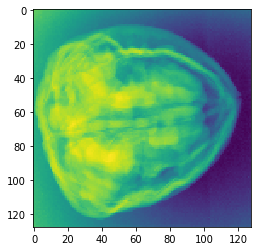

In [5]:
if __name__ == '__main__':

    cfg = Config(epoch=100, g_learning_rate=.005, d_learning_rate=0.00005, beta1=0.5, batch_size=1)
    tf.enable_eager_execution()

    run_config = tf.ConfigProto()
    run_config.gpu_options.allow_growth = True

    with tf.Session(config=run_config) as sess:

        df_dim = 64.
        batch_size = cfg.batch_size
        dropout_prob = 0.5 # probability of keeping
        l1_weight = 16.
        ssim_weight = 84.
        clipping_weight = 10.
        discriminator_weight = 1.
        writer_path = './l1w_16_ssim_84_cw_10_dw_1'
        file_path = "/home/ajay/work/Sparse CT/cancerimagingarchivedata/Walnut1/data/0_255_[128]_tubev1.npy"
#         intermediate_path = "/home/ajay/work/Sparse CT/cancerimagingarchivedata/intermediates/"
        finn = Finn(sess, df_dim, batch_size, dropout_prob, l1_weight, ssim_weight, clipping_weight, discriminator_weight, writer_path, file_path)
        finn.build_model()
        finn.train(cfg)
        finn.test(cfg)
